<a href="https://colab.research.google.com/github/emran-bigdeli/Modified-HRP/blob/main/CBOE_%26_CME.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Installing**

In [3]:
pip install wrds

In [4]:
import wrds
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import data_table

conn = wrds.Connection(wrds_username='emran_bigdeli')
#conn.get_table(library='optionm', table='option_price_2003', obs=1000)
conn.list_tables(library='optionm')

Loading library list...
Done


['country',
 'currency',
 'distrd',
 'distribution',
 'distribution_projection',
 'distrprojd1996',
 'distrprojd1997',
 'distrprojd1998',
 'distrprojd1999',
 'distrprojd2000',
 'distrprojd2001',
 'distrprojd2002',
 'distrprojd2003',
 'distrprojd2004',
 'distrprojd2005',
 'distrprojd2006',
 'distrprojd2007',
 'distrprojd2008',
 'distrprojd2009',
 'distrprojd2010',
 'distrprojd2011',
 'distrprojd2012',
 'distrprojd2013',
 'distrprojd2014',
 'distrprojd2015',
 'distrprojd2016',
 'distrprojd2017',
 'distrprojd2018',
 'distrprojd2019',
 'distrprojd2020',
 'distrprojd2021',
 'distrprojd2022',
 'distrprojd2023',
 'exchange',
 'exchgd',
 'forward_price',
 'futures',
 'futures_price',
 'fwdprd1996',
 'fwdprd1997',
 'fwdprd1998',
 'fwdprd1999',
 'fwdprd2000',
 'fwdprd2001',
 'fwdprd2002',
 'fwdprd2003',
 'fwdprd2004',
 'fwdprd2005',
 'fwdprd2006',
 'fwdprd2007',
 'fwdprd2008',
 'fwdprd2009',
 'fwdprd2010',
 'fwdprd2011',
 'fwdprd2012',
 'fwdprd2013',
 'fwdprd2014',
 'fwdprd2015',
 'fwdprd2016',


In [ ]:
options_data = conn.raw_sql("""SELECT symbol, strike_price, best_bid, best_offer, date,  exdate  FROM optionm.opprcd2022 WHERE

                            (secid=108105 or secid=109820) and
                            cp_flag='C' and
                            date = '2022-06-22'""")

# Removing the SPXW from the data, because their expiration have different format but same date!
options_data = options_data[~(options_data["symbol"].str[3] == 'W')]

#keeping the first three character which SPX or SPY
options_data['symbol'] = options_data["symbol"].str[:3]

#Keeping Strike prices that is common for both SPX and SPY. SPY step is 10 and SPX step is 25 in strike prices.
options_data = options_data[(options_data["strike_price"]%50==0)]

#Adjusting the price. SPY price is tenth of SPX
options_data.loc[options_data['symbol'] == 'SPY', 'strike_price'] /= 100
options_data.loc[options_data['symbol'] == 'SPX', 'strike_price'] /= 1000
options_data.loc[options_data['symbol'] == 'SPY', 'best_bid'] *= 10
options_data.loc[options_data['symbol'] == 'SPY', 'best_offer'] *= 10
options_data['exdate'] = options_data['exdate'].astype(str)
options_data['midpoint']= (options_data['best_bid']+options_data['best_offer'])/2
options_data['rel_spread']= (options_data['best_offer']-options_data['best_bid'])/options_data['midpoint']

#Keeping Strike prices that is common for both SPX and SPY. SPY step is 10 and SPX step is 25 in strike prices.
options_data = options_data[(options_data["strike_price"]%50==0)]

SPX=4400

options_data.loc[options_data['strike_price']>SPX,'moneyness'] = "OTC"
options_data.loc[options_data['strike_price']<SPX,'moneyness'] = "ITC"
options_data.loc[options_data['strike_price']==SPX,'moneyness'] = "ATC"



In [ ]:
options_data[(options_data['strike_price'] >= 4200) & (options_data['strike_price'] <= 4900) & (options_data['exdate'] == "2024-12-20")].sort_values(['strike_price'])

In [ ]:
subsample=options_data[(options_data['strike_price'] >= 4300) & (options_data['strike_price'] <= 4600) & (options_data['exdate'].str[:4] == "2023")].sort_values(['strike_price'])
table = subsample.pivot(index=["moneyness", 'strike_price', "symbol"], columns='exdate', values='rel_spread').dropna(axis=1)
table

In [ ]:
options_data[(options_data['strike_price'] >= 4300) & (options_data['strike_price'] <= 4600) & (options_data['exdate'] == "2023-06-16")].groupby(['moneyness','strike_price',"exdate",'symbol']).mean()


# **Risk Netural Density**


In [9]:
options_data_spx = conn.raw_sql("""SELECT symbol, strike_price, best_bid, best_offer, date,  exdate  FROM optionm.opprcd2022 WHERE

                            (secid=108105) and
                            cp_flag='C' and
                            exdate = '2026-12-18' and
                            date >= '2022-06-22'""")

# Removing the SPXW from the data, because their expiration have different format but same date!
options_data_spx = options_data_spx[~(options_data_spx["symbol"].str[3] == 'W')]

#keeping the first three character which SPX
options_data_spx['symbol'] = options_data_spx["symbol"].str[:3]

#Adjusting the price
options_data_spx.loc[options_data_spx['symbol'] == 'SPX', 'strike_price'] /= 1000
options_data_spx['exdate'] = options_data_spx['exdate'].astype(str)
options_data_spx['midpoint']= (options_data_spx['best_bid']+options_data_spx['best_offer'])/2
options_data_spx['rel_spread']= (options_data_spx['best_offer']-options_data_spx['best_bid'])/options_data_spx['midpoint']

SPX=4400

options_data_spx.loc[options_data_spx['strike_price']>SPX,'moneyness'] = "OTC"
options_data_spx.loc[options_data_spx['strike_price']<SPX,'moneyness'] = "ITC"
options_data_spx.loc[options_data_spx['strike_price']==SPX,'moneyness'] = "ATC"

options_data_spx.sort_values(["date","strike_price"],inplace=True)
mask = ((options_data_spx['date'] == options_data_spx['date'].shift(1)) & (options_data_spx['date'] == options_data_spx['date'].shift(-1)))
options_data_spx.loc[mask, 'Risk_Neutral_Probability'] = (options_data_spx['midpoint'].shift(1) + options_data_spx['midpoint'].shift(-1) - 2 * options_data_spx['midpoint']) / (options_data_spx['strike_price'].shift(1)-options_data_spx['strike_price']) / (options_data_spx['strike_price']-options_data_spx['strike_price'].shift(-1)) * 100

options_data_spx.dropna(inplace=True)


In [24]:
options_data_spx[0:60]

symbol  strike_price  best_bid  best_offer        date      exdate  \
21    SPX         400.0    3265.9      3347.5  2023-01-03  2026-12-18   
42    SPX         600.0    3099.5      3177.3  2023-01-03  2026-12-18   
53    SPX         800.0    2934.6      3008.6  2023-01-03  2026-12-18   
0     SPX        1000.0    2771.2      2841.4  2023-01-03  2026-12-18   
2     SPX        1200.0    2609.2      2675.9  2023-01-03  2026-12-18   
3     SPX        1400.0    2448.9      2512.5  2023-01-03  2026-12-18   
4     SPX        1600.0    2290.7      2351.1  2023-01-03  2026-12-18   
5     SPX        1800.0    2135.1      2192.6  2023-01-03  2026-12-18   
7     SPX        2000.0    1982.4      2037.3  2023-01-03  2026-12-18   
8     SPX        2200.0    1833.8      1886.1  2023-01-03  2026-12-18   
9     SPX        2400.0    1689.3      1739.3  2023-01-03  2026-12-18   
10    SPX        2600.0    1549.7      1597.2  2023-01-03  2026-12-18   
11    SPX        2800.0    1415.3      1460.4  2023-01-03  2026-12-18   
12    SPX        3000.0    1286.4      1329.5  2023-01-03  2026-12-18   
13    SPX        3200.0    1163.2      1204.1  2023-01-03  2026-12-18   
14    SPX        3300.0    1103.8      1143.7  2023-01-03  2026-12-18   
15    SPX        3400.0    1046.0      1084.8  2023-01-03  2026-12-18   
16    SPX        3500.0     989.5      1027.3  2023-01-03  2026-12-18   
17    SPX        3600.0     934.7       971.5  2023-01-03  2026-12-18   
18    SPX        3700.0     881.3       917.0  2023-01-03  2026-12-18   
19    SPX        3800.0     829.1       863.9  2023-01-03  2026-12-18   
20    SPX        3900.0     778.7       812.0  2023-01-03  2026-12-18   
22    SPX        4000.0     729.5       762.0  2023-01-03  2026-12-18   
23    SPX        4100.0     681.7       713.6  2023-01-03  2026-12-18   
24    SPX        4200.0     635.5       666.7  2023-01-03  2026-12-18   
25    SPX        4300.0     598.5       611.9  2023-01-03  2026-12-18   
26    SPX        4400.0     555.2       568.3  2023-01-03  2026-12-18   
27    SPX        4500.0     513.4       526.2  2023-01-03  2026-12-18   
28    SPX        4600.0     473.2       485.9  2023-01-03  2026-12-18   
29    SPX        4700.0     434.6       447.5  2023-01-03  2026-12-18   
30    SPX        4800.0     398.1       411.1  2023-01-03  2026-12-18   
31    SPX        4900.0     363.6       376.6  2023-01-03  2026-12-18   
32    SPX        5000.0     331.2       344.2  2023-01-03  2026-12-18   
33    SPX        5100.0     301.1       314.1  2023-01-03  2026-12-18   
34    SPX        5200.0     273.3       286.4  2023-01-03  2026-12-18   
35    SPX        5300.0     247.5       260.6  2023-01-03  2026-12-18   
36    SPX        5400.0     223.7       236.8  2023-01-03  2026-12-18   
37    SPX        5500.0     202.1       214.9  2023-01-03  2026-12-18   
38    SPX        5600.0     182.4       195.0  2023-01-03  2026-12-18   
39    SPX        5700.0     164.5       176.7  2023-01-03  2026-12-18   
40    SPX        5800.0     148.3       160.2  2023-01-03  2026-12-18   
41    SPX        5900.0     133.6       145.3  2023-01-03  2026-12-18   
43    SPX        6000.0     120.4       131.8  2023-01-03  2026-12-18   
44    SPX        6200.0      97.9       108.8  2023-01-03  2026-12-18   
45    SPX        6400.0      79.9        90.1  2023-01-03  2026-12-18   
46    SPX        6600.0      65.7        75.0  2023-01-03  2026-12-18   
47    SPX        6800.0      54.2        62.9  2023-01-03  2026-12-18   
48    SPX        7000.0      44.9        53.1  2023-01-03  2026-12-18   
49    SPX        7200.0      37.4        45.1  2023-01-03  2026-12-18   
50    SPX        7400.0      31.3        38.6  2023-01-03  2026-12-18   
51    SPX        7600.0      26.4        33.2  2023-01-03  2026-12-18   
52    SPX        7800.0      22.4        28.7  2023-01-03  2026-12-18   
54    SPX        8000.0      19.0        24.8  2023-01-03  2026-12-18   
55    SPX        8200.0      16.4        21.9  2023-01-03  20

In [ ]:
options_data_xsp = conn.raw_sql("""SELECT symbol, strike_price, best_bid, best_offer, date,  exdate  FROM optionm.opprcd2014 WHERE

                            secid=125063  """)

# Removing the SPXW from the data, because their expiration have different format but same date!
#options_data_xsp = options_data_xsp[~(options_data_xsp["symbol"].str[3] == 'W')]

#keeping the first three character which SPX


In [7]:
options_data_spx = options_data_spx[(options_data_spx["moneyness"]=="OTC")]

/usr/local/lib/python3.10/dist-packages/pandas/plotting/_matplotlib/core.py:512: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = self.plt.figure(figsize=self.figsize)


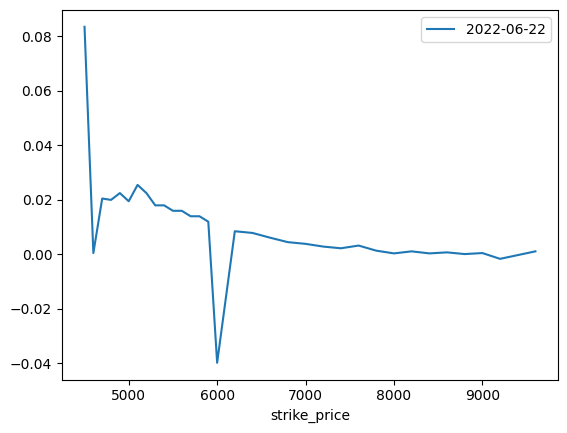

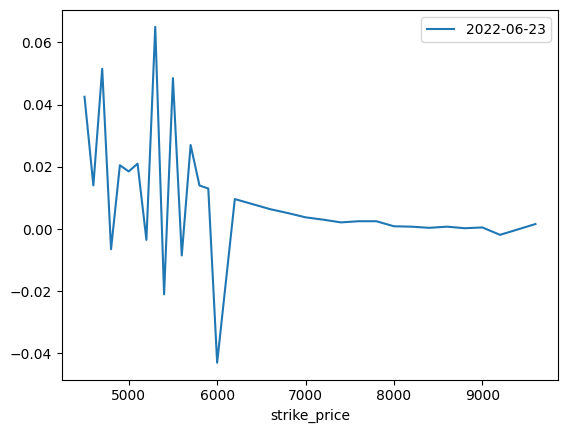

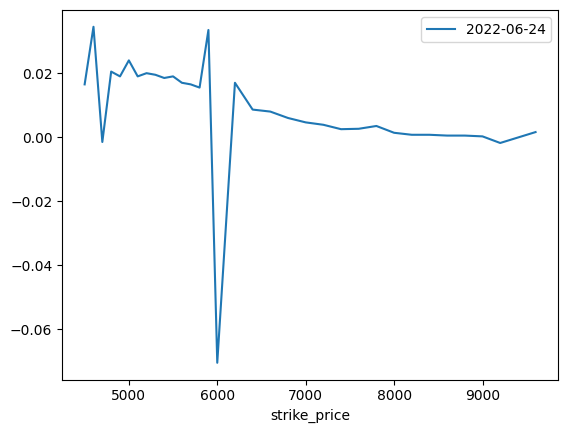

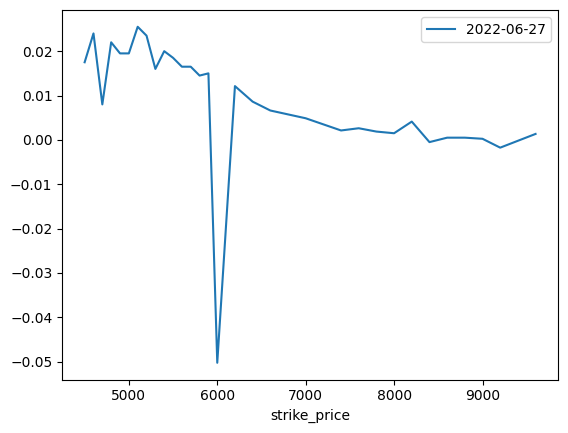

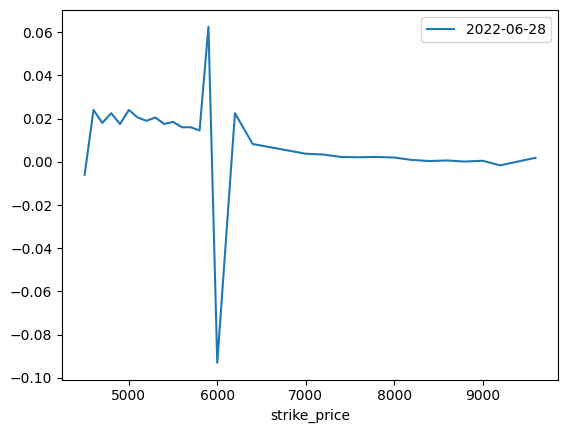

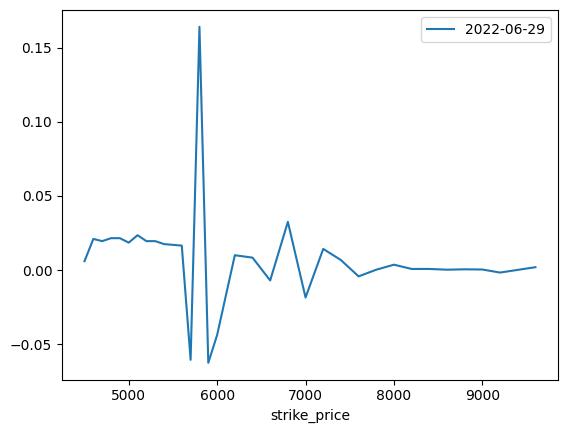

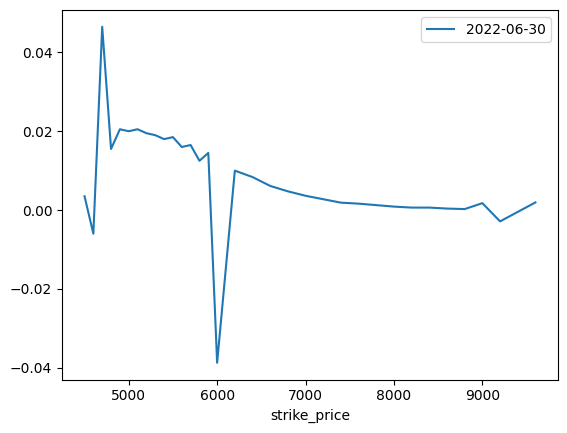

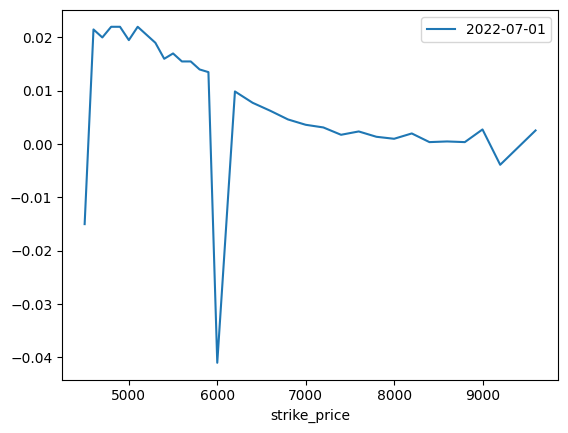

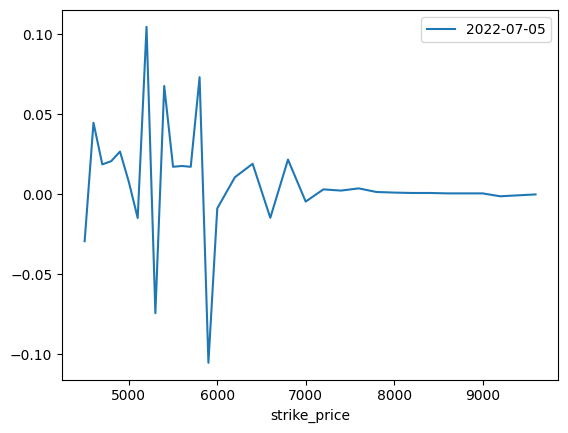

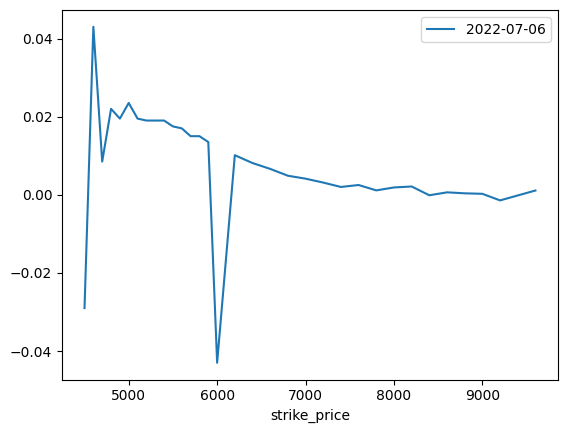

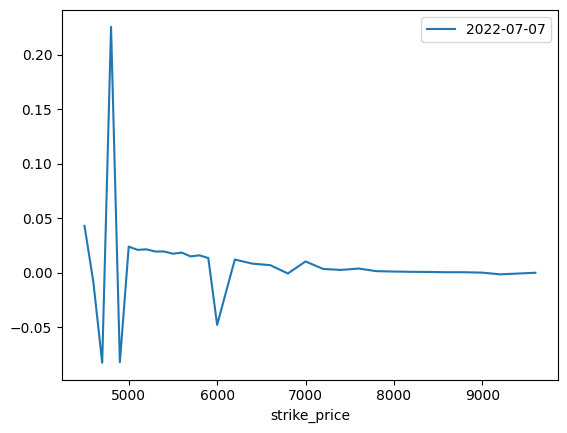

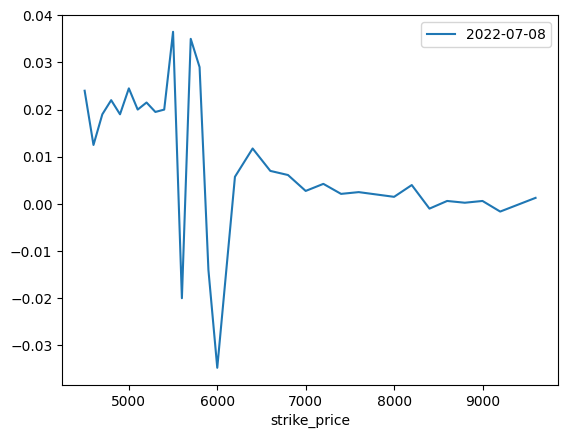

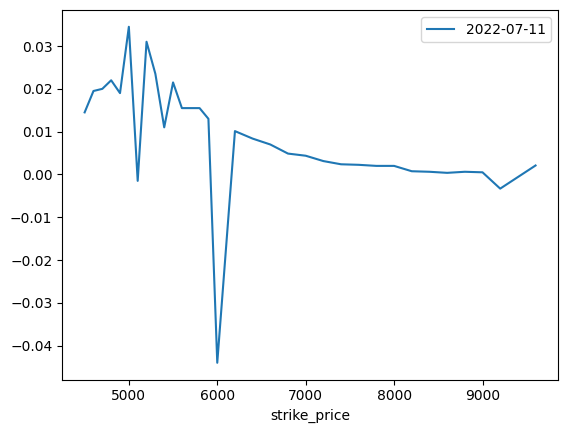

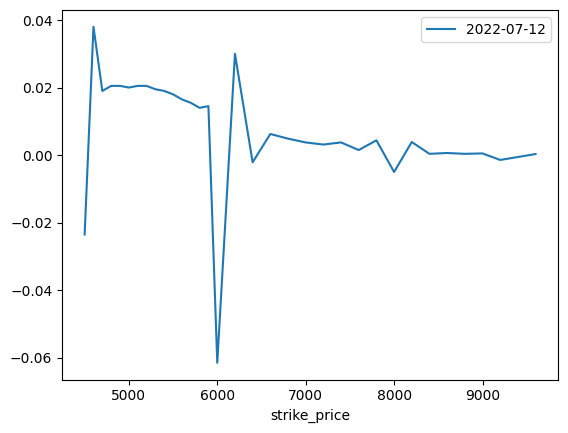

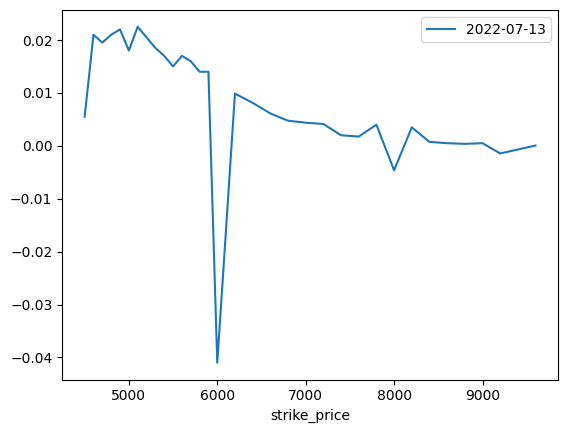

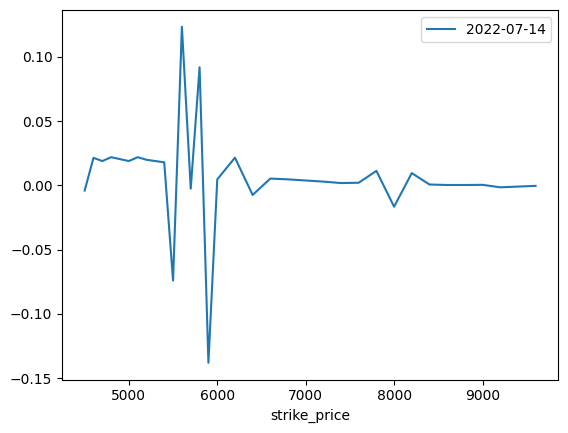

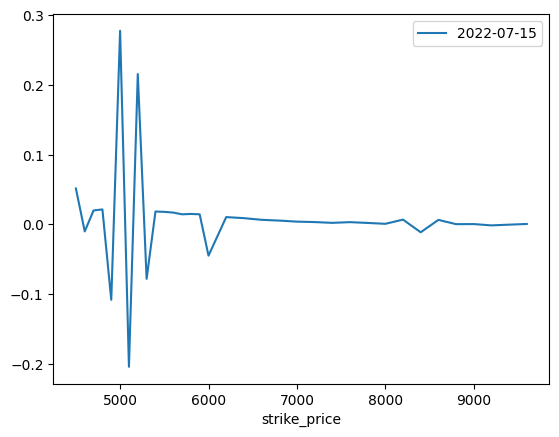

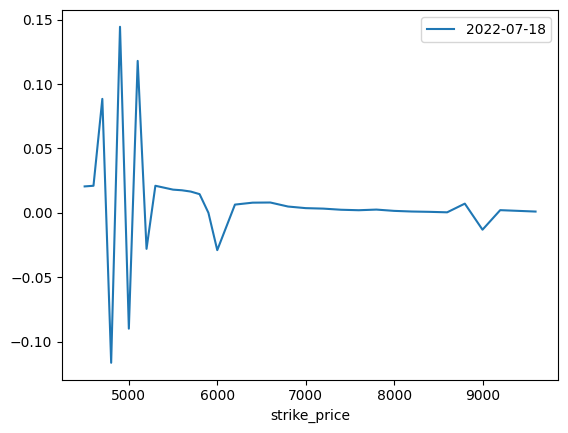

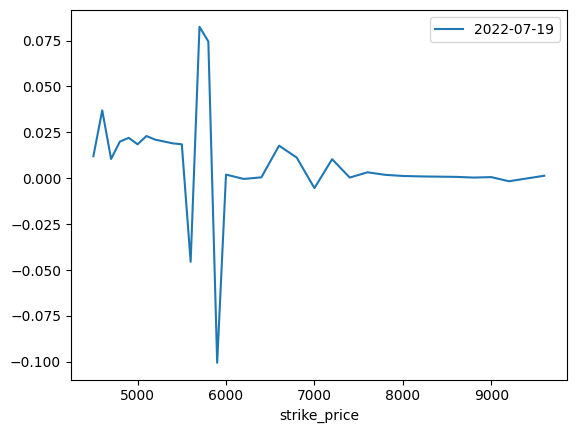

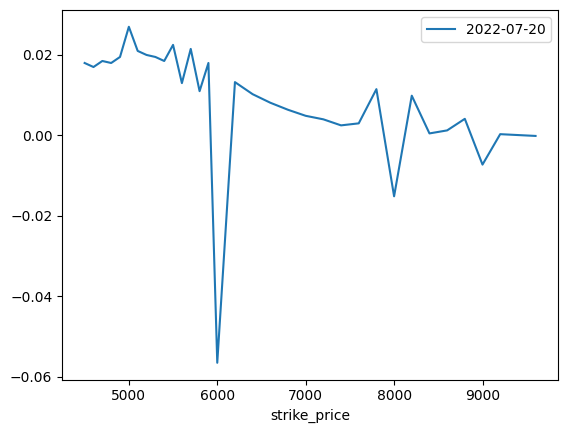

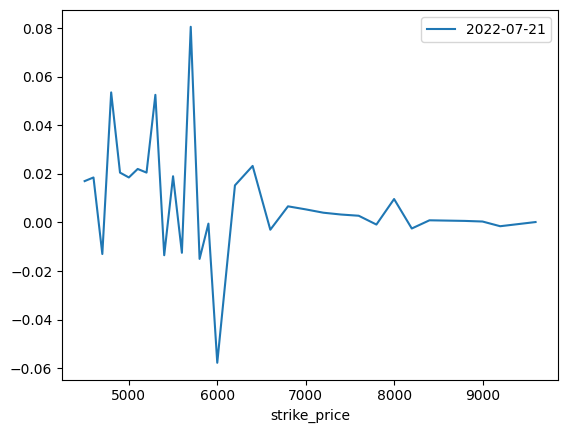

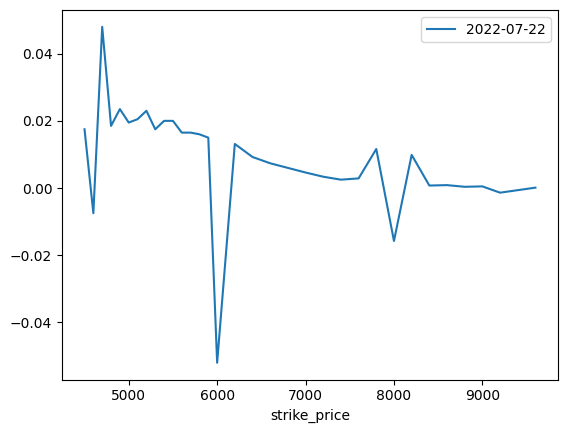

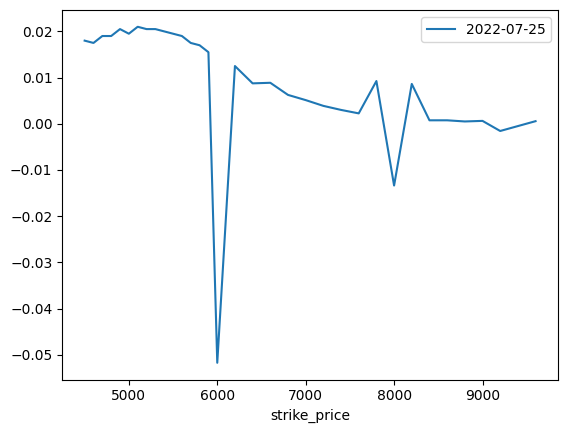

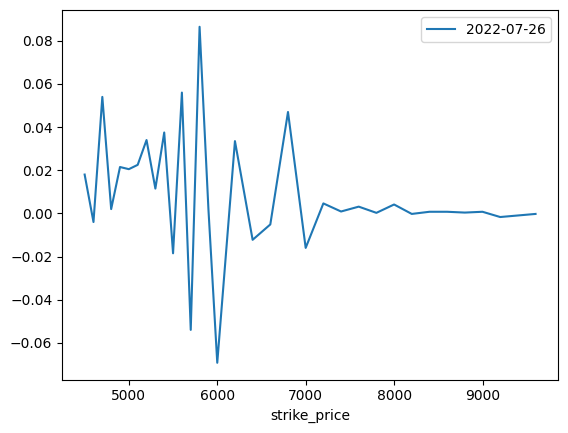

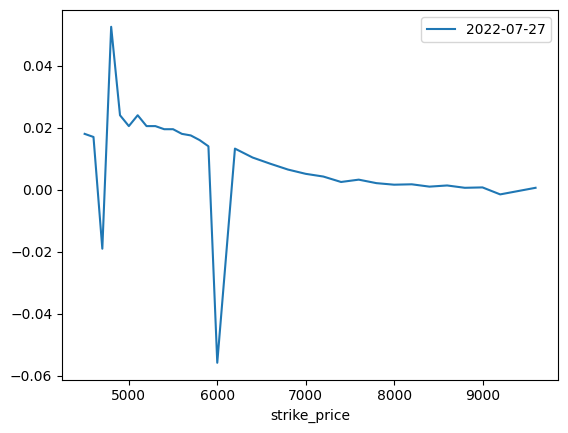

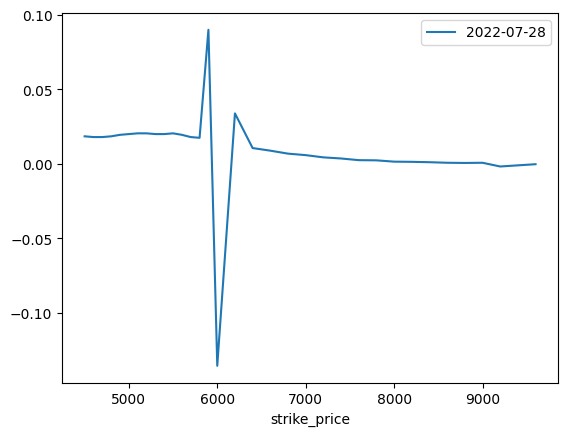

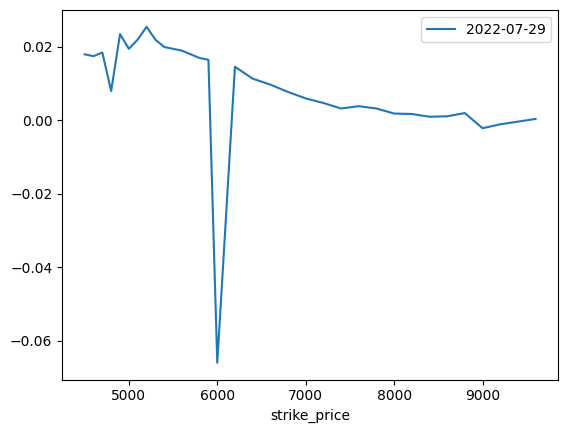

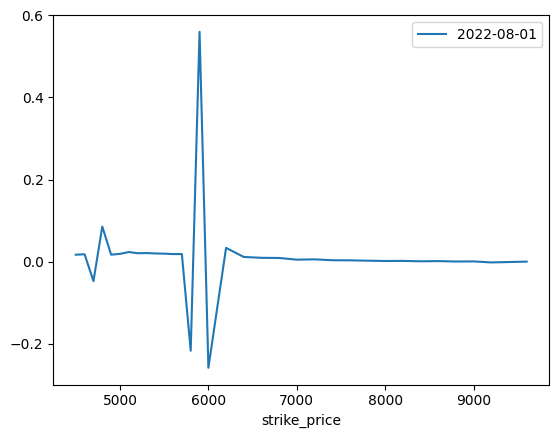

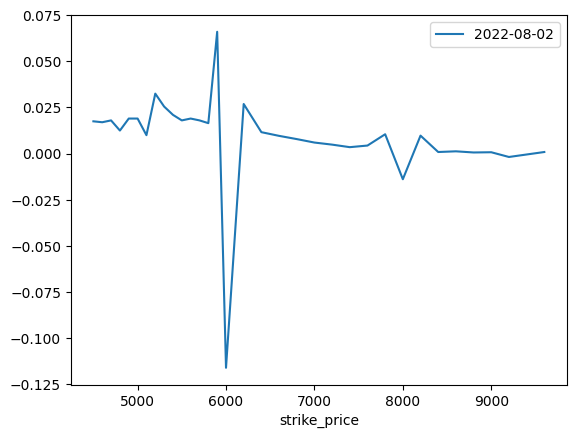

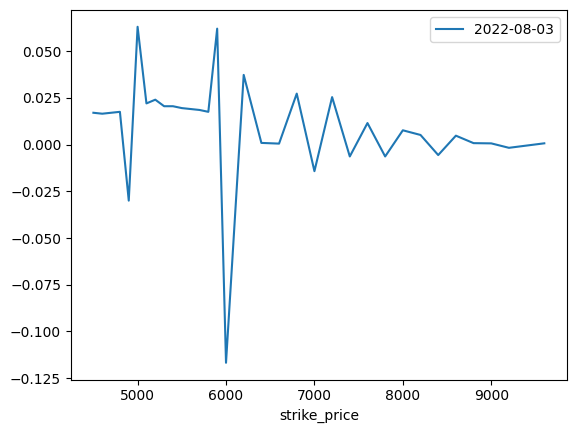

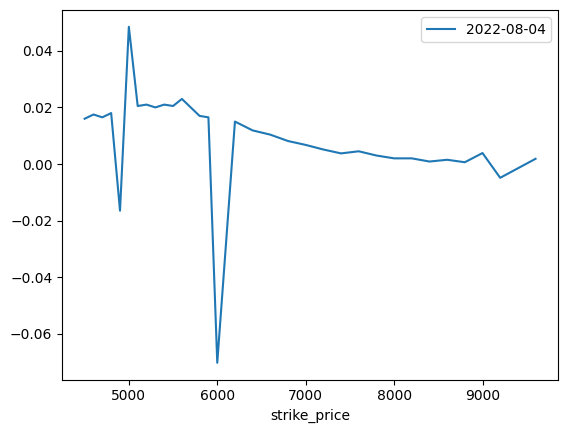

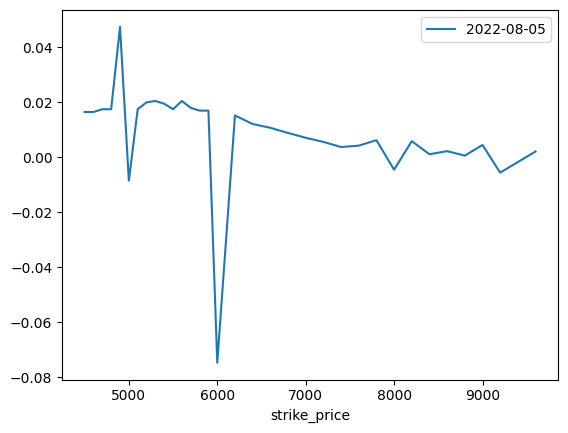

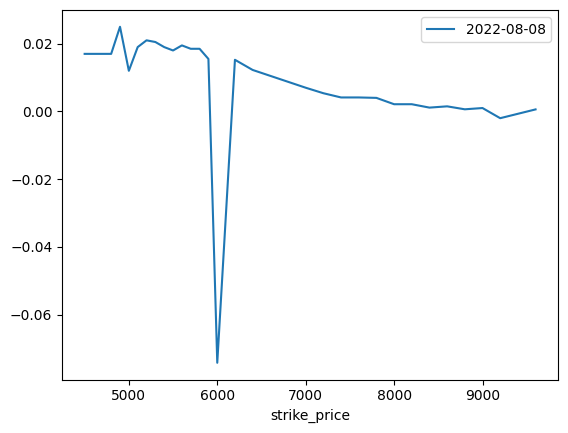

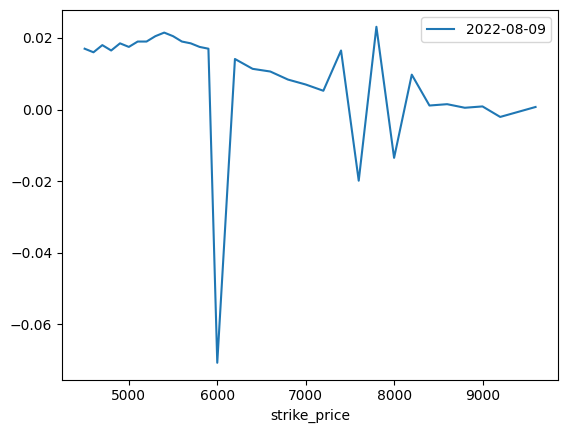

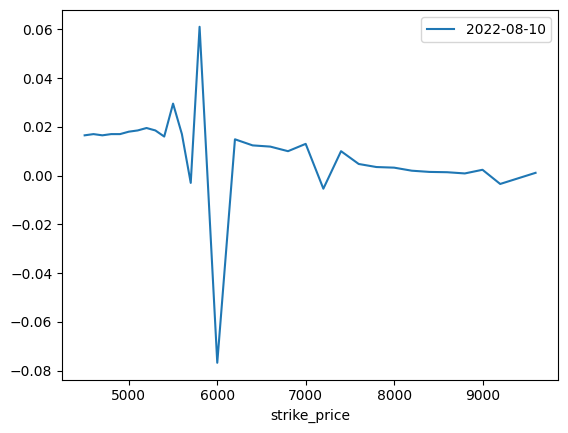

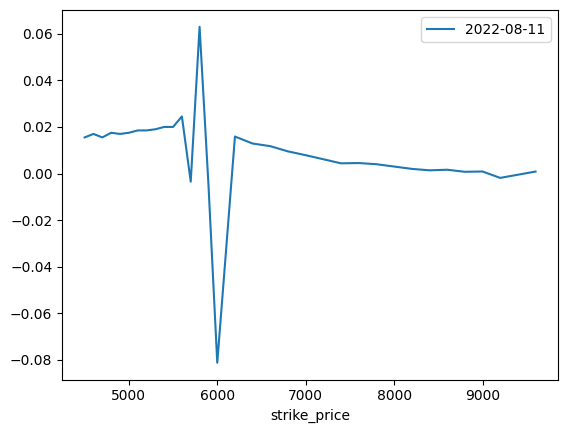

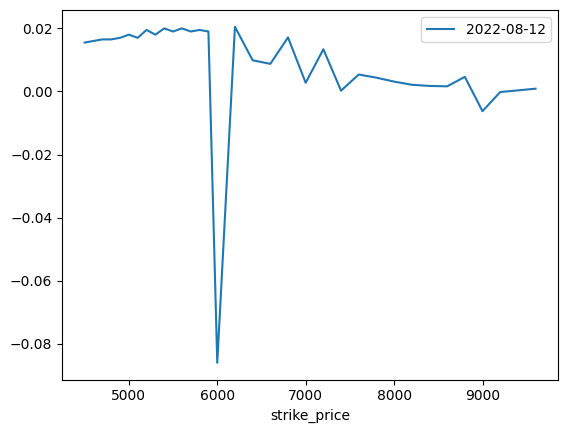

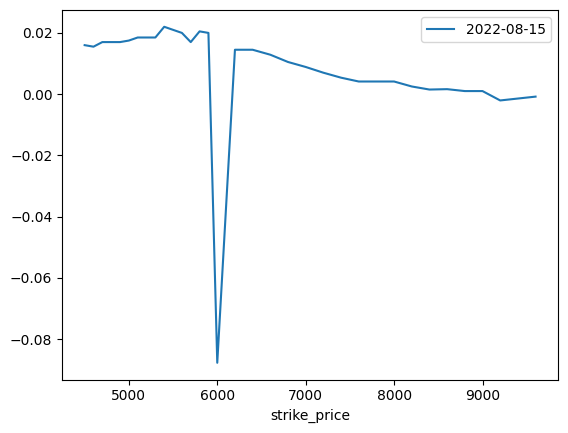

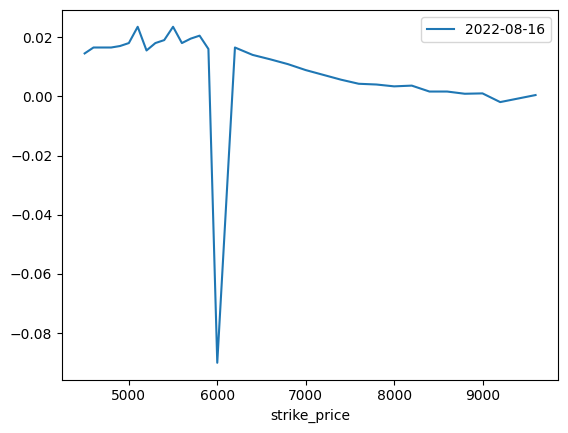

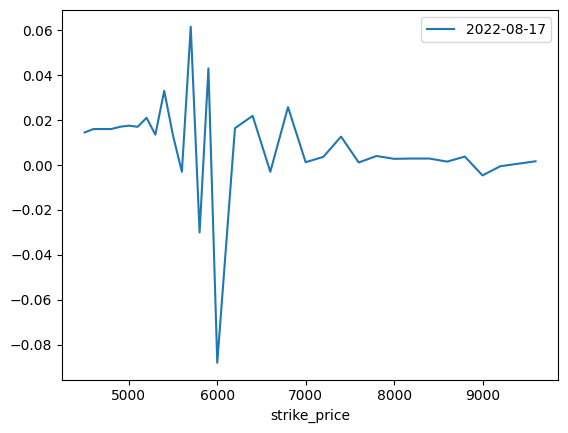

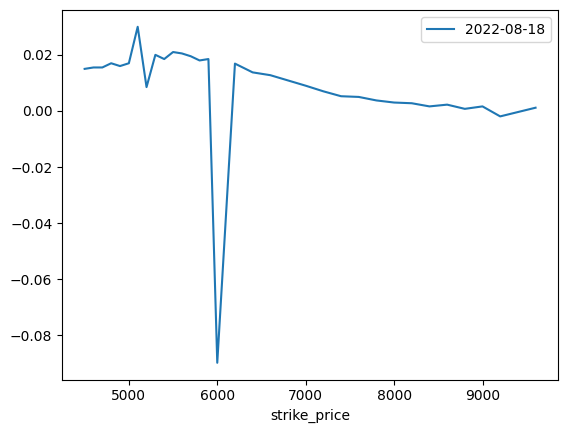

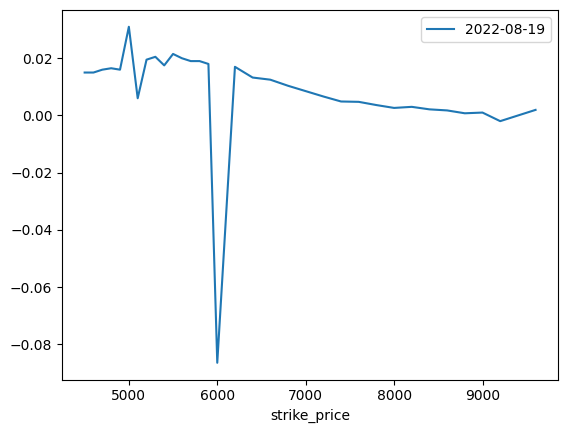

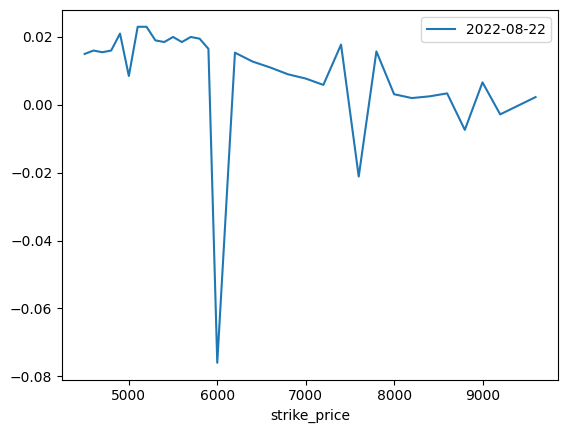

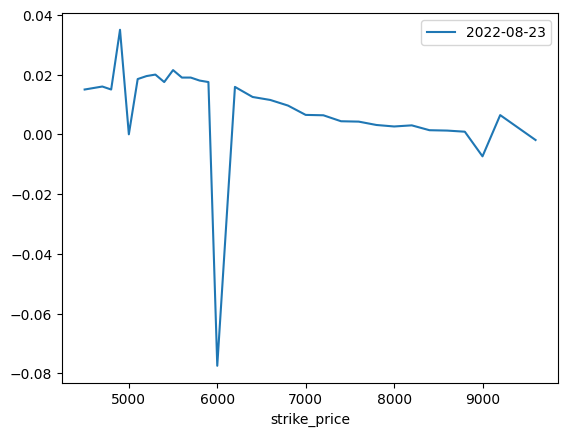

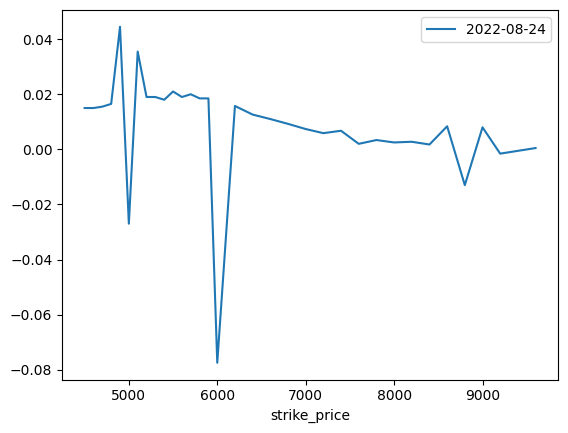

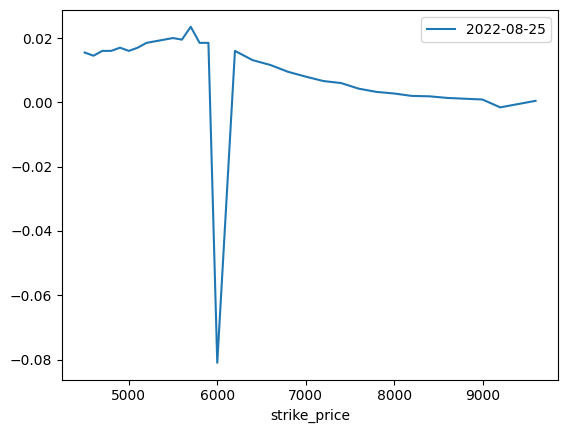

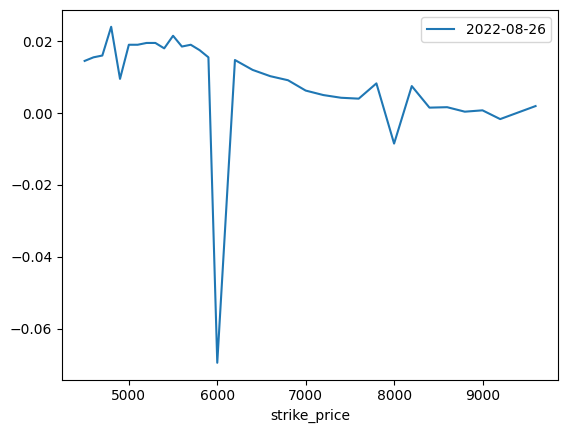

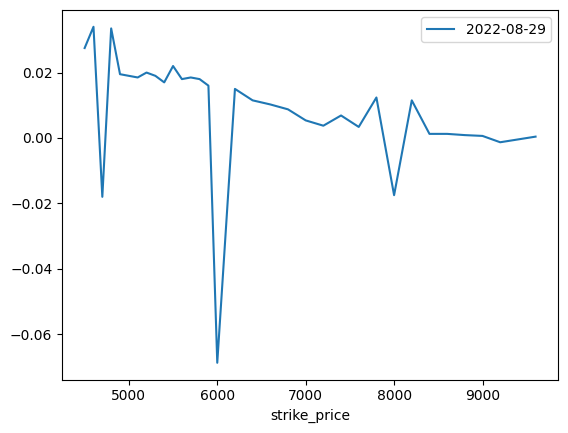

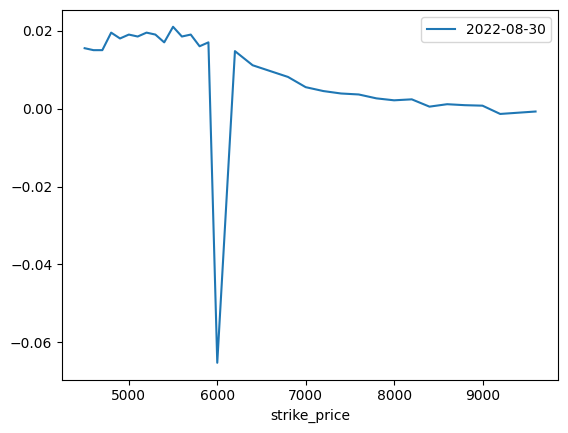

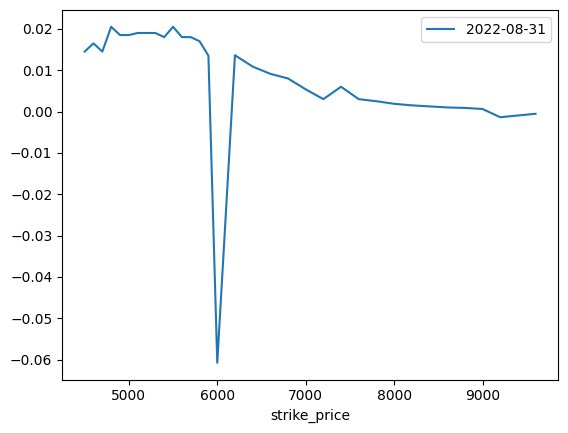

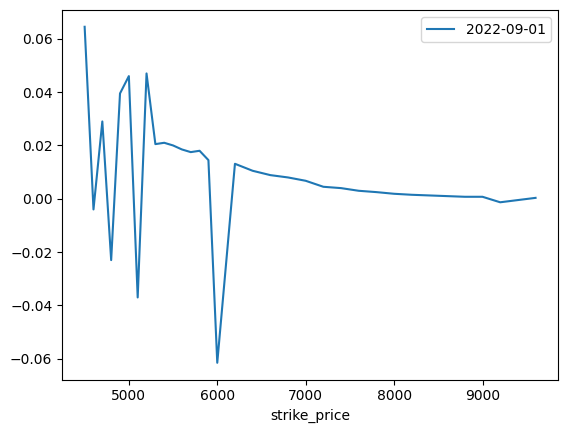

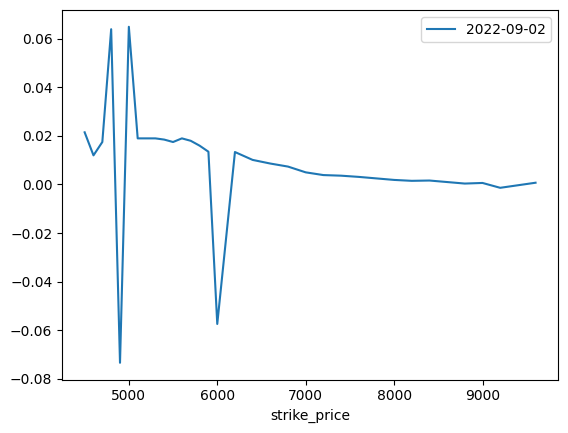

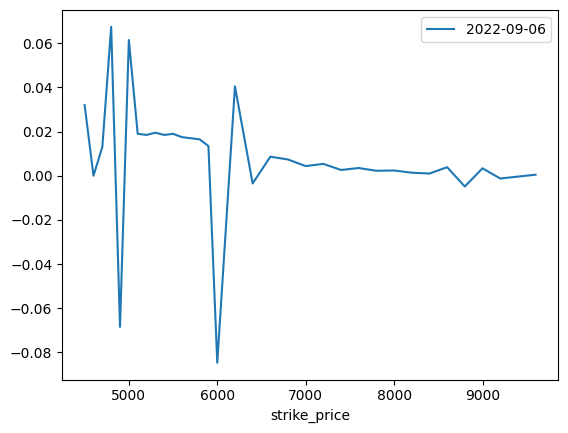

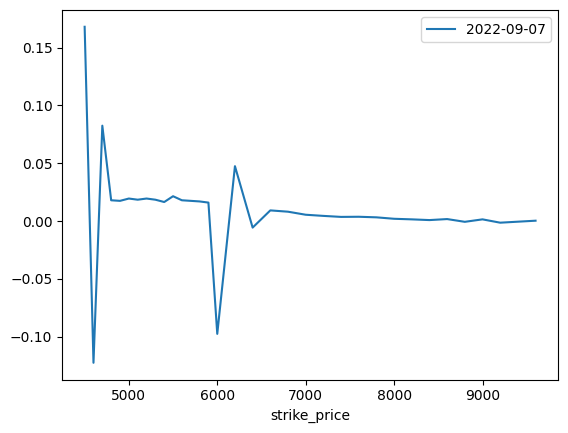

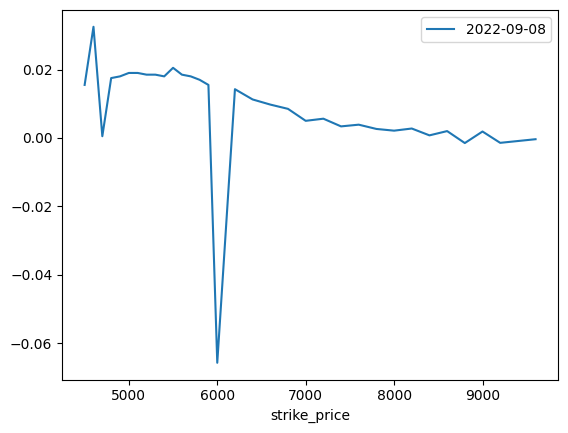

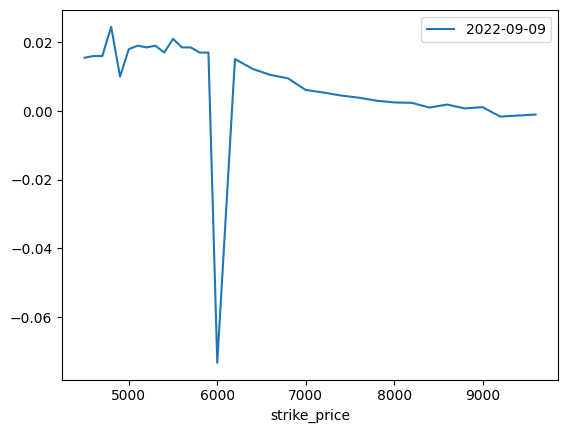

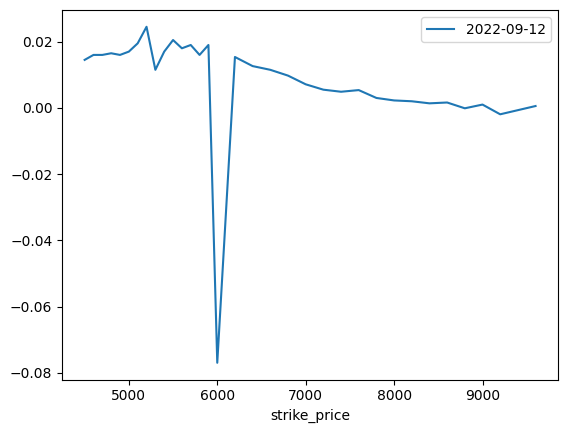

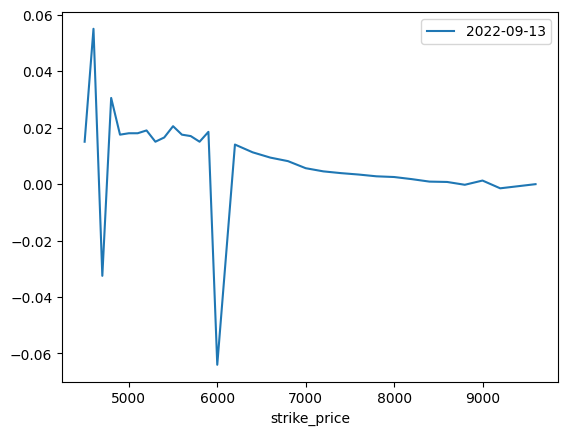

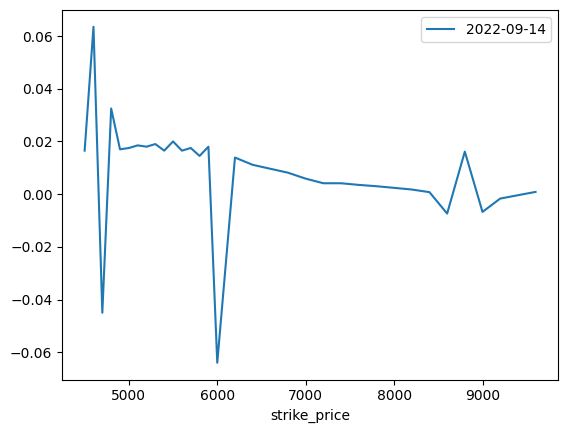

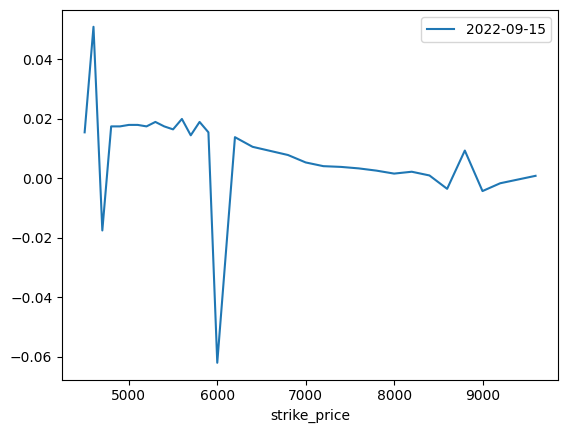

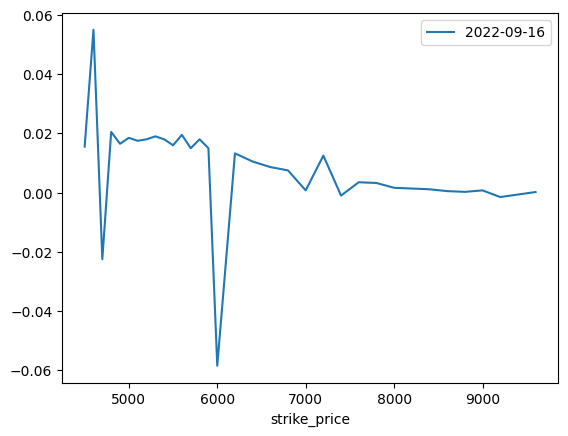

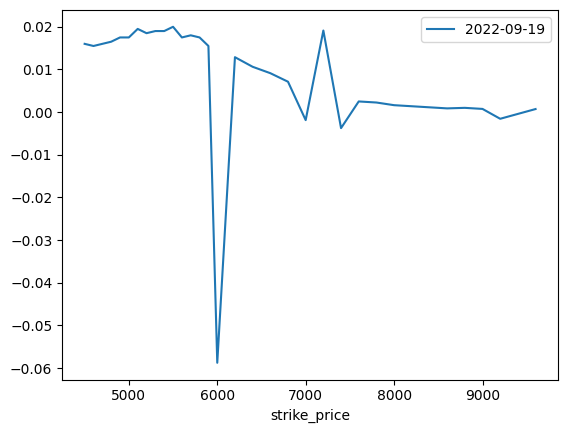

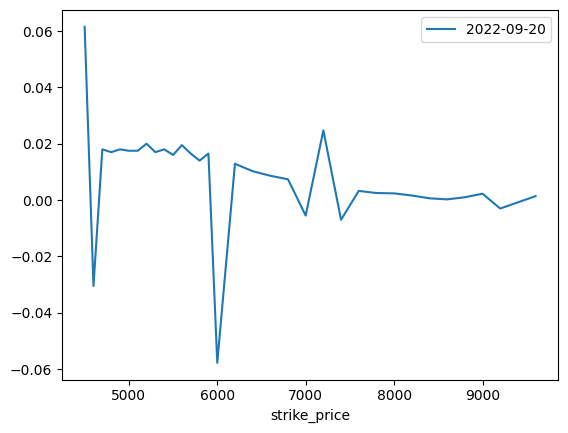

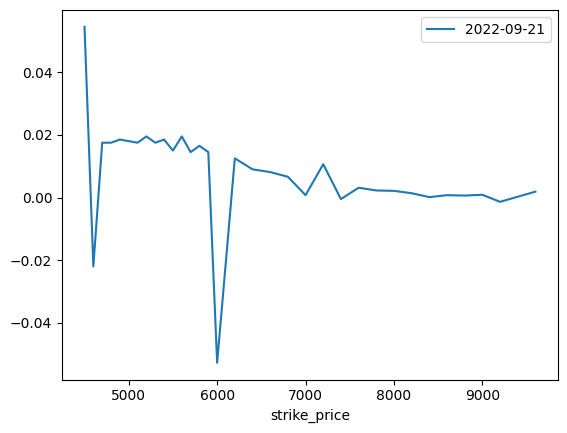

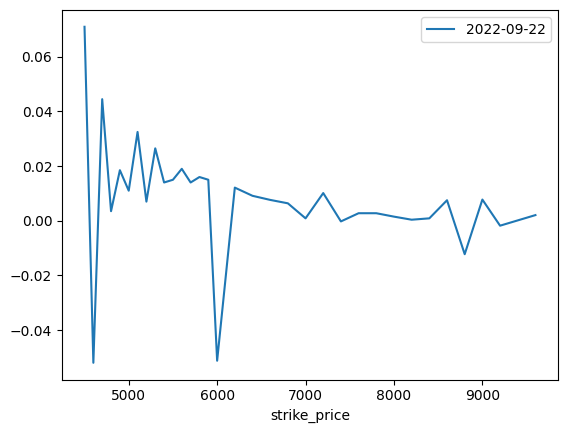

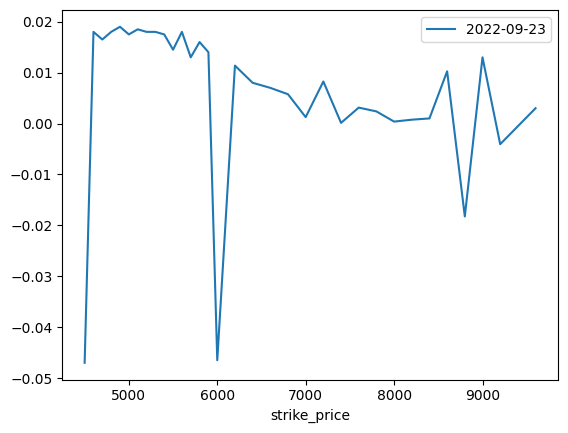

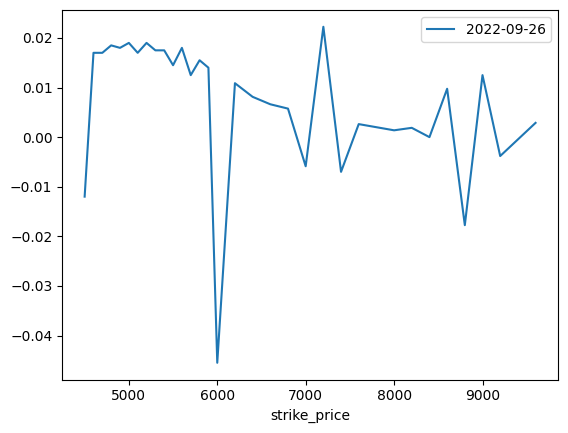

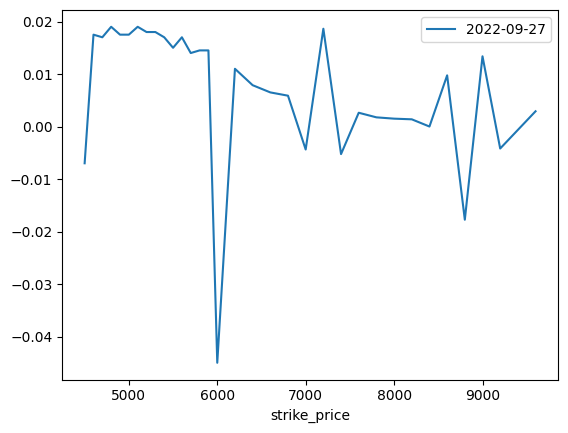

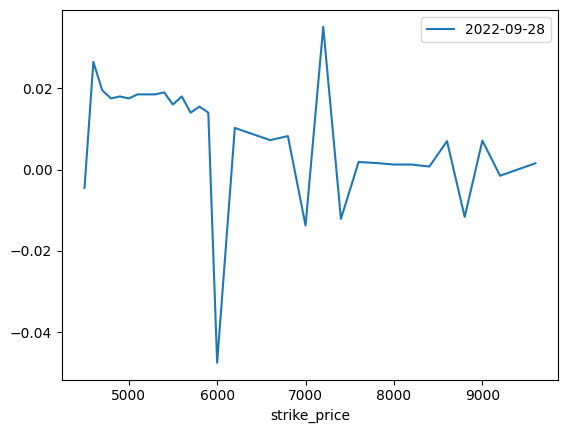

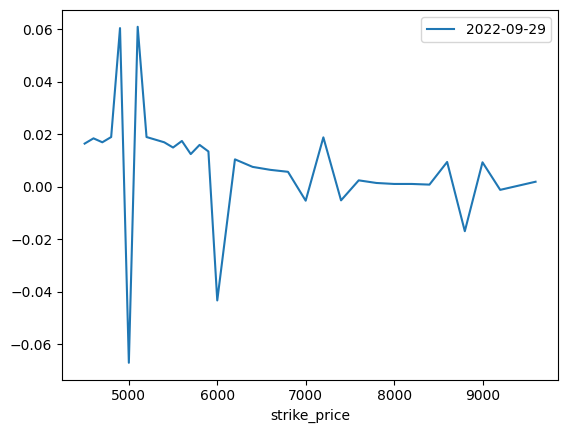

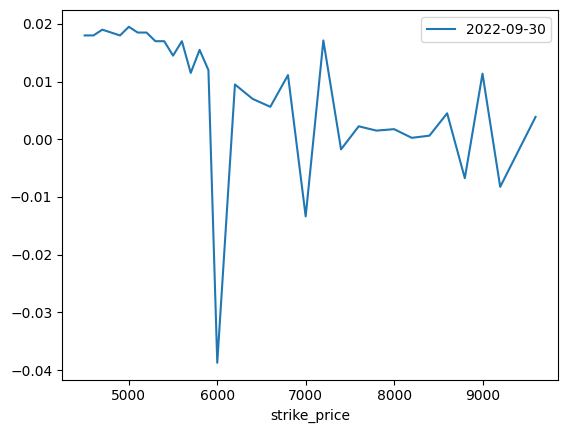

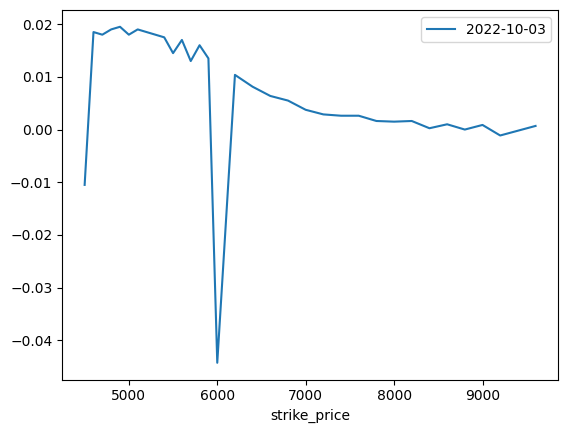

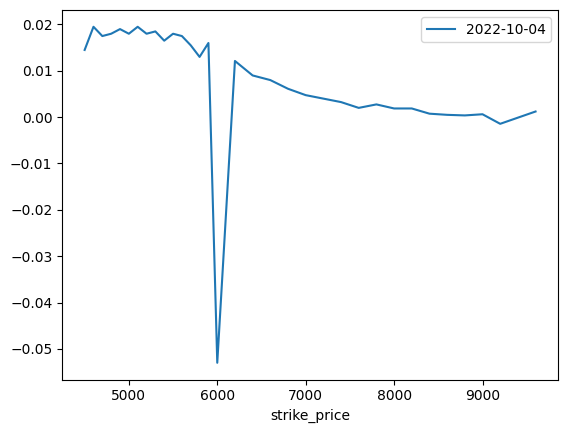

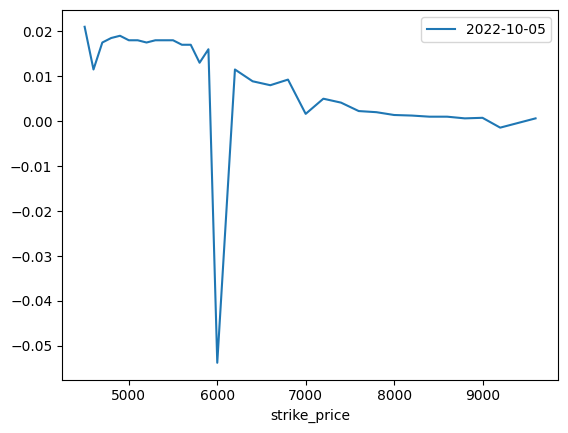

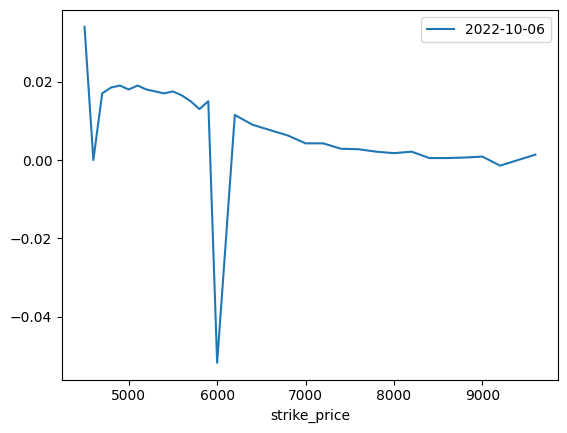

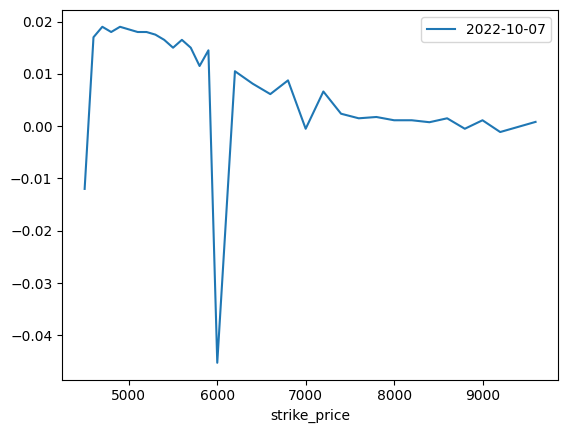

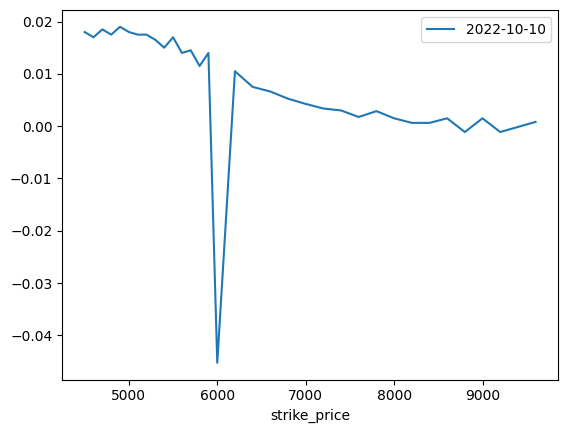

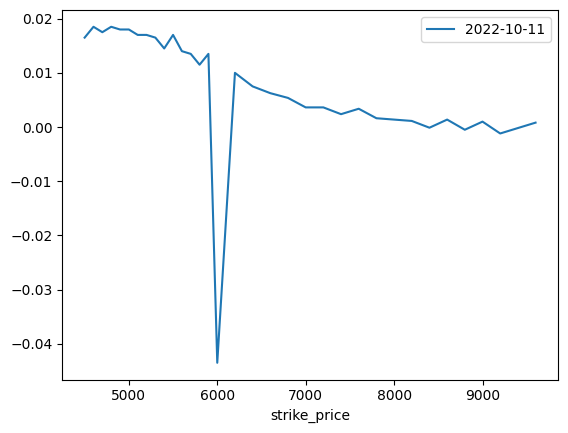

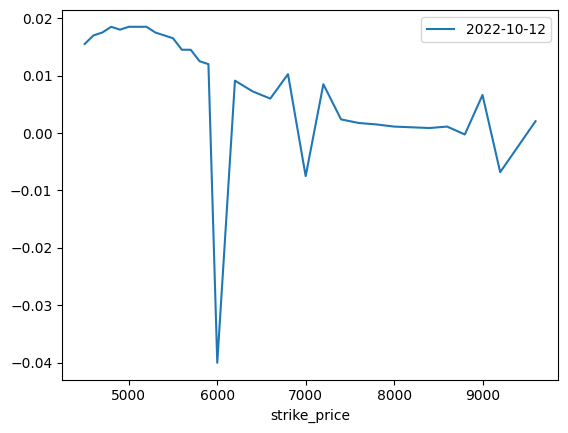

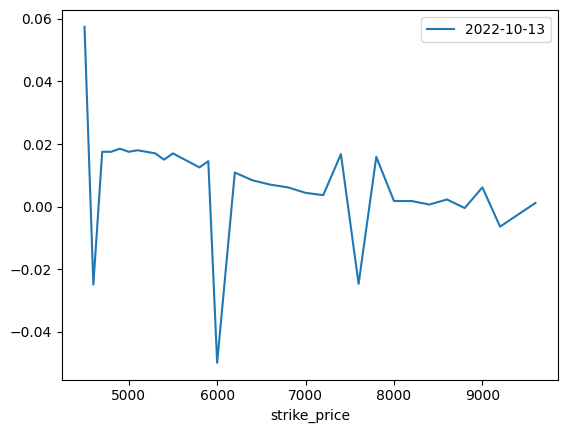

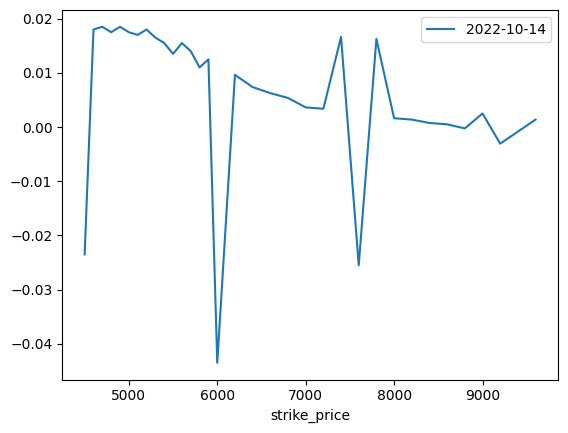

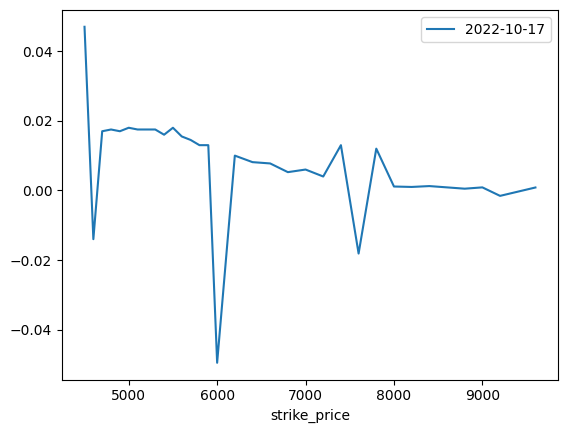

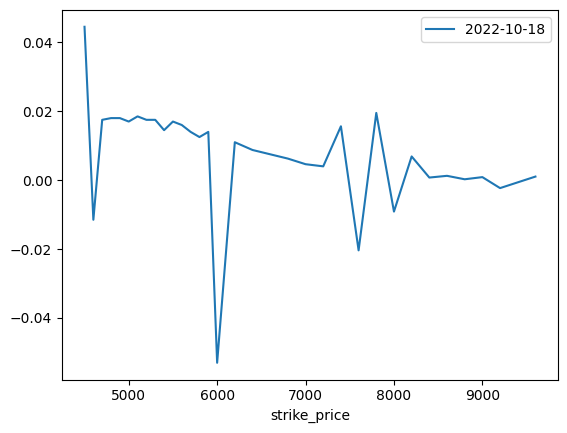

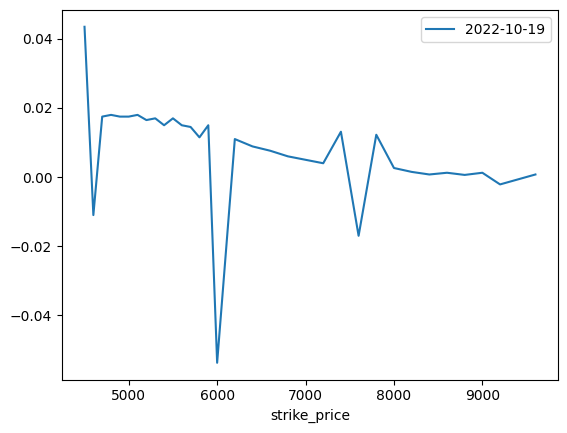

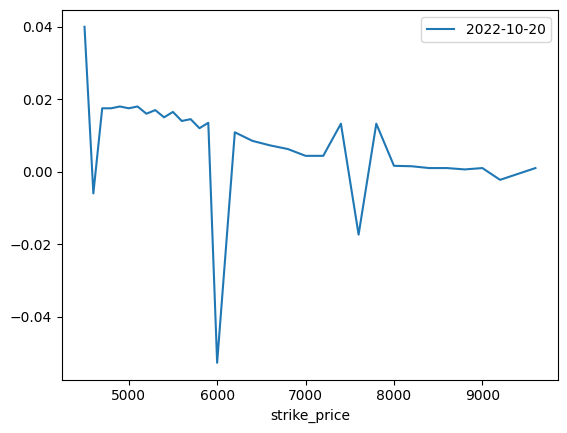

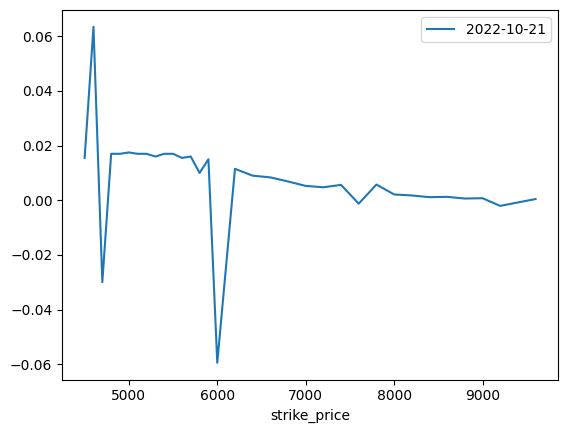

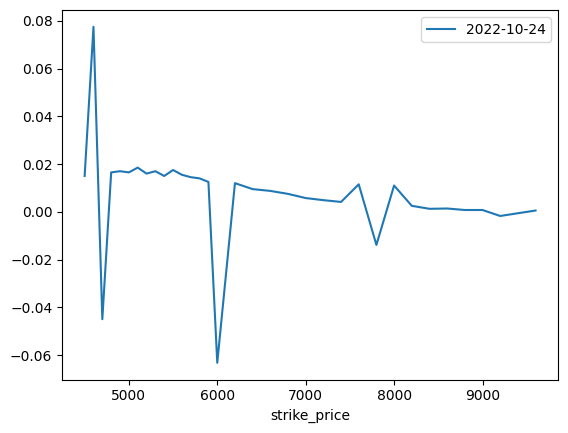

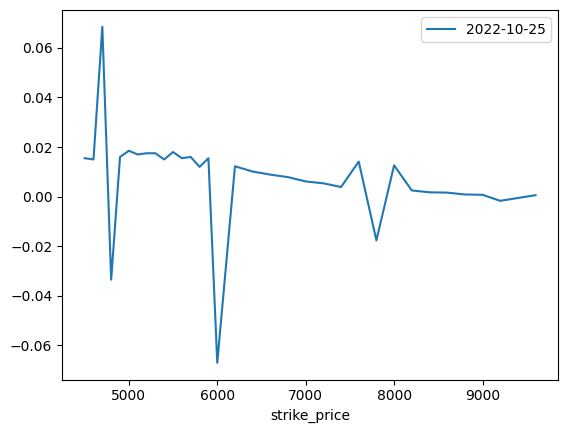

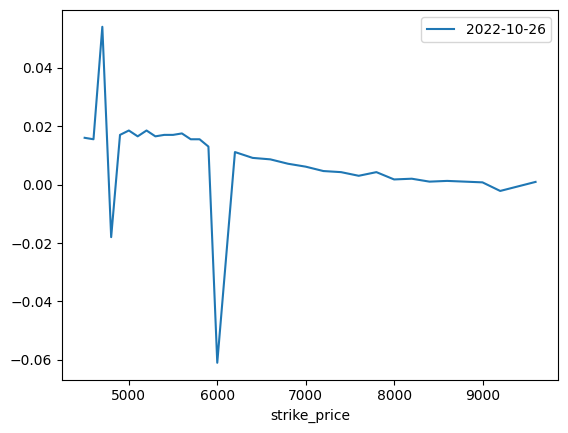

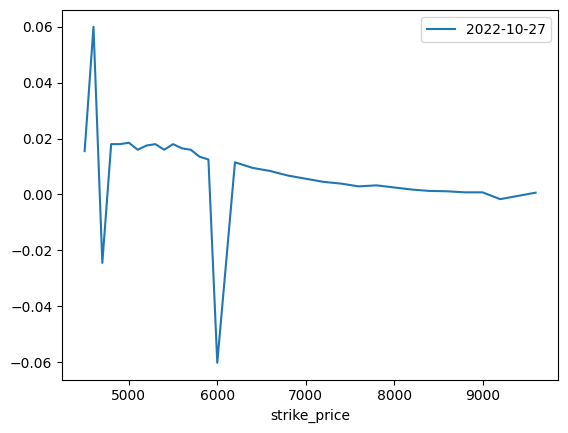

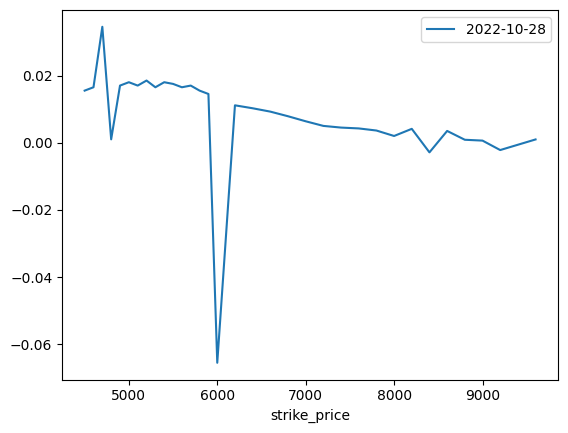

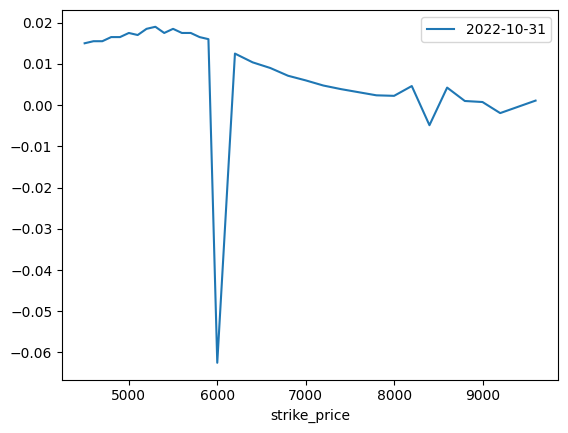

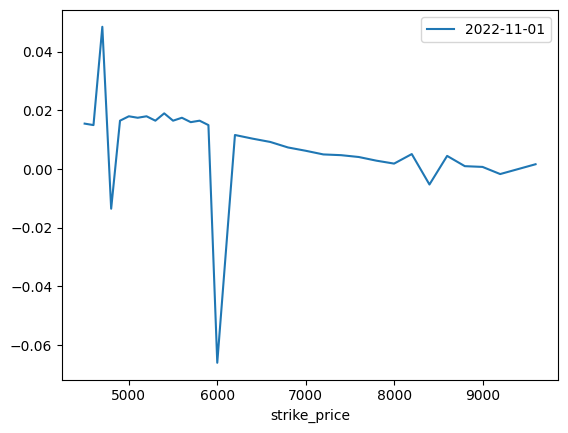

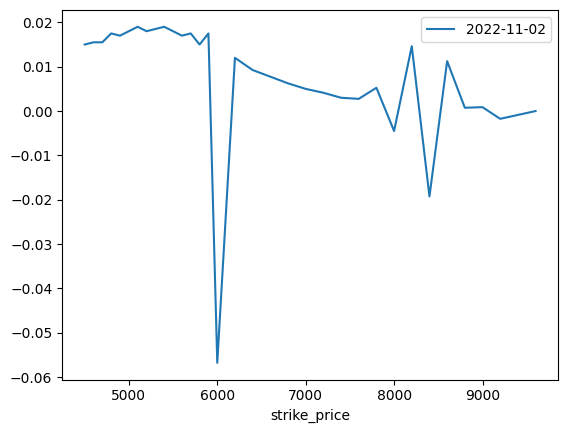

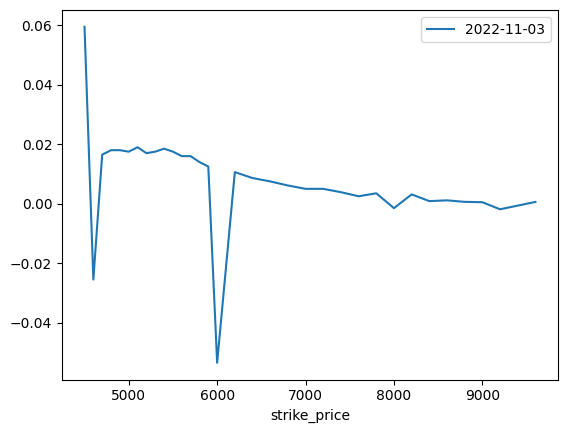

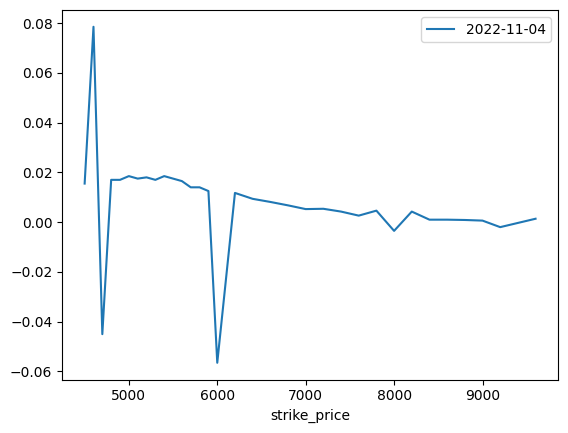

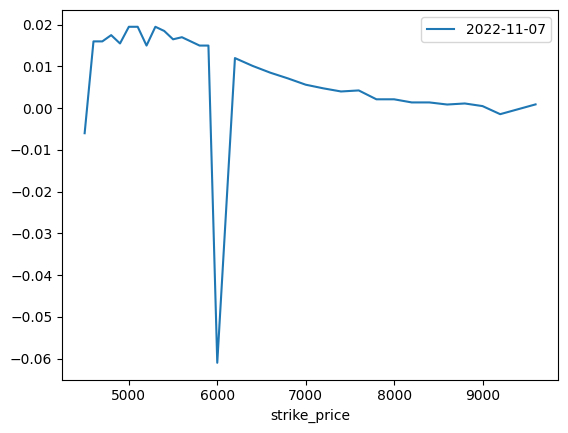

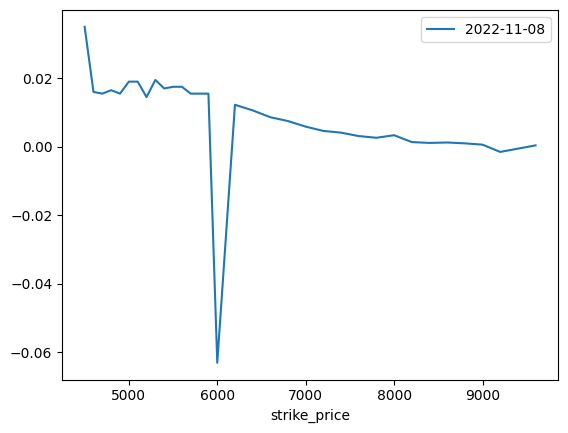

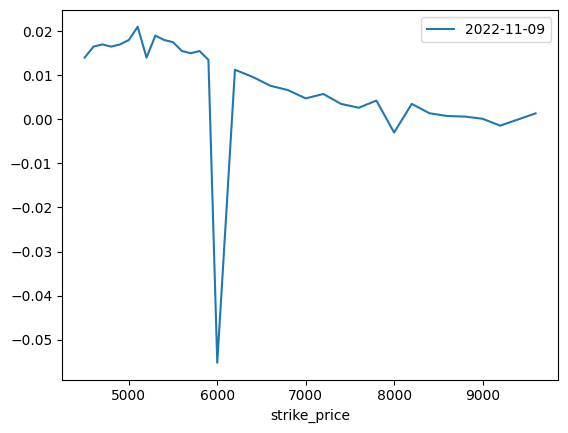

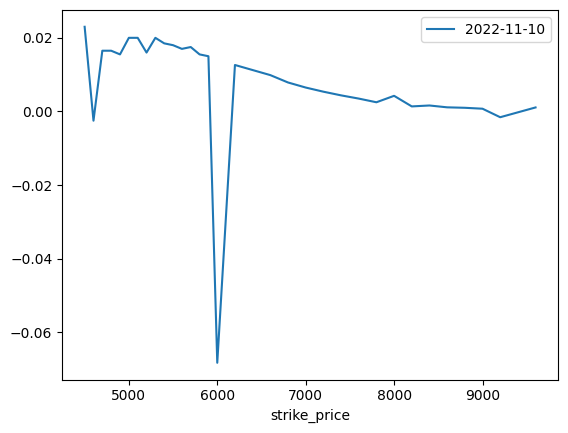

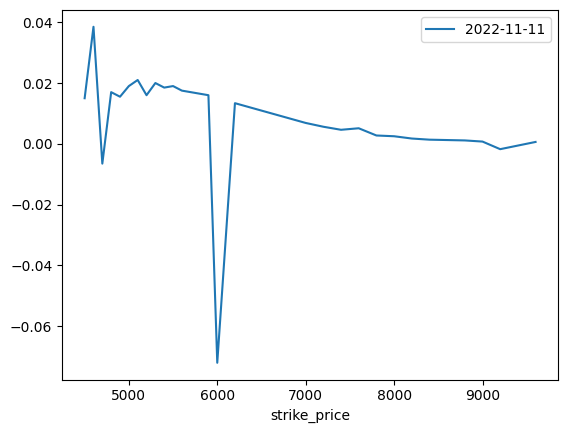

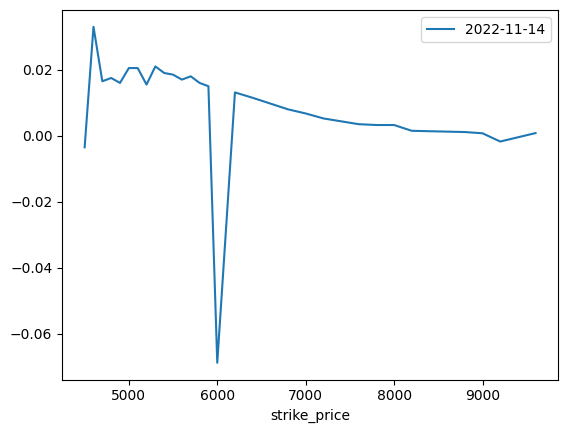

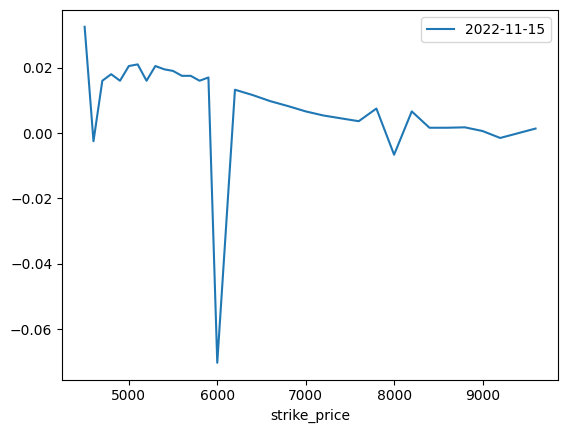

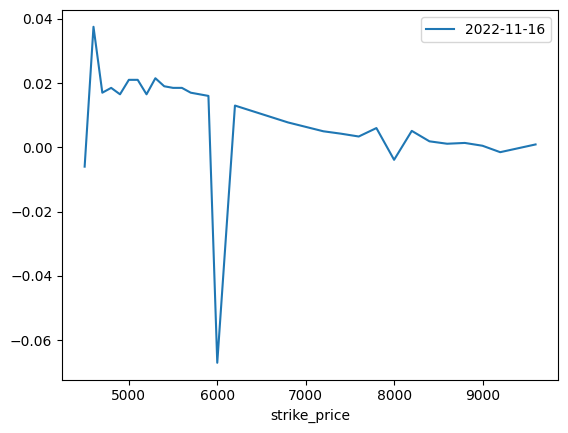

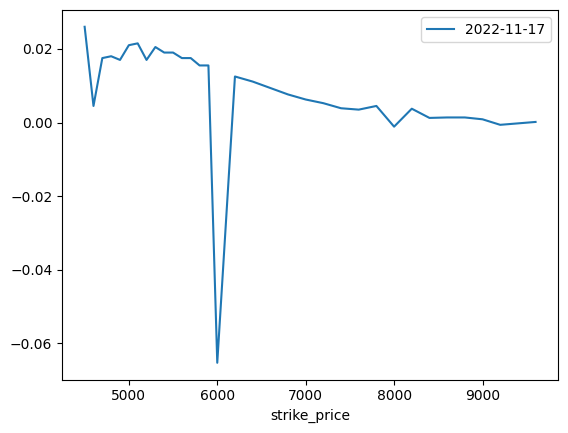

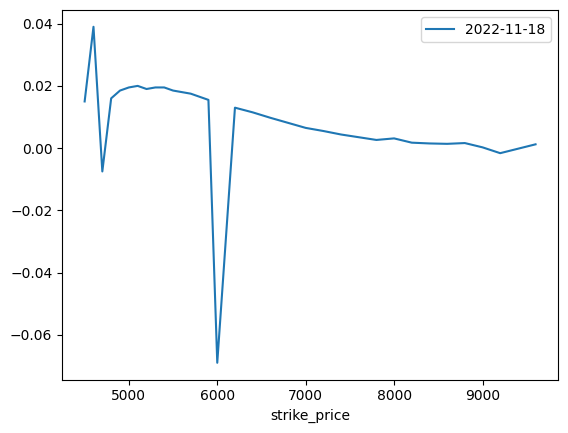

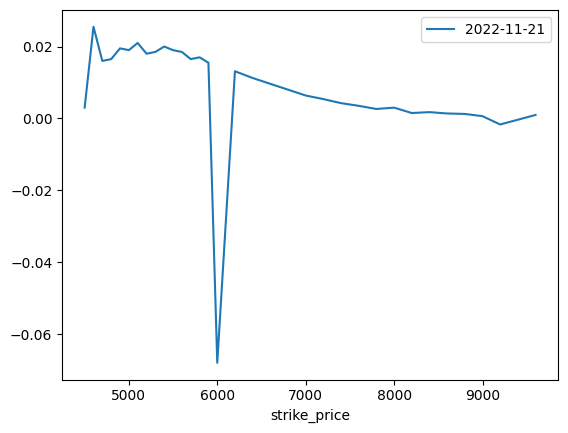

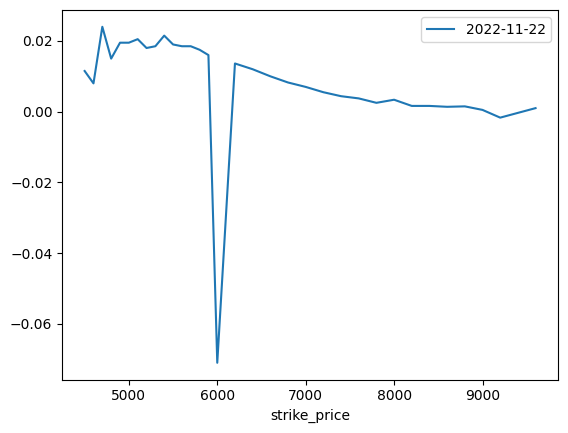

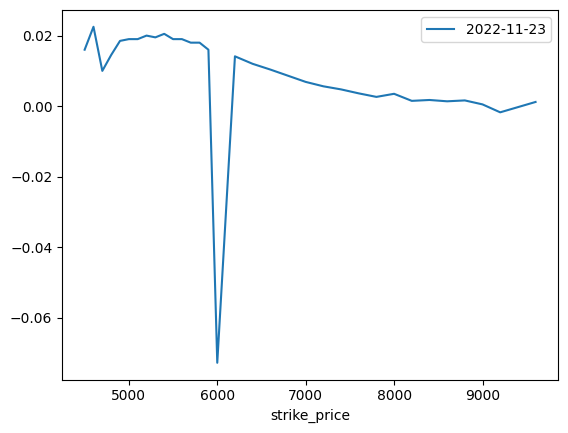

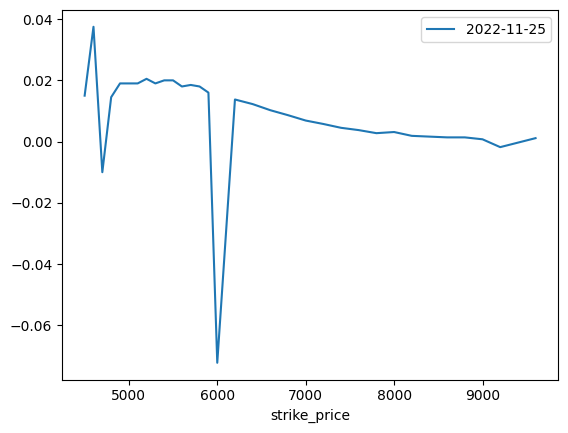

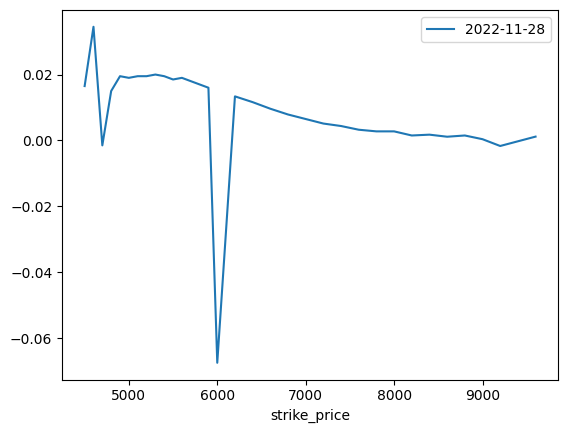

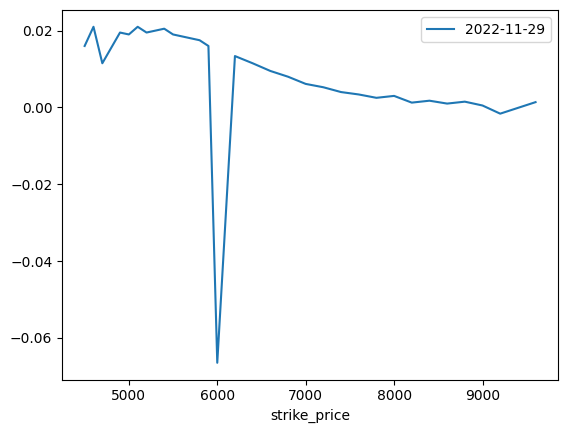

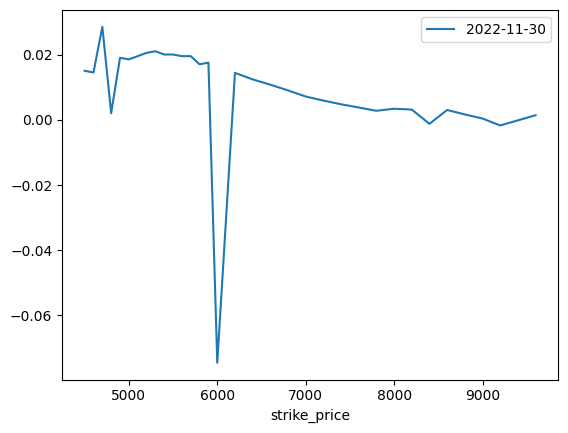

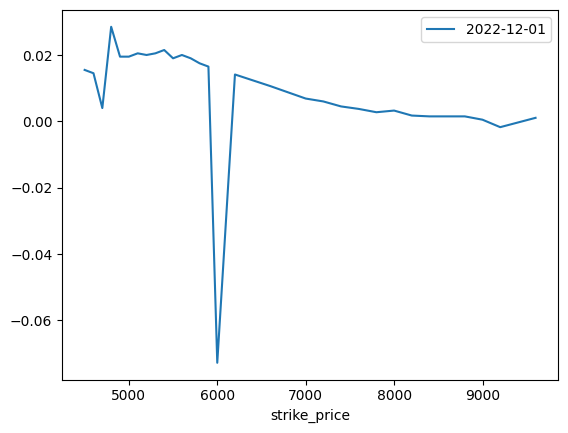

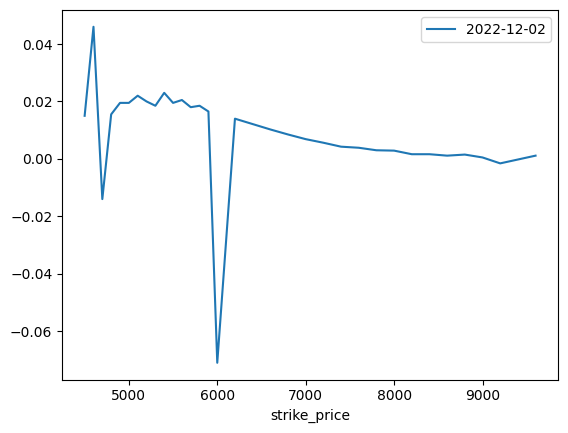

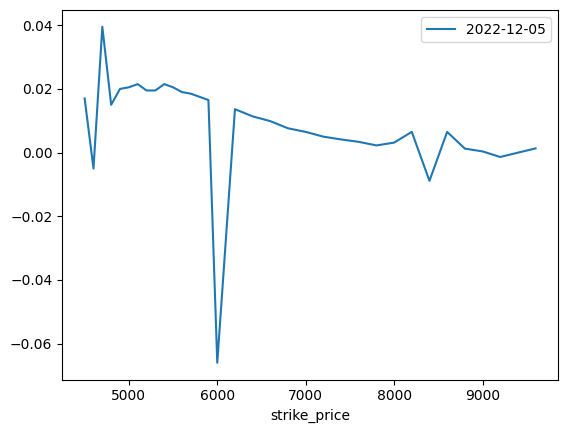

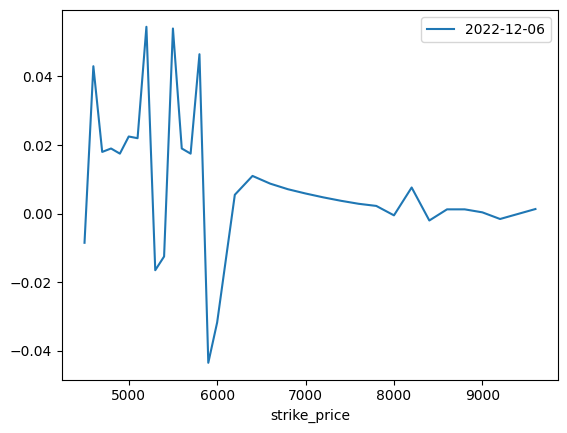

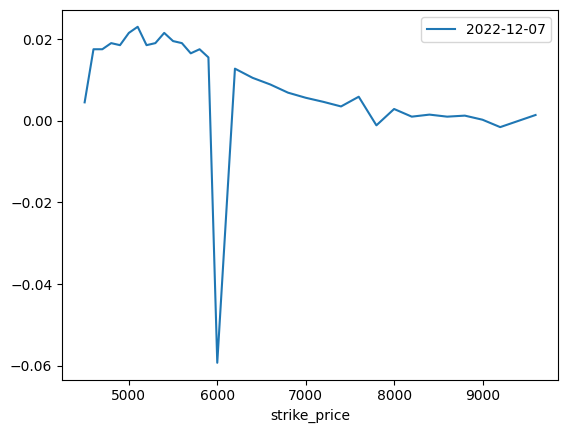

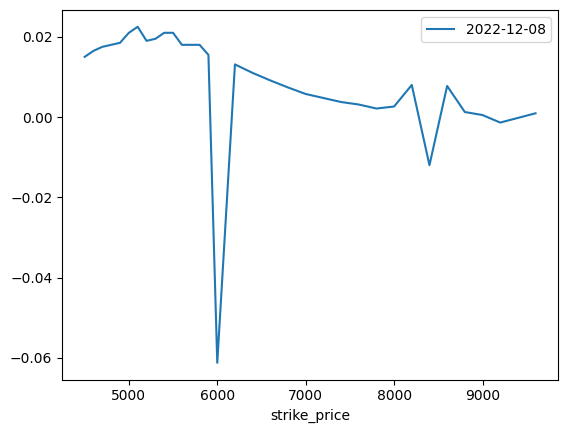

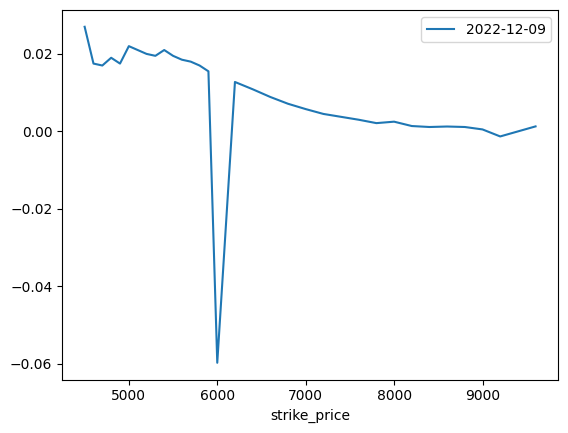

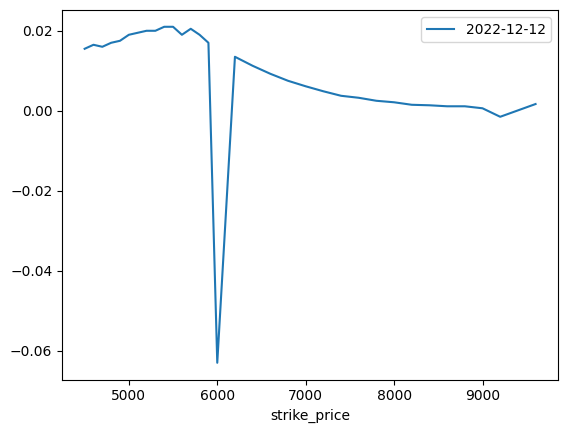

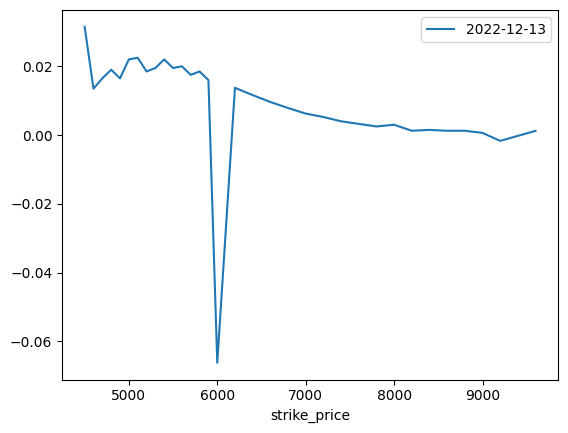

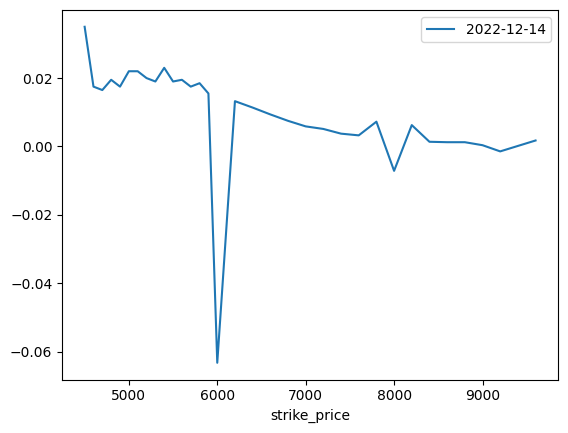

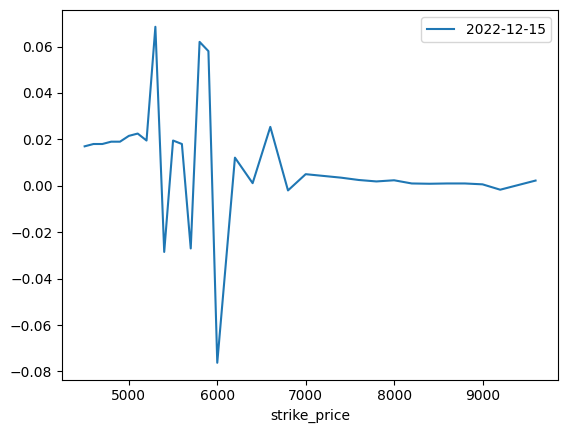

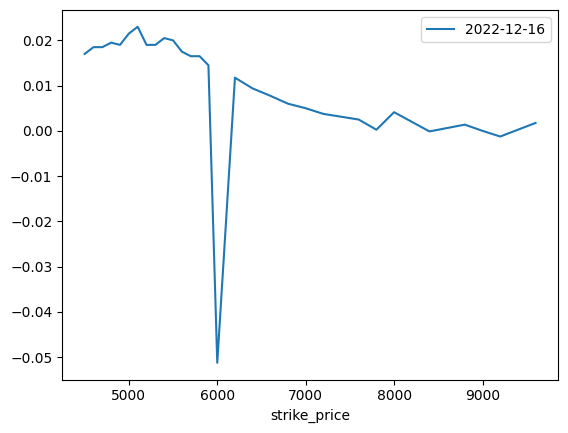

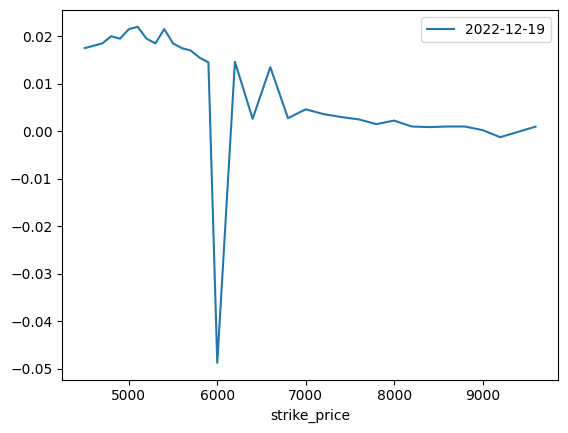

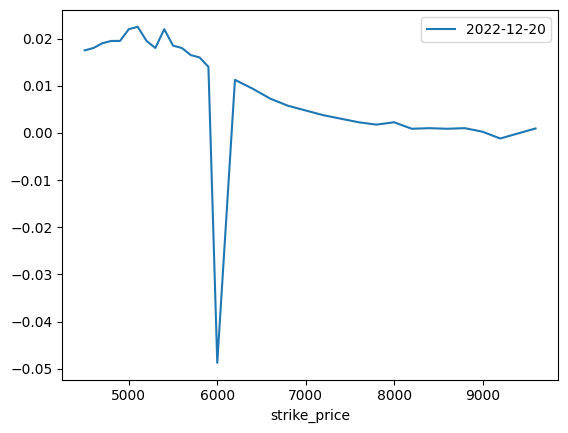

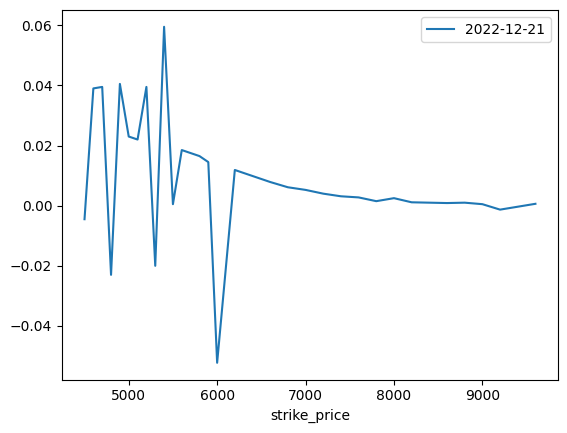

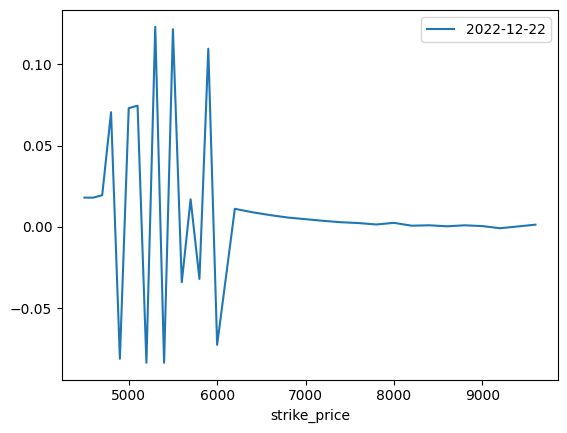

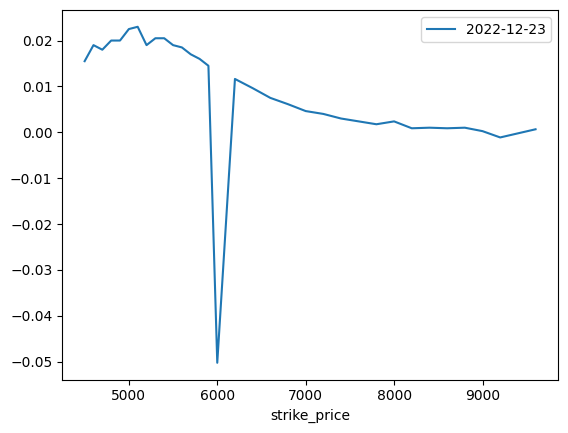

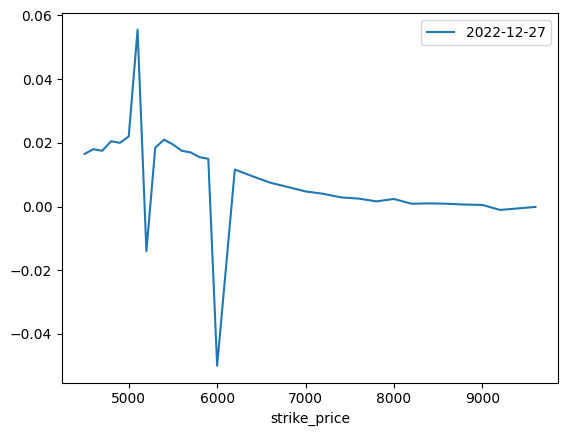

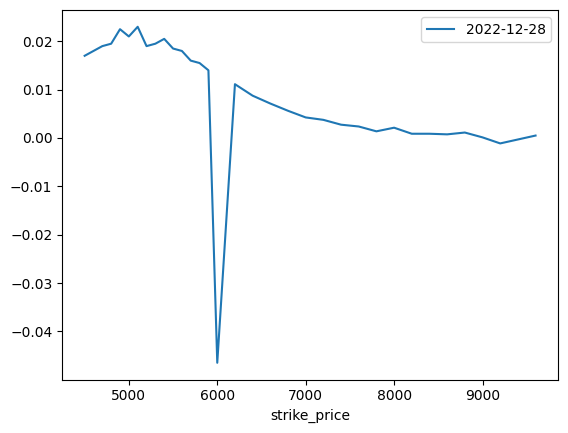

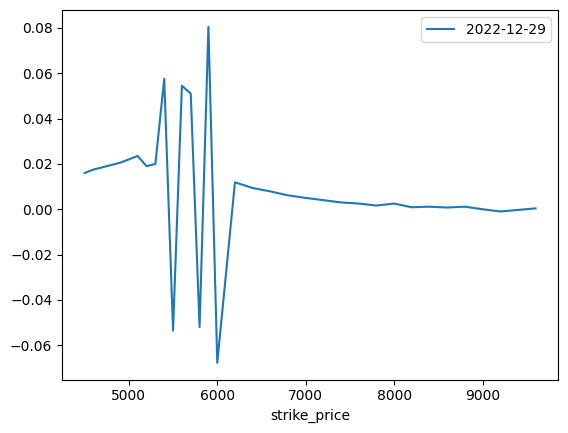

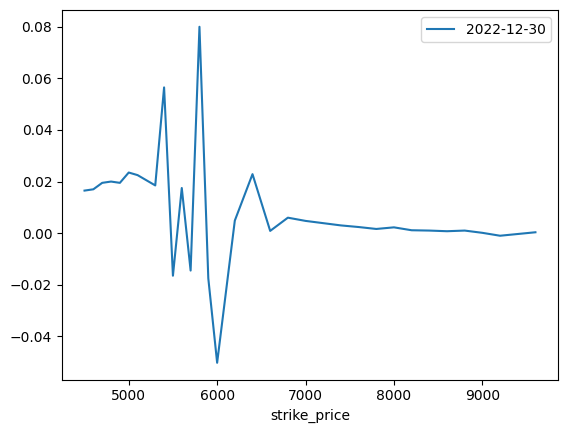

In [8]:
grouped = options_data_spx.groupby('date')
for name, group in grouped:
    group.plot(y='Risk_Neutral_Probability', x='strike_price', kind='line', label=name)


In [6]:
grouped = options_data_spx.groupby('date')

/usr/local/lib/python3.10/dist-packages/pandas/plotting/_matplotlib/core.py:512: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = self.plt.figure(figsize=self.figsize)


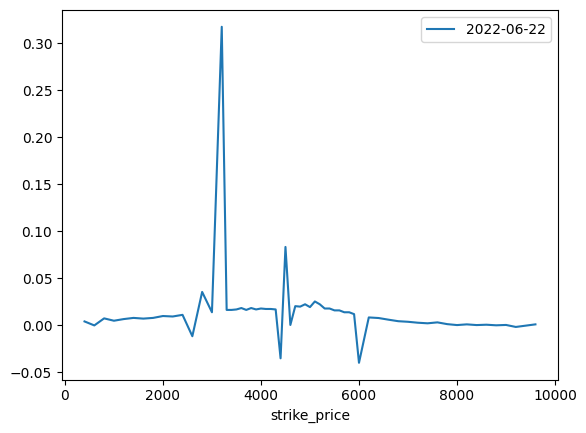

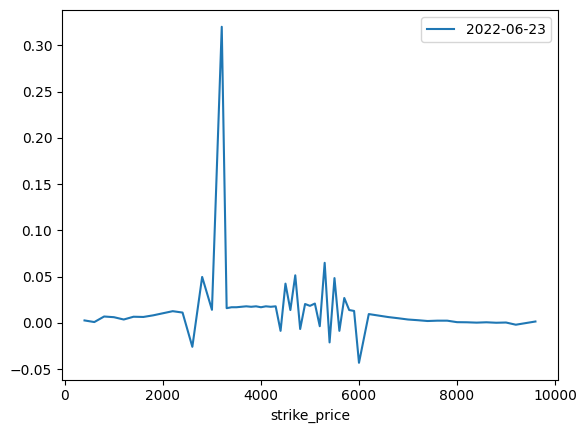

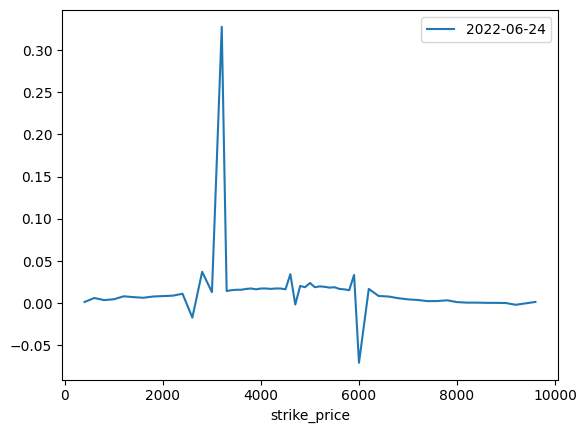

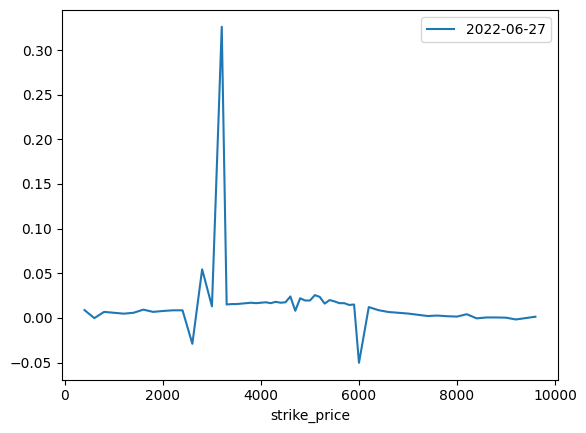

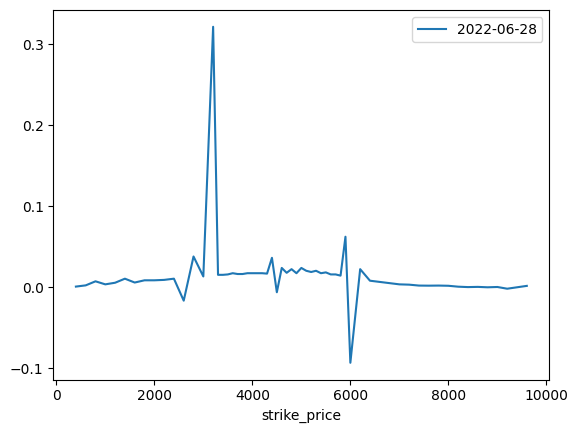

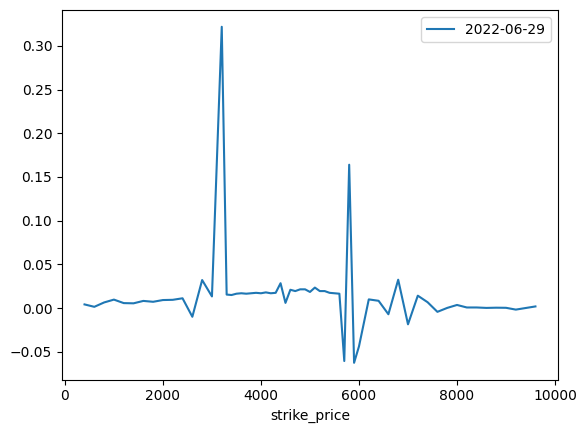

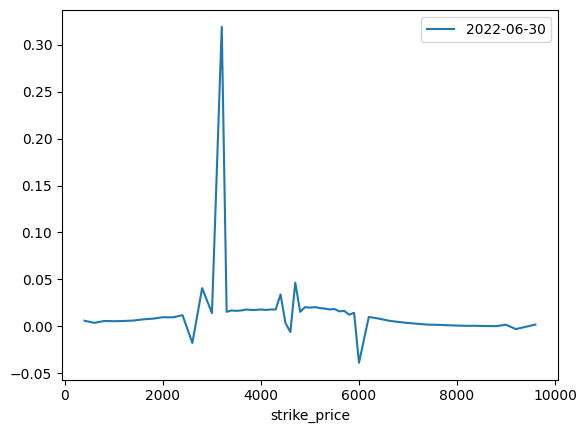

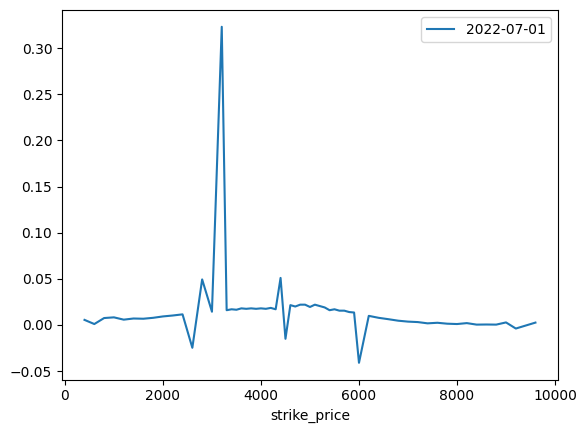

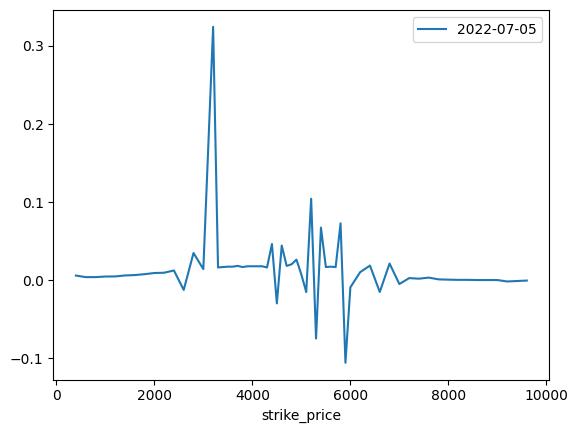

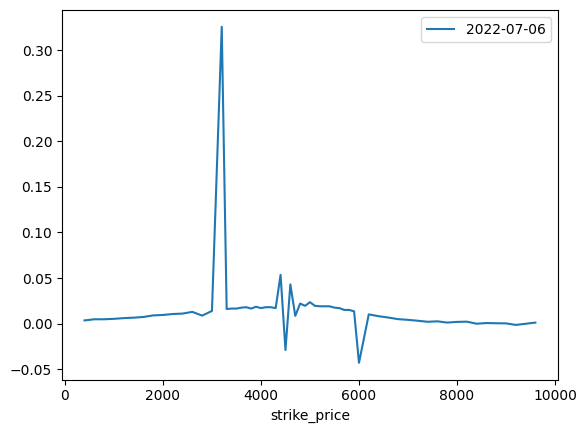

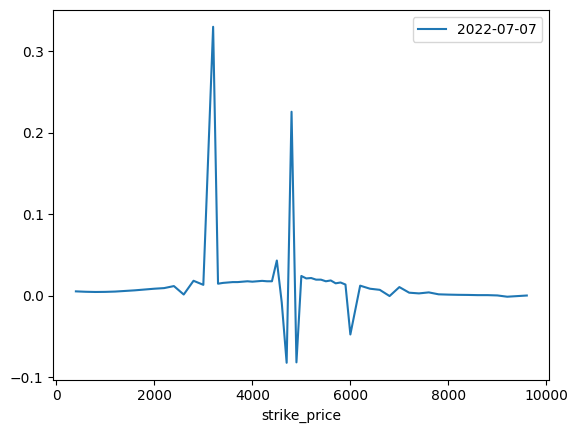

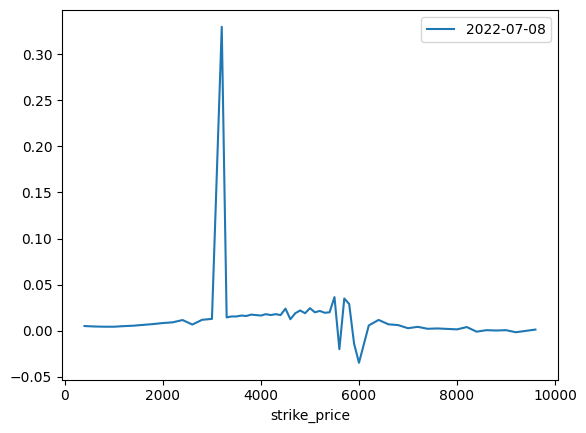

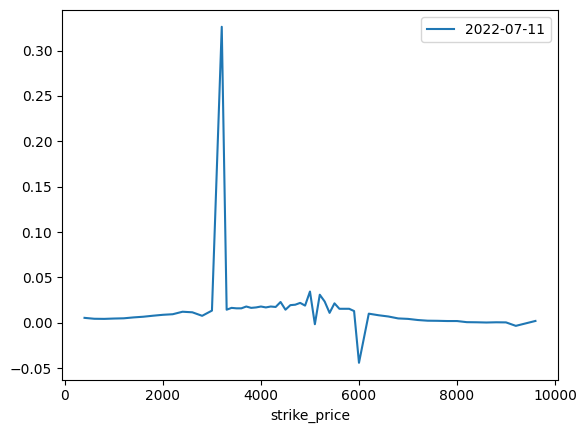

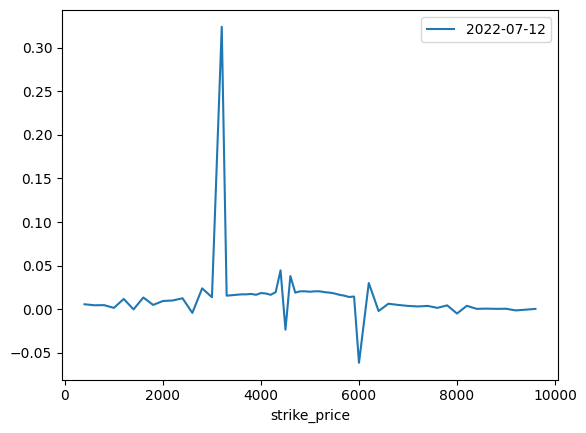

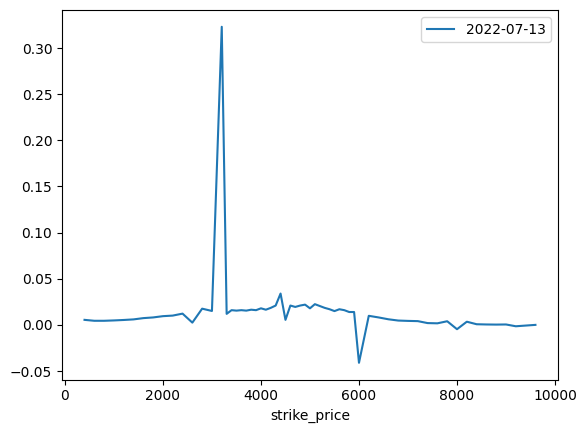

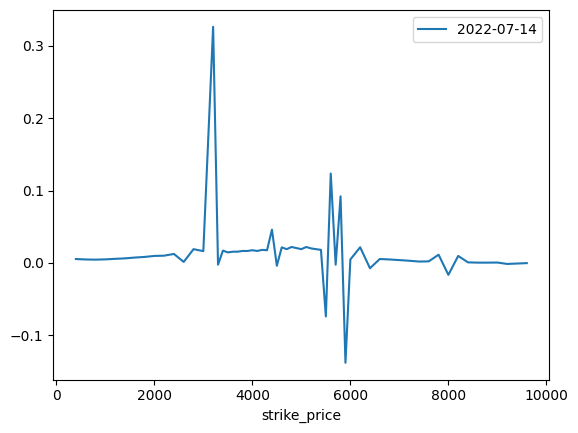

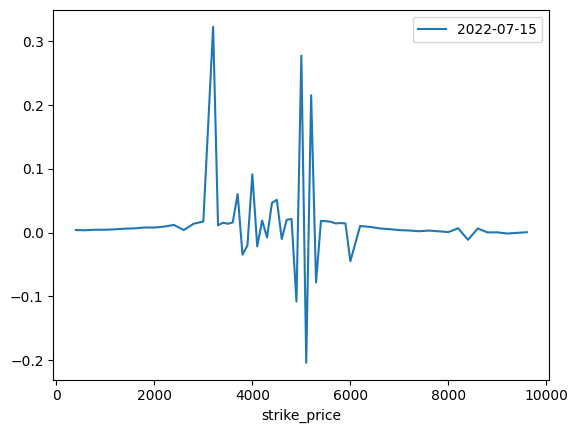

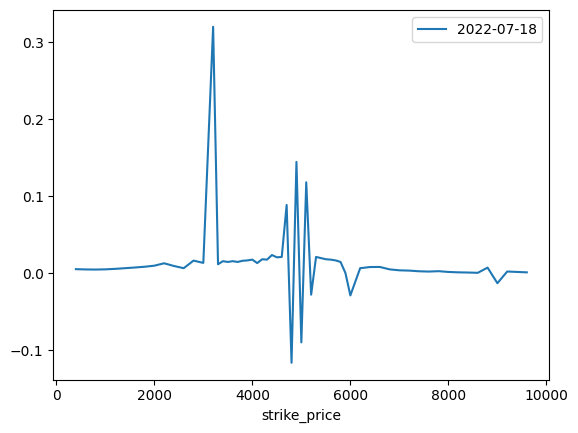

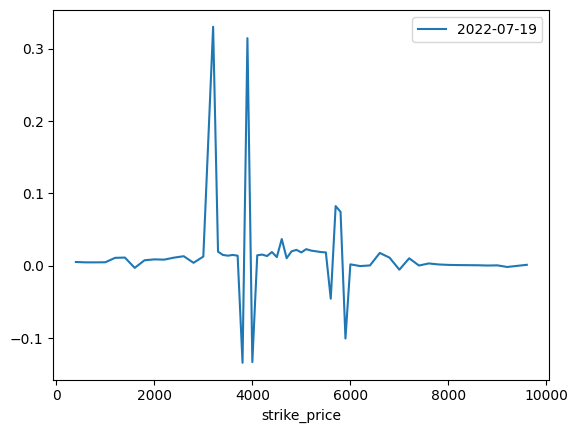

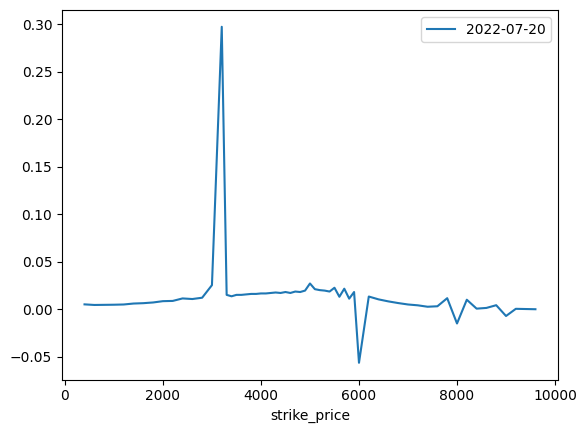

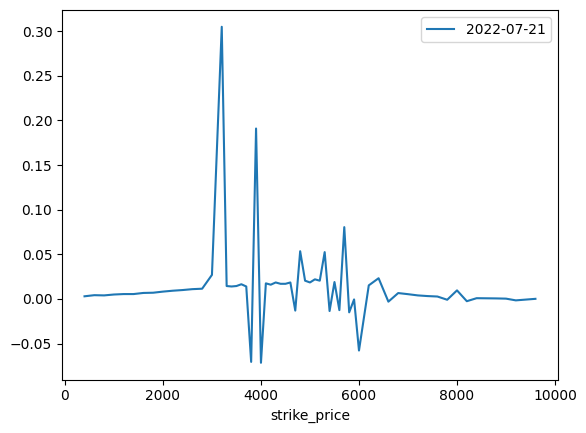

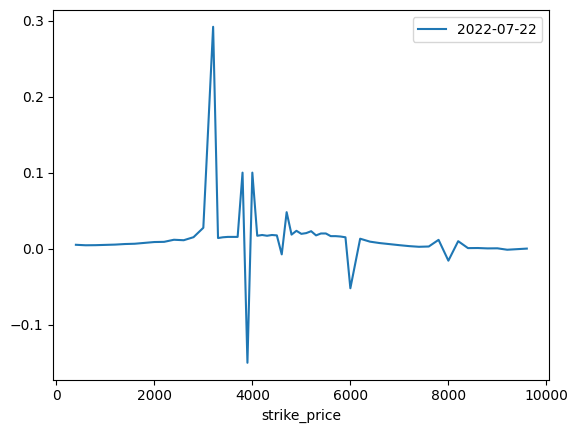

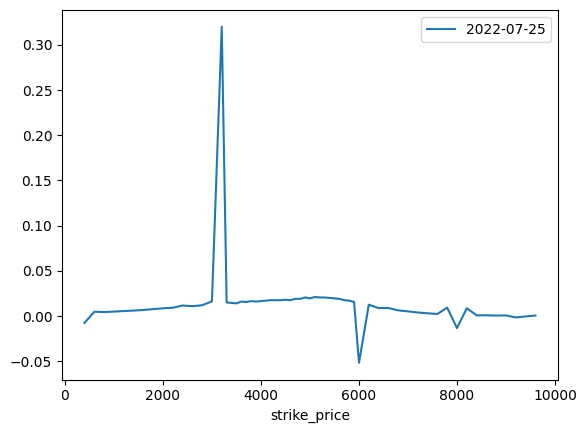

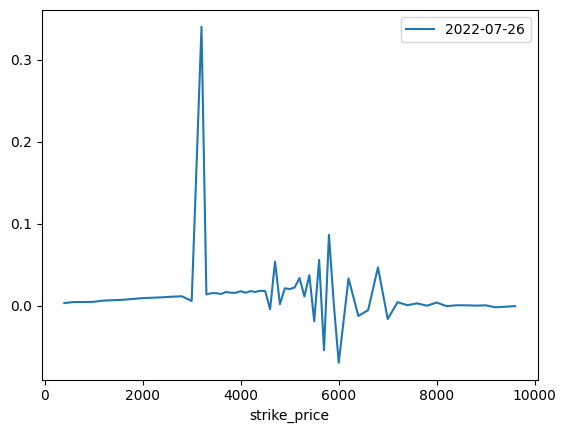

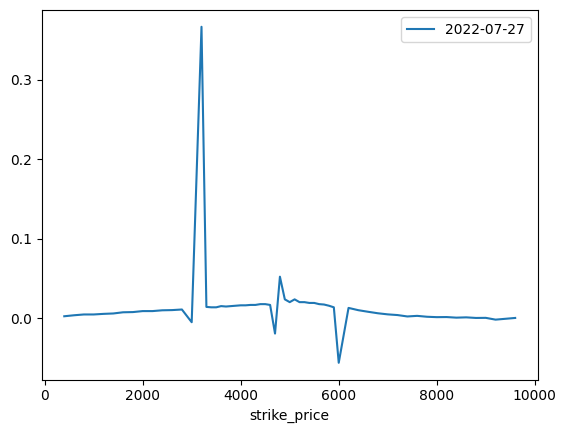

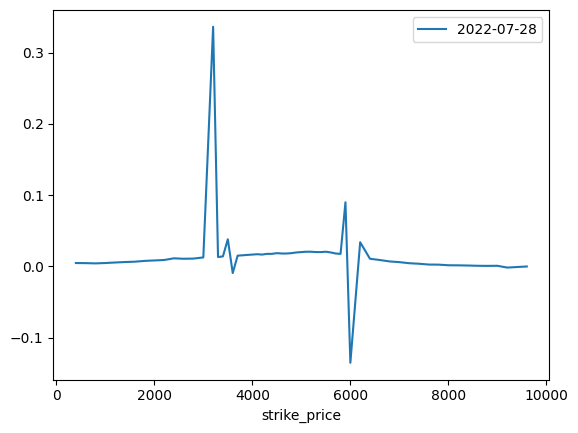

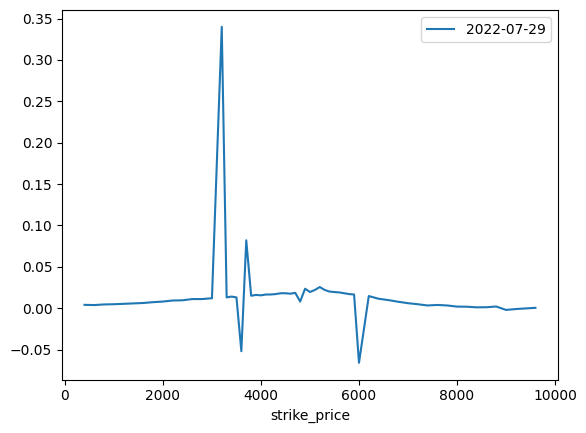

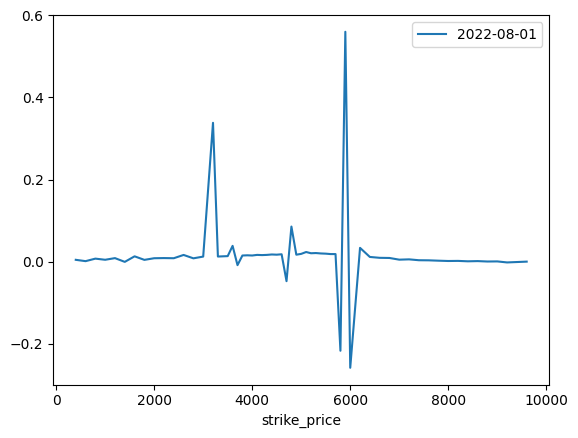

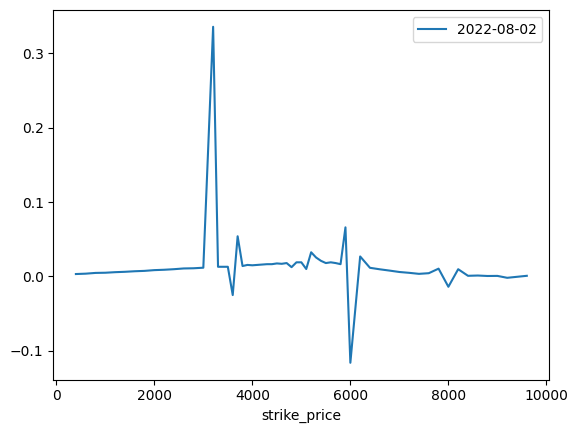

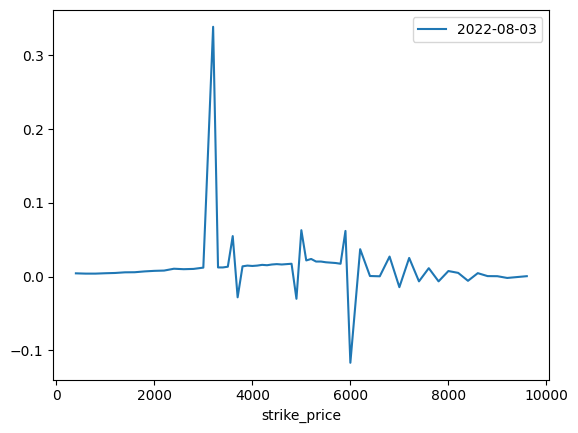

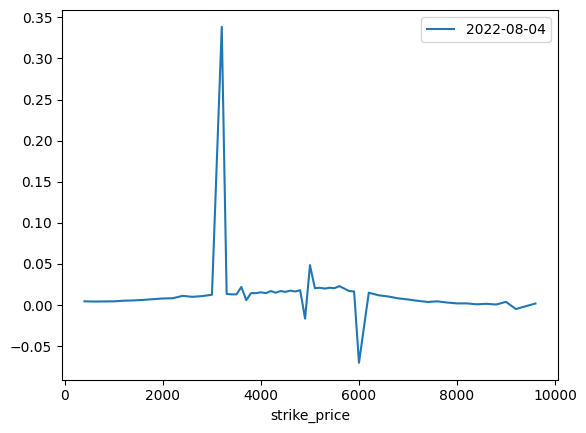

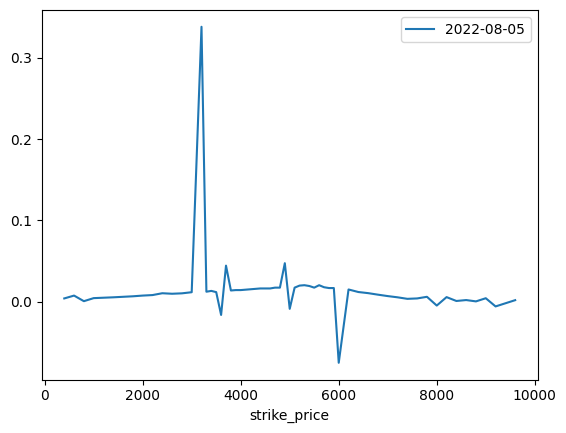

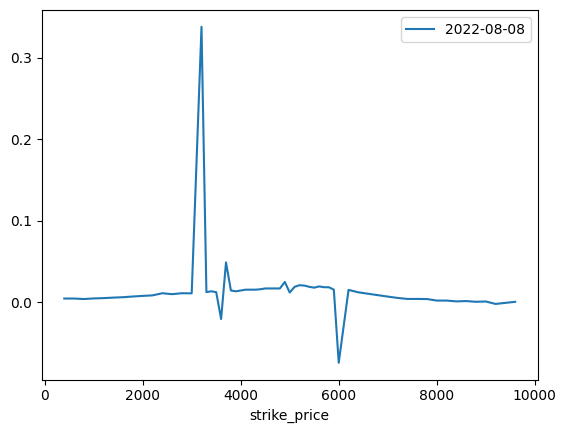

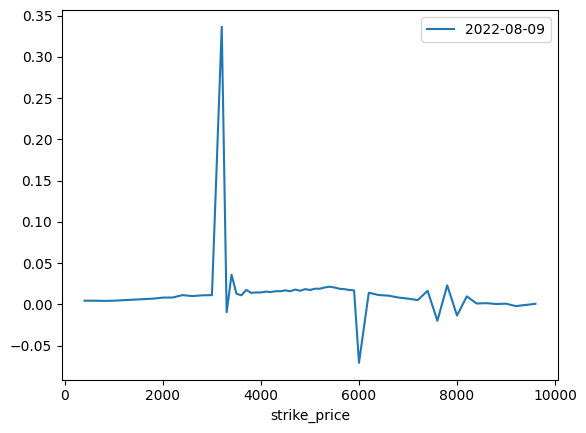

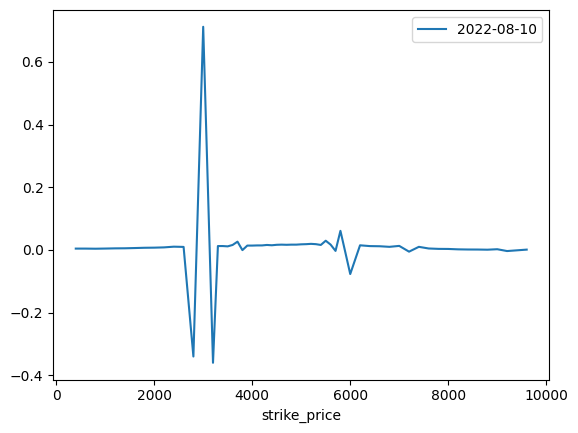

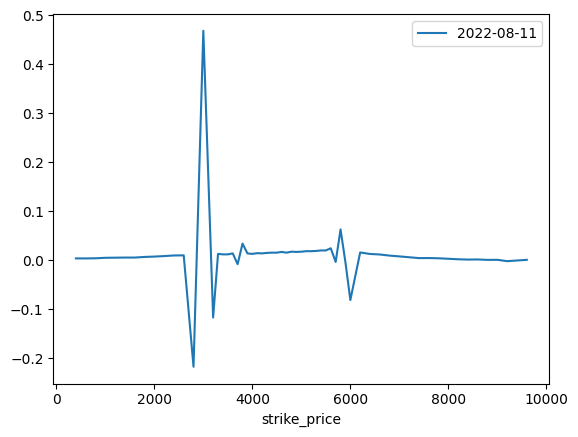

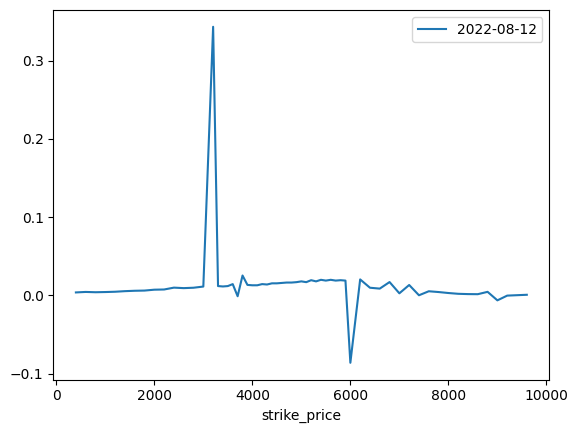

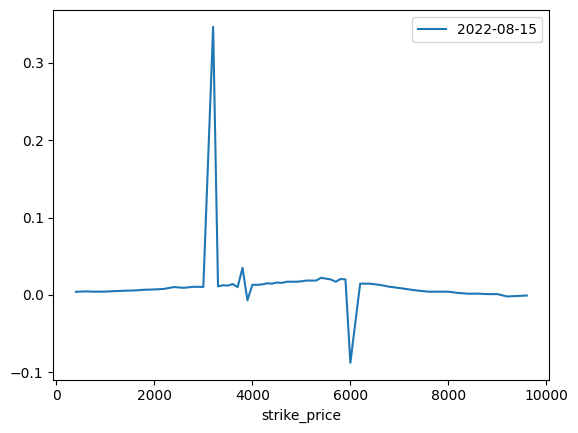

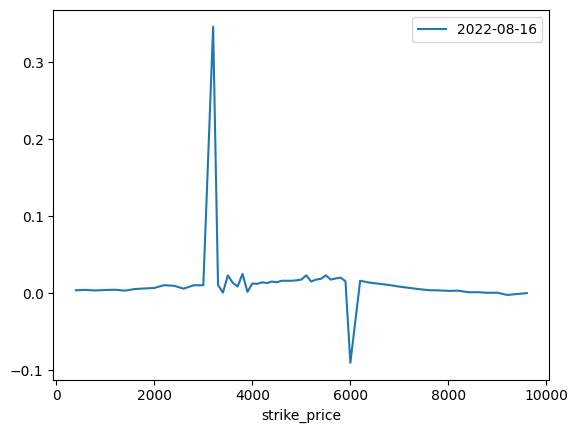

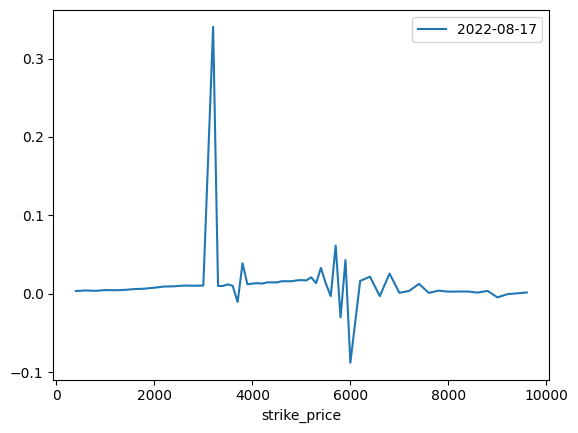

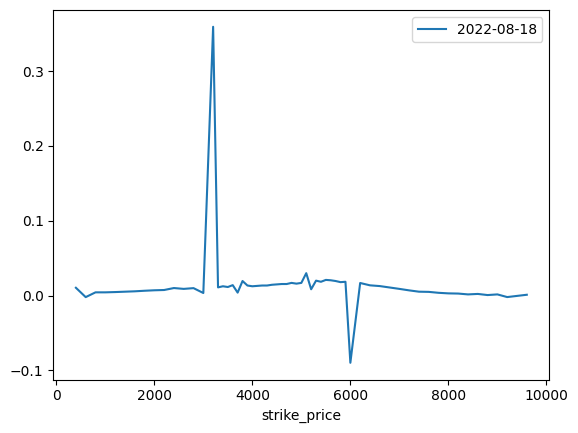

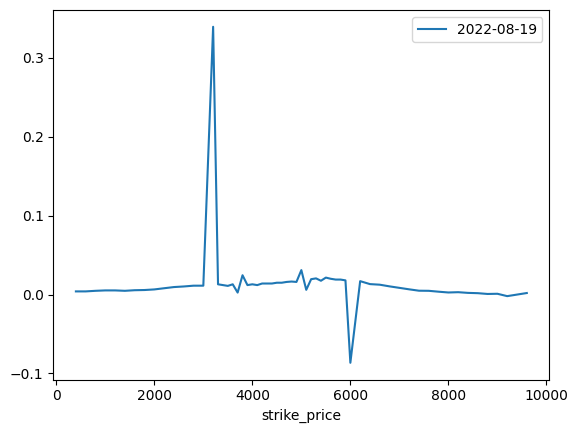

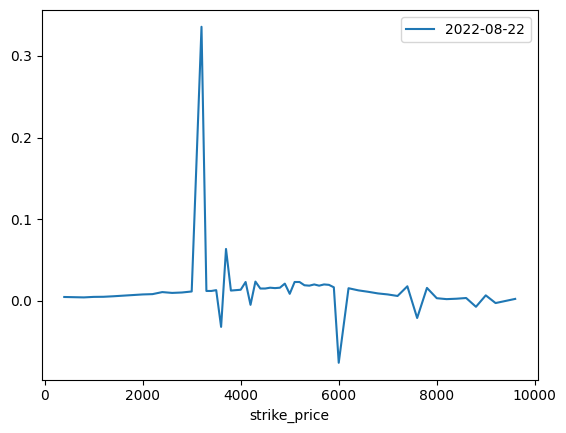

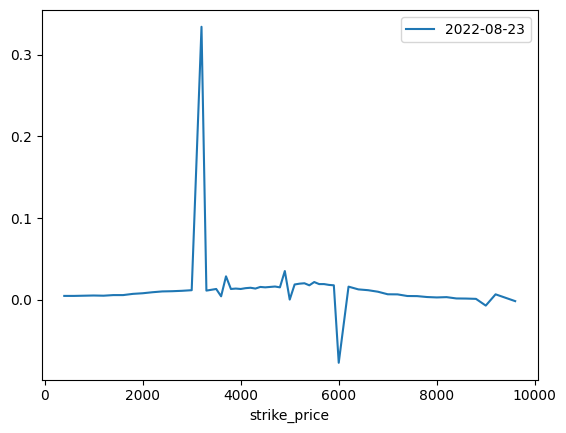

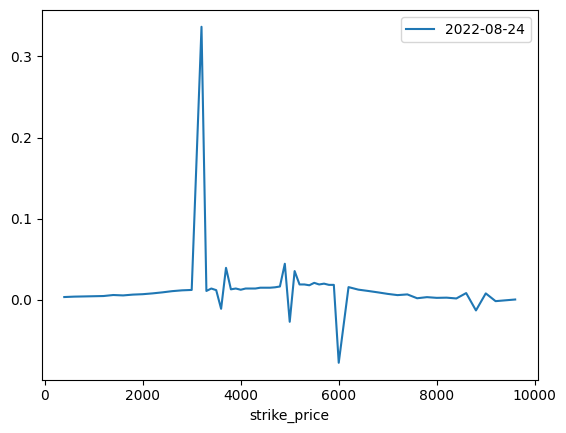

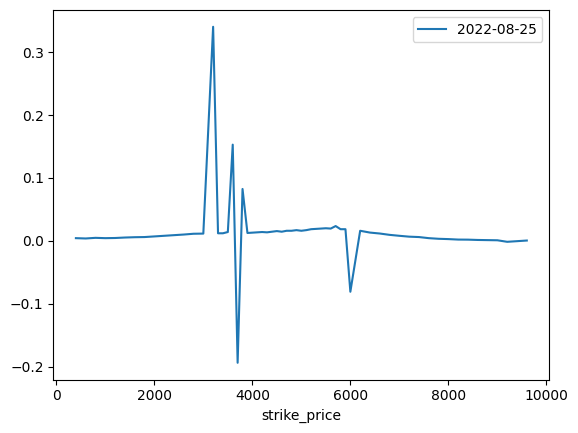

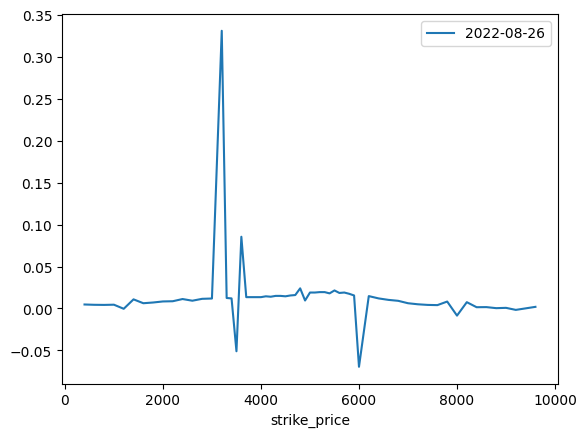

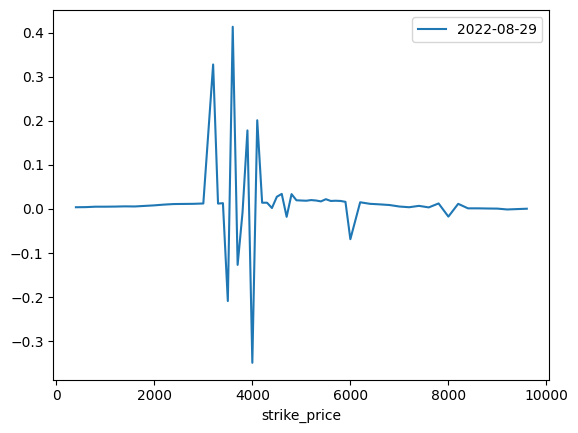

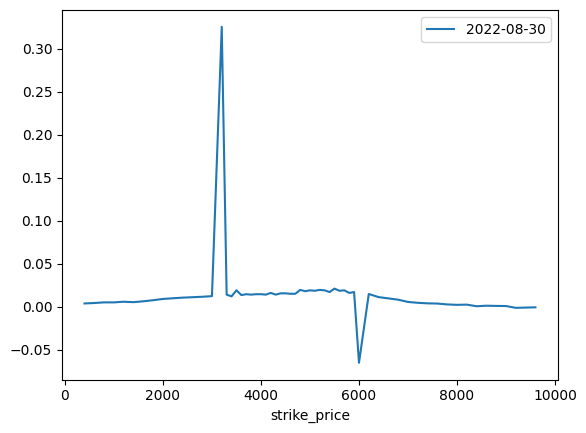

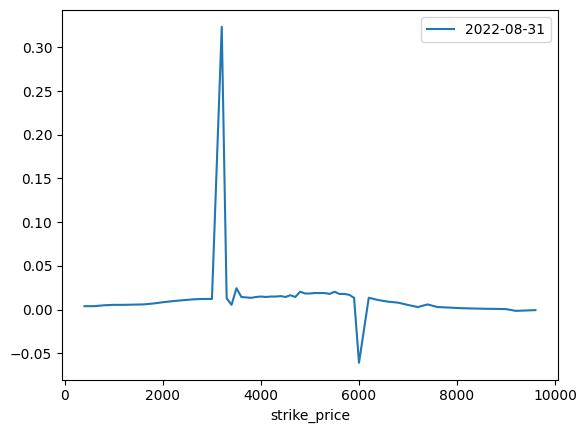

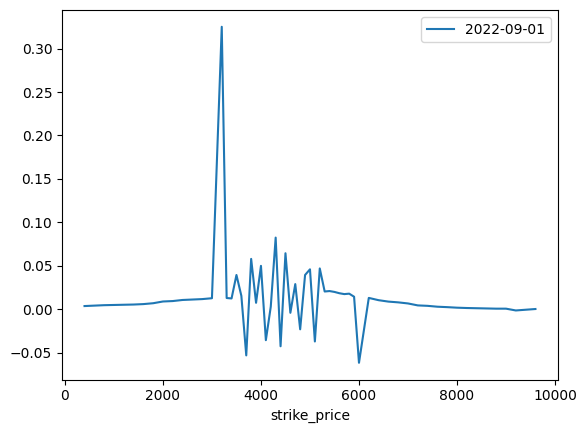

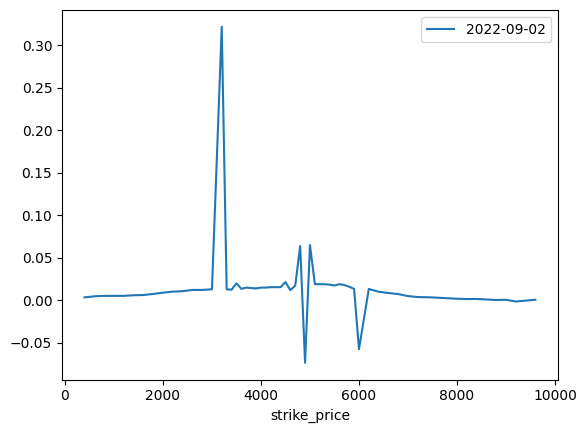

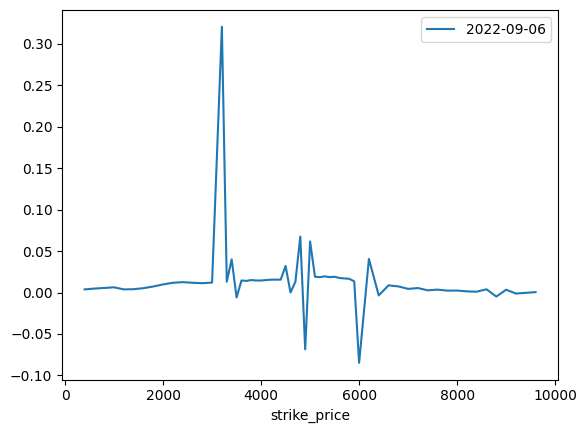

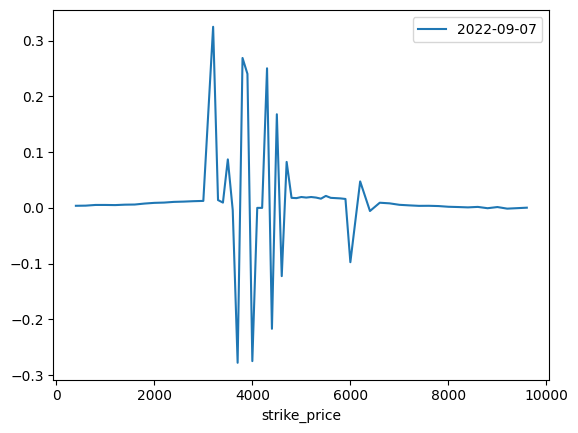

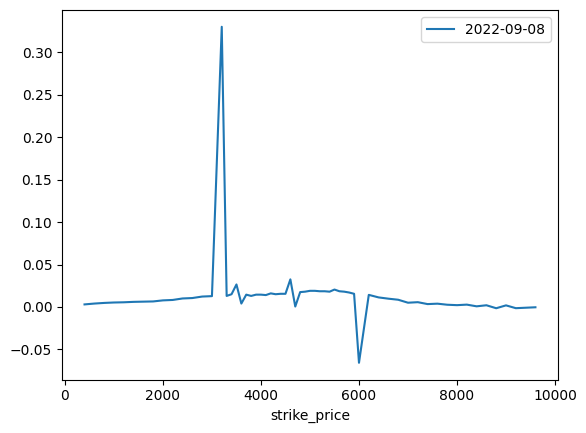

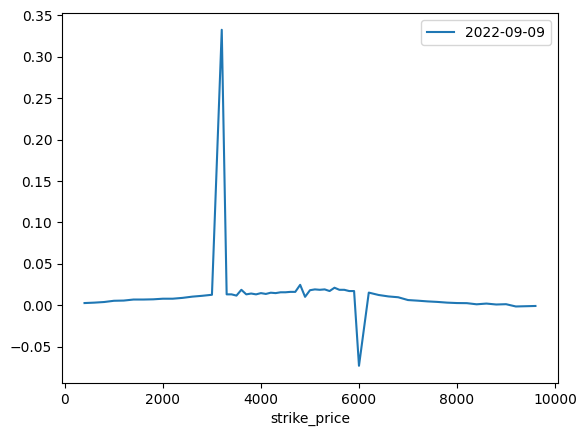

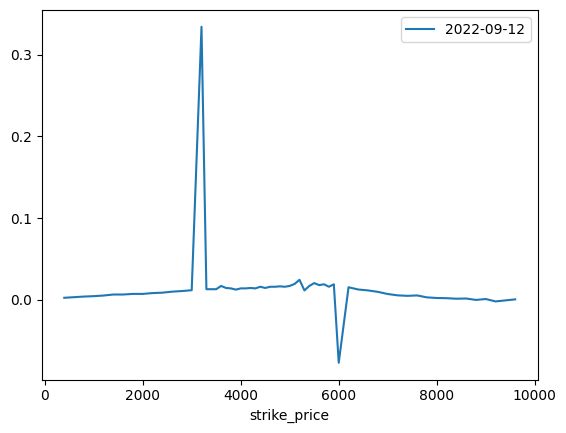

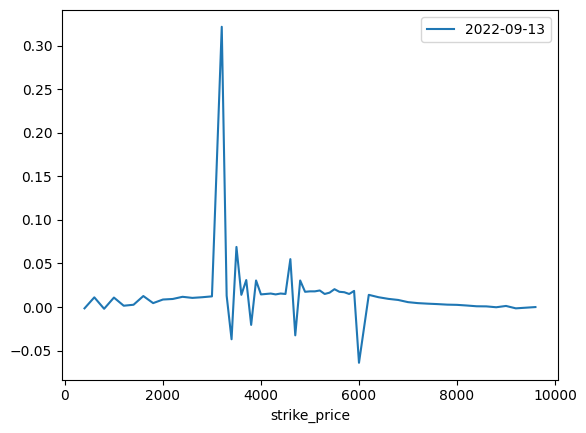

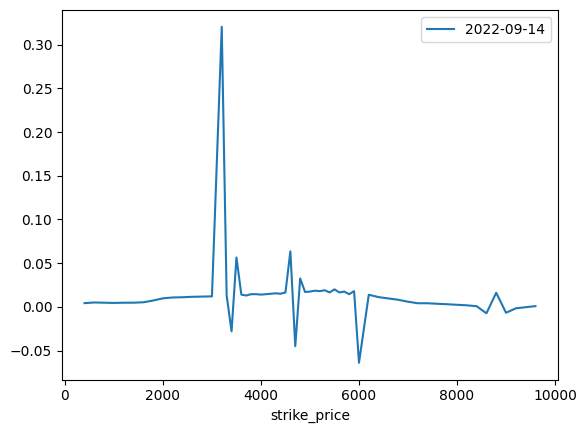

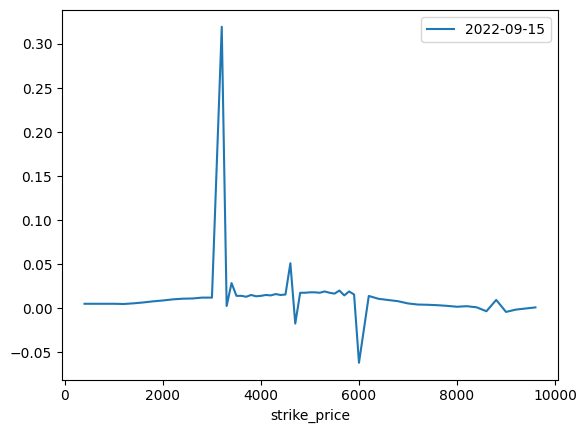

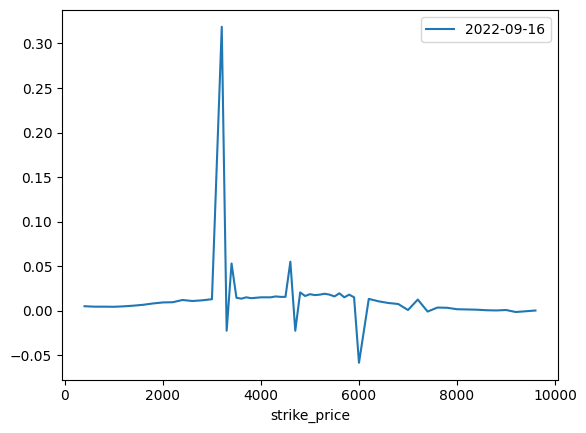

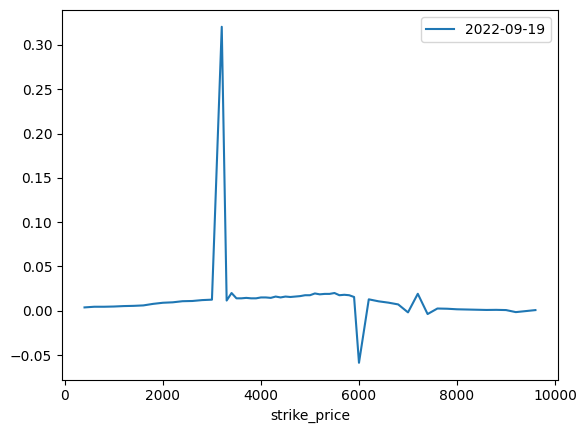

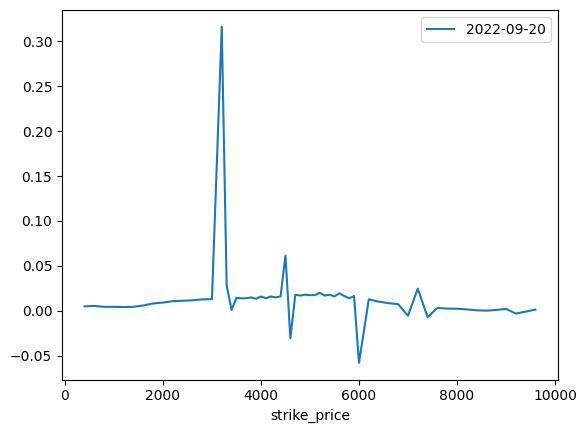

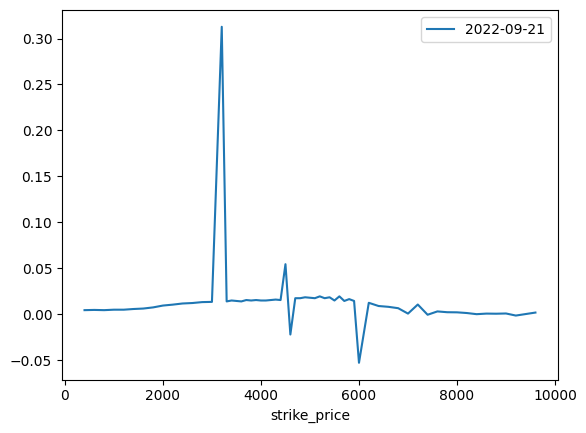

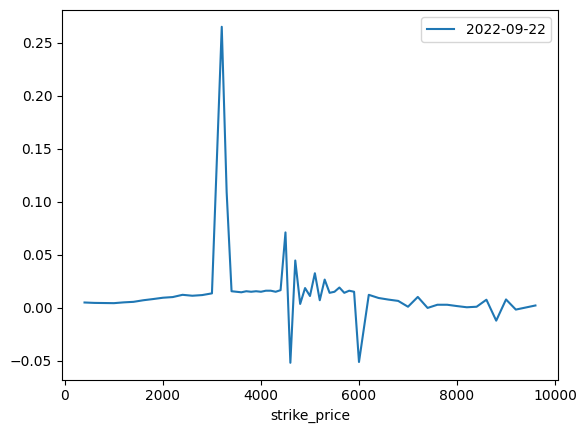

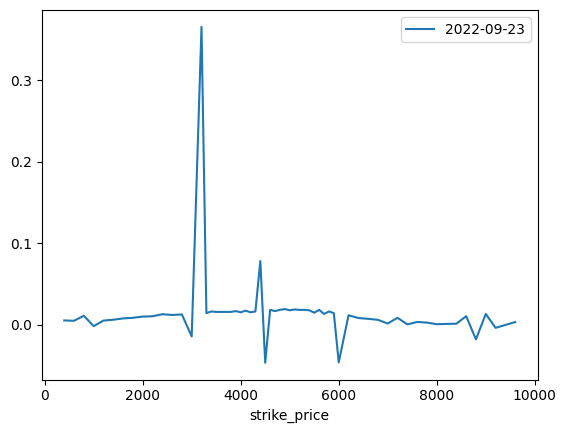

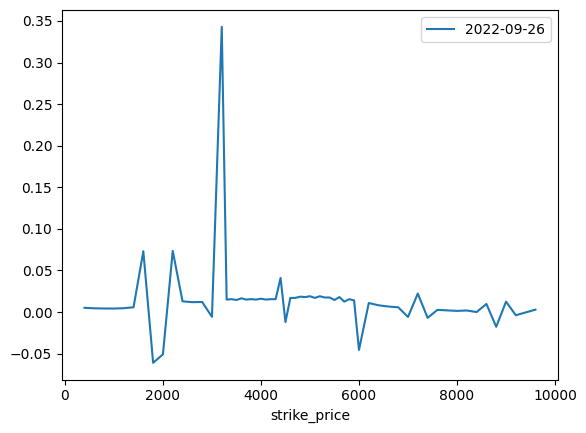

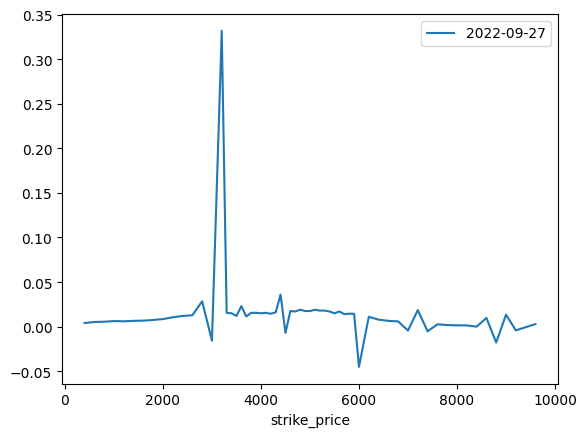

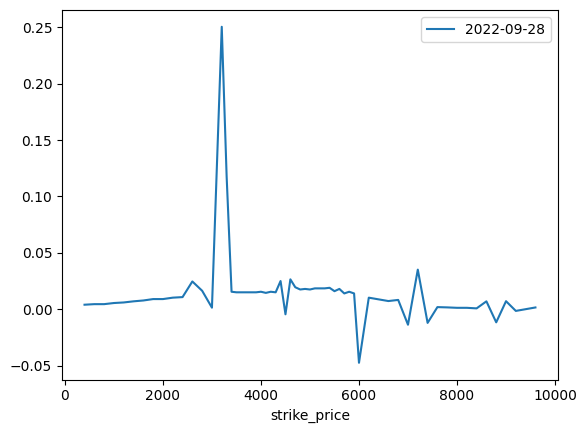

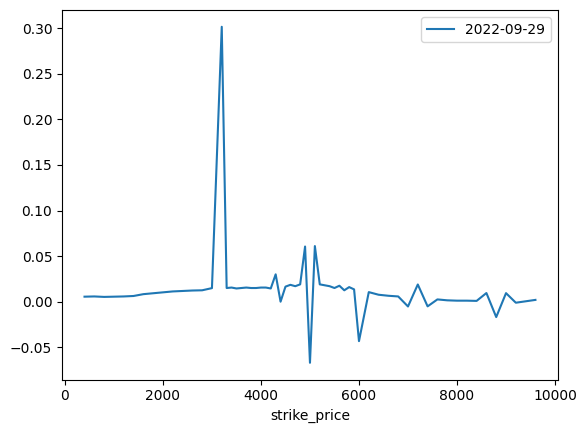

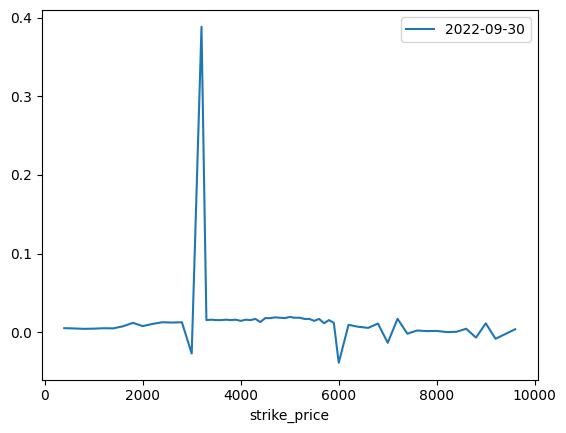

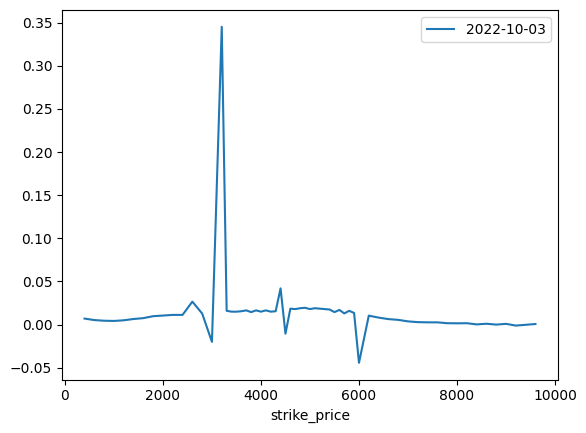

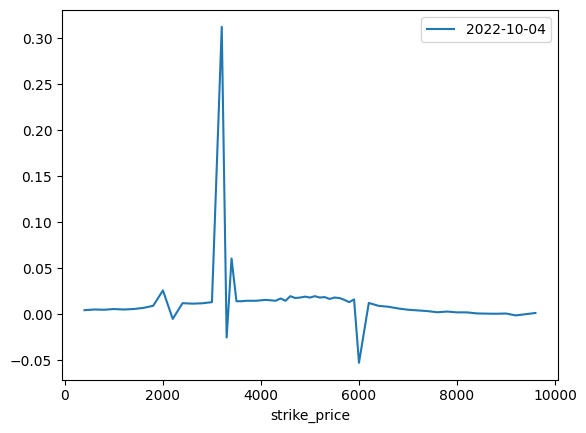

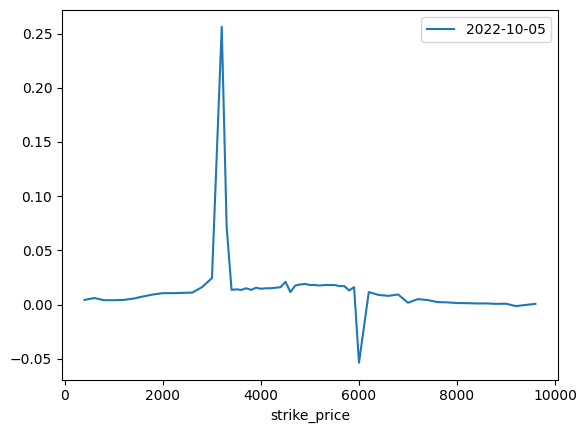

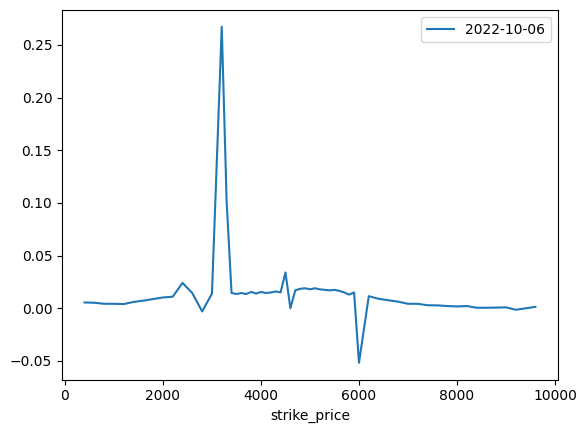

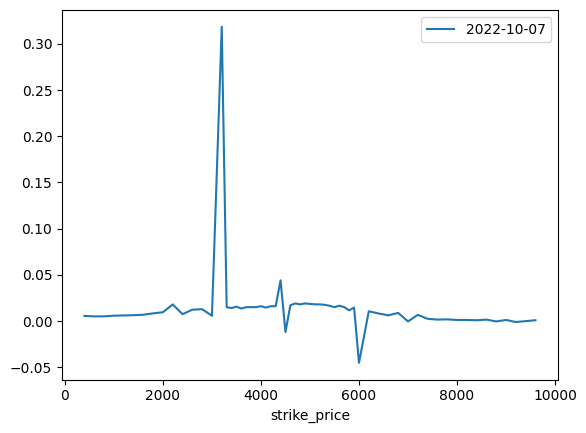

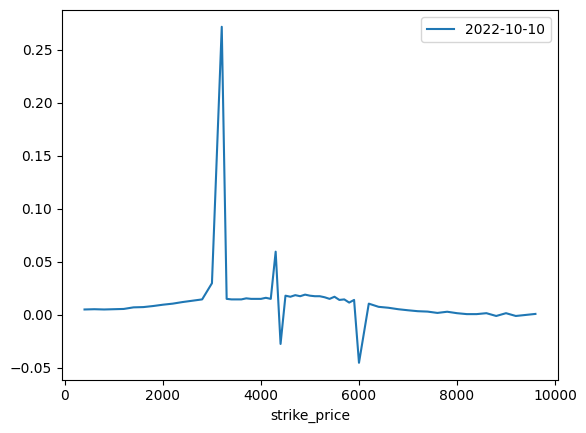

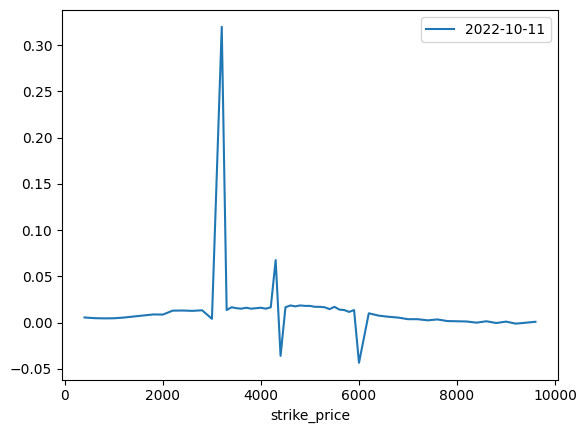

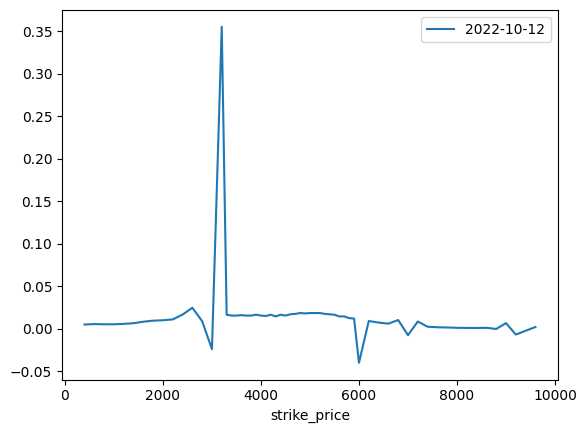

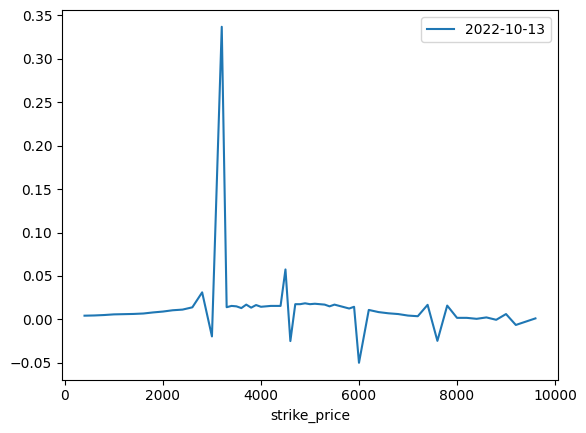

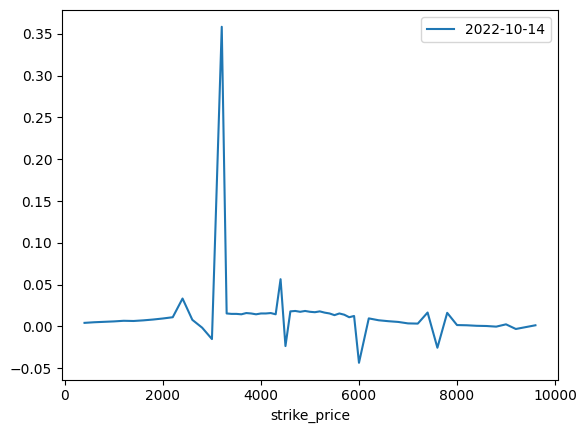

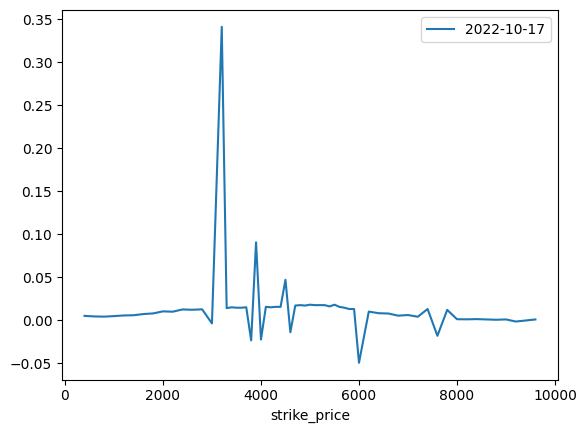

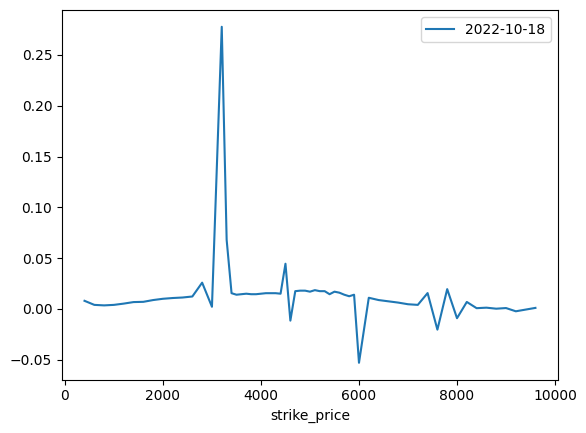

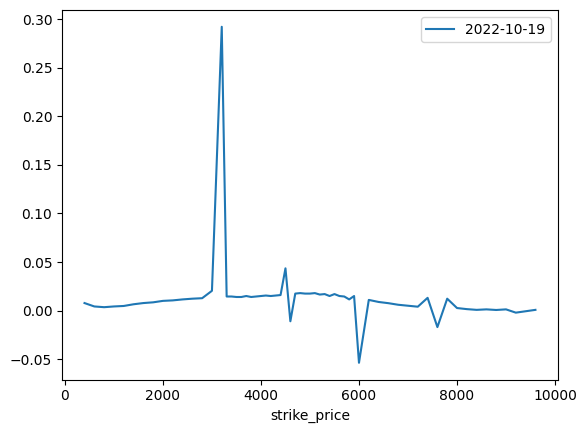

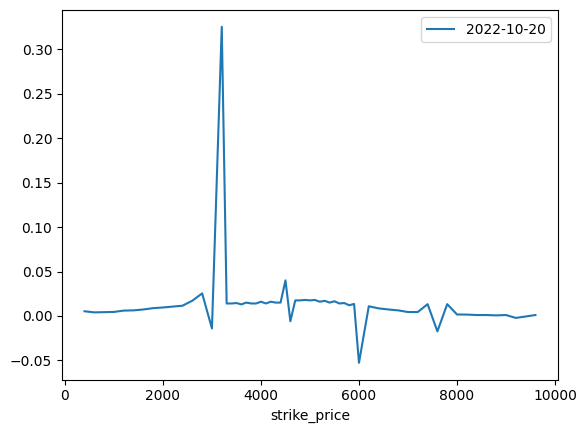

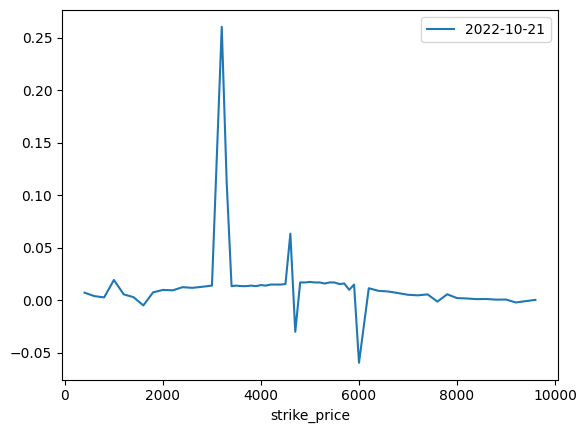

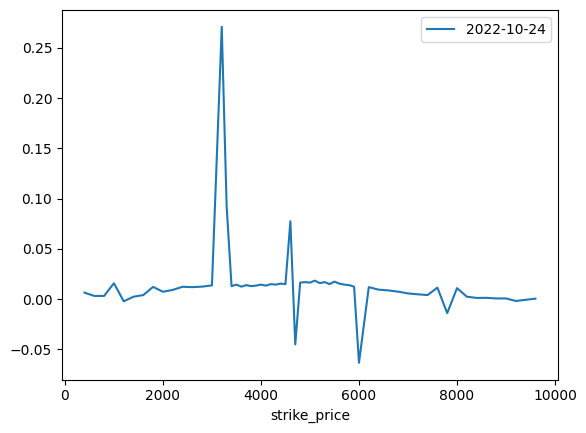

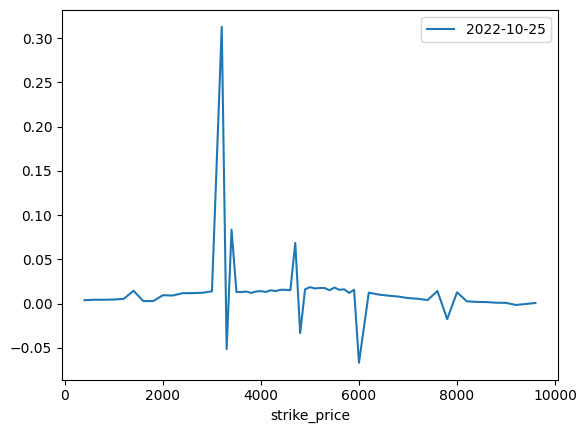

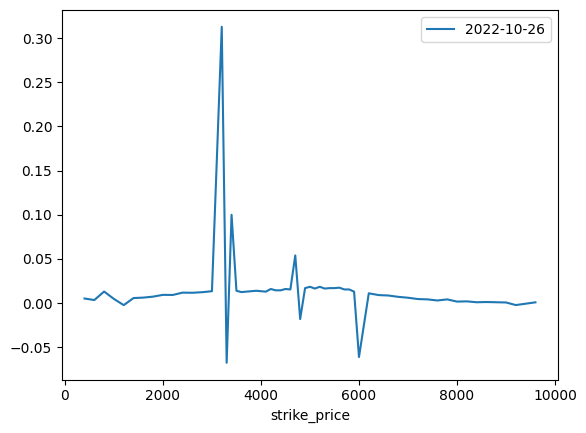

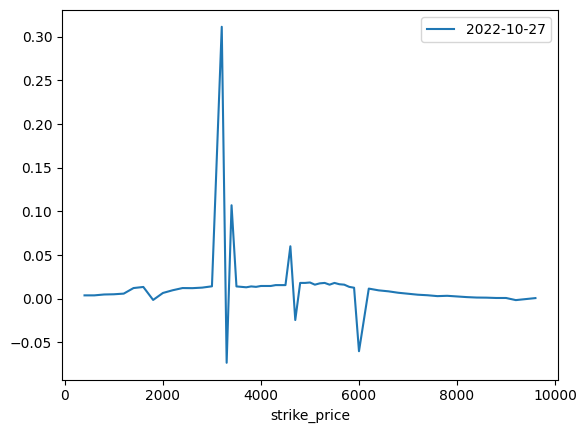

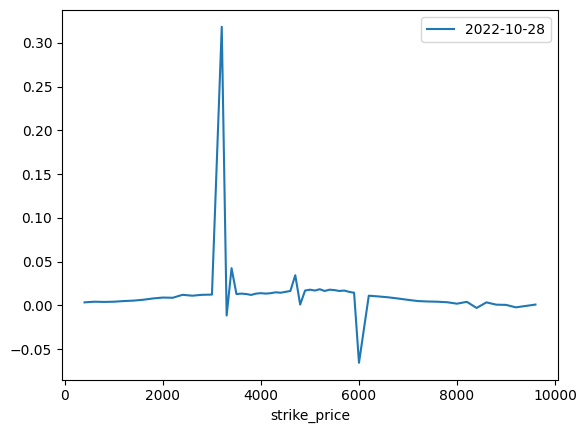

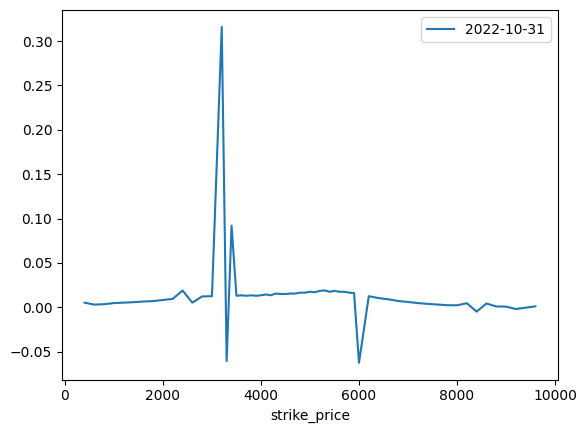

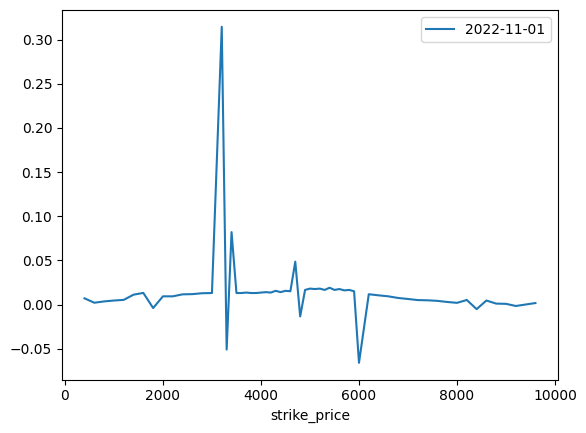

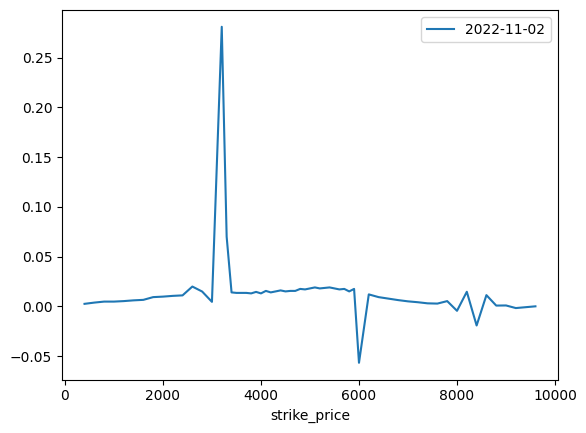

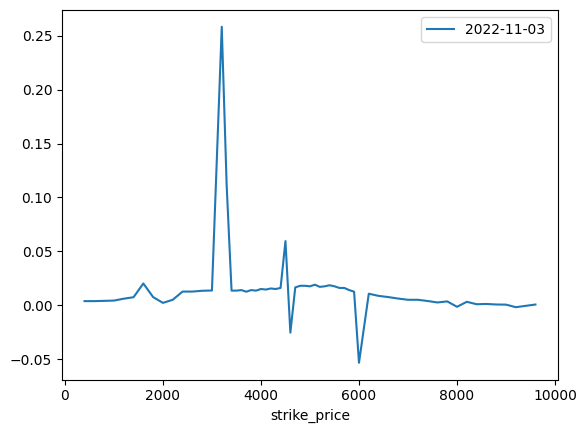

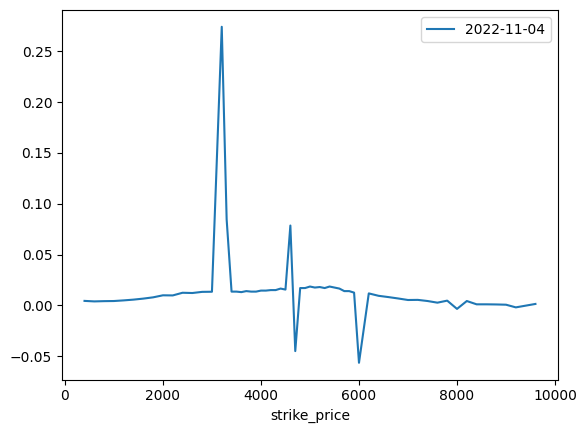

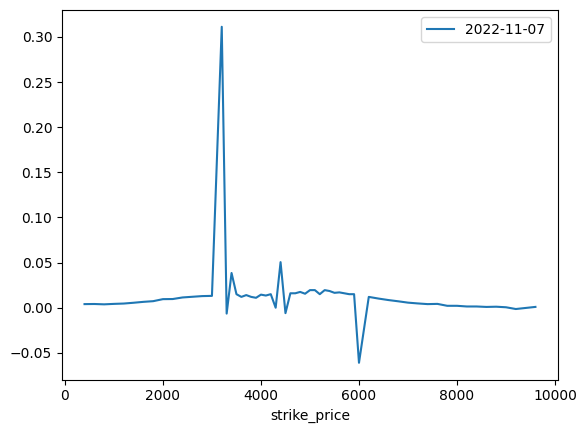

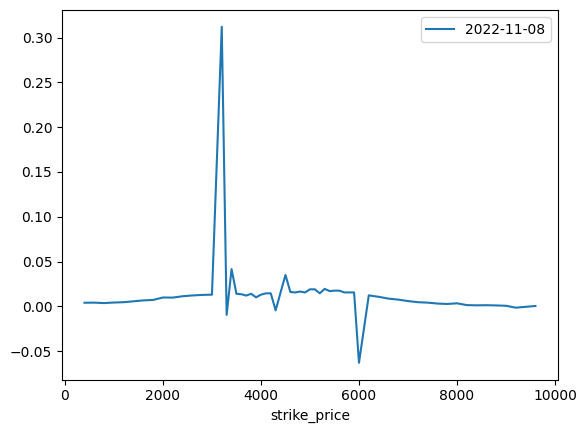

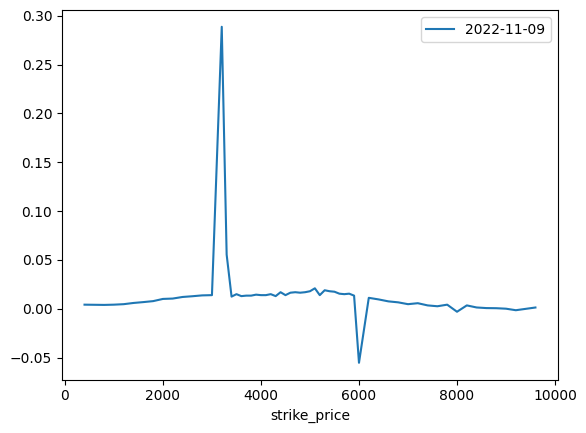

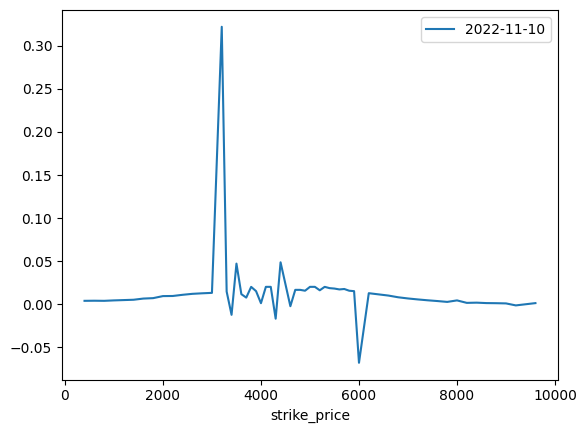

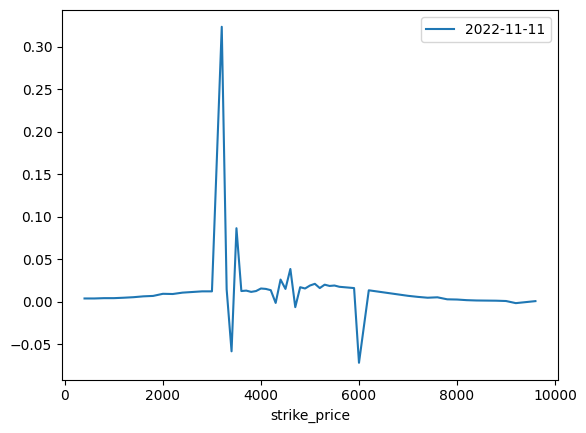

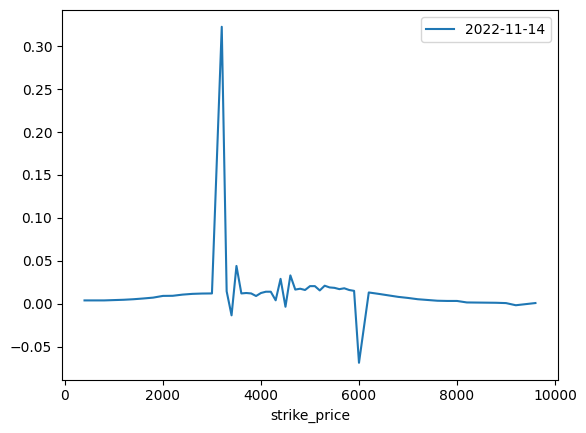

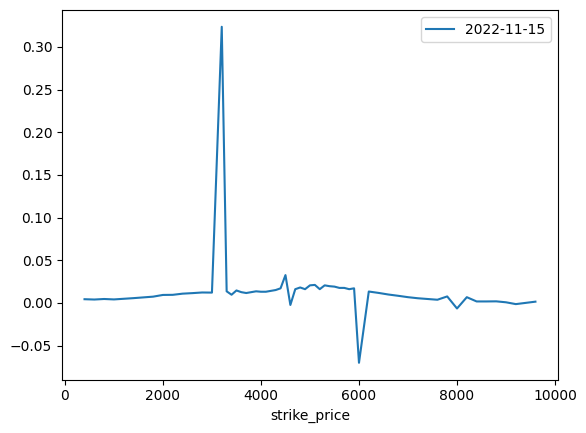

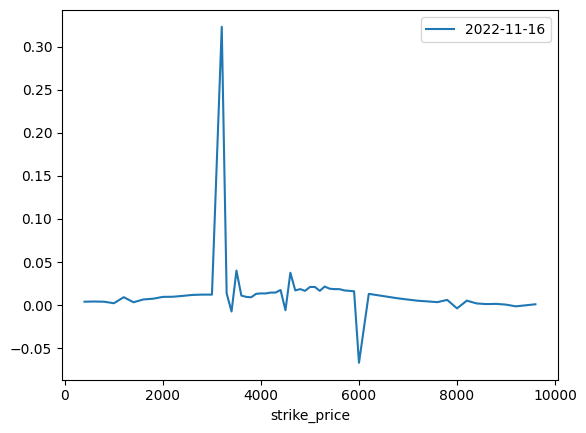

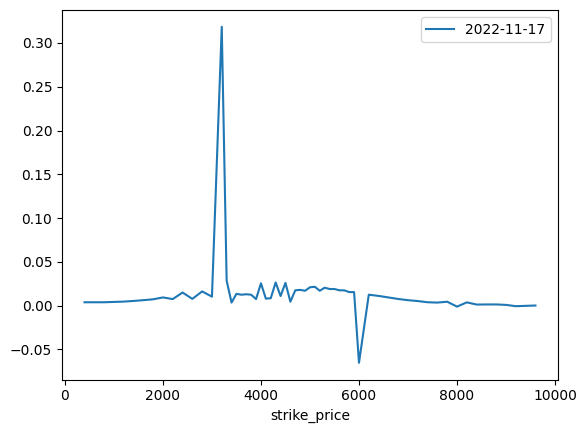

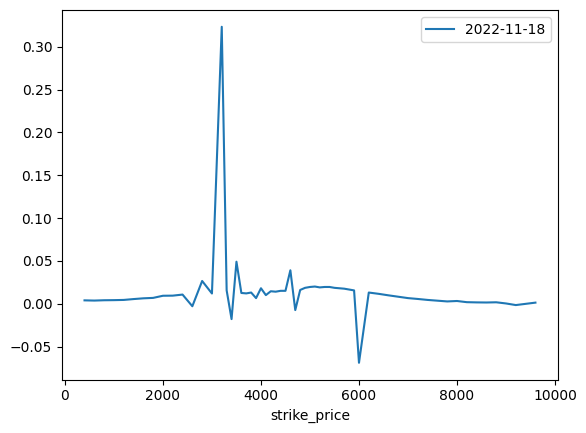

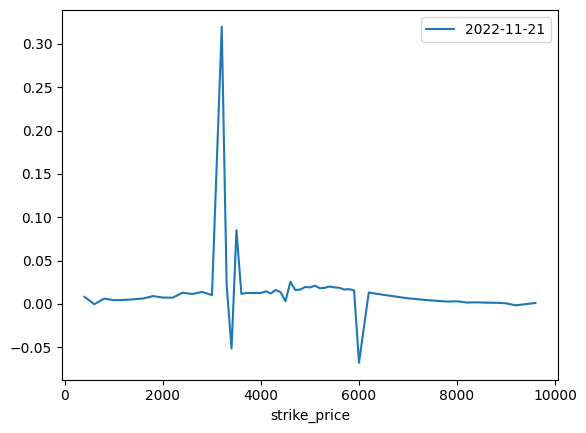

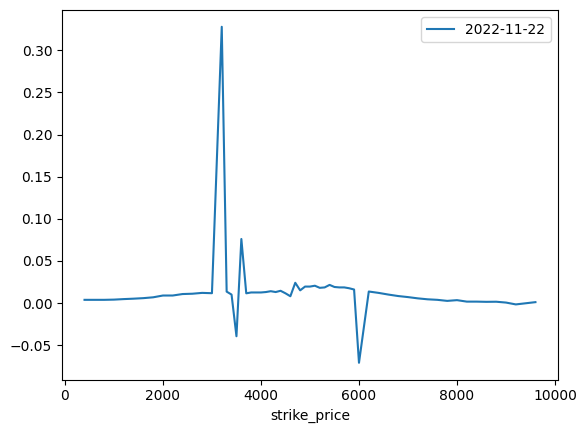

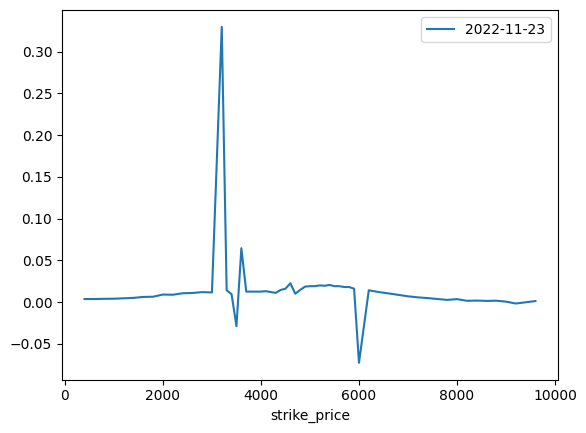

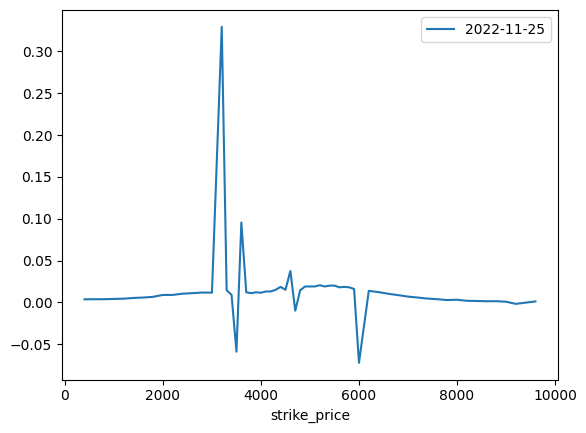

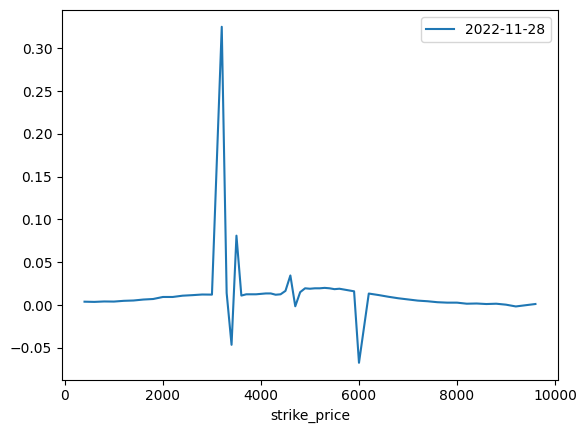

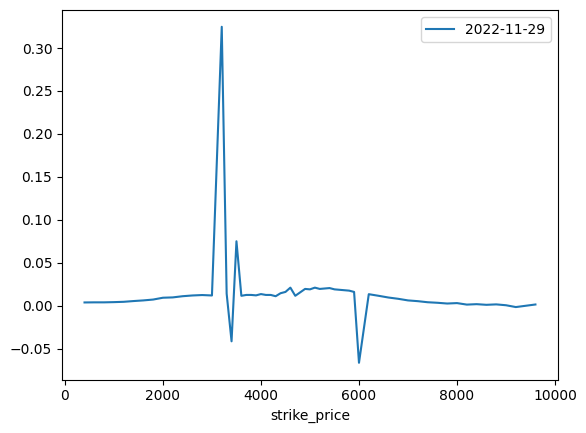

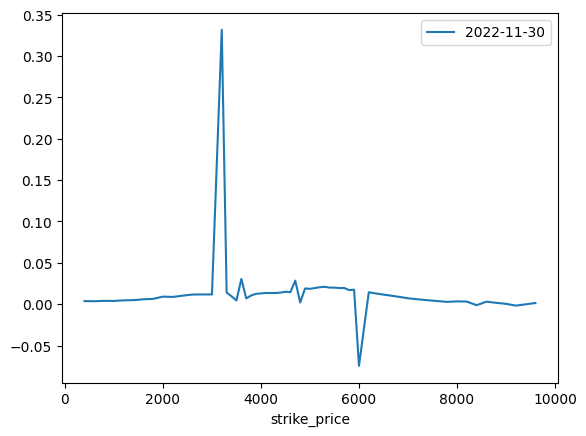

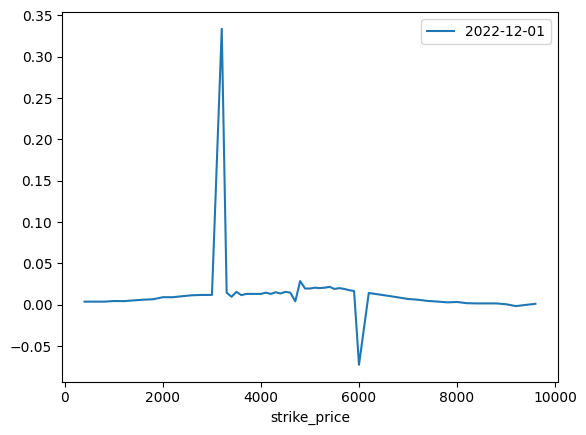

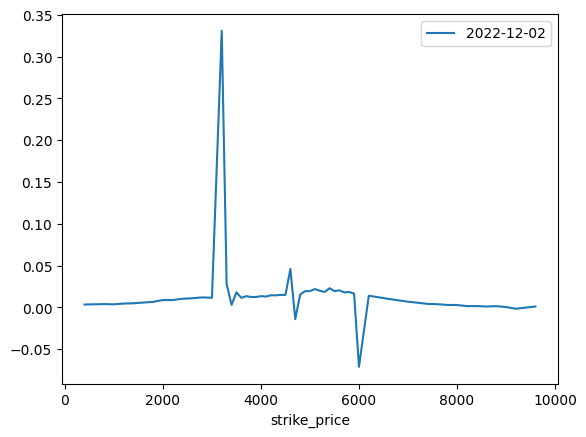

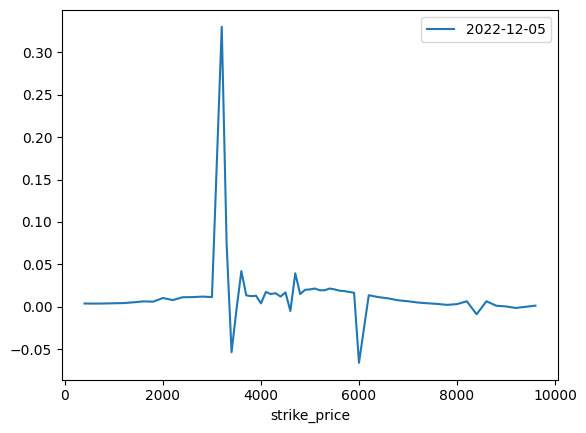

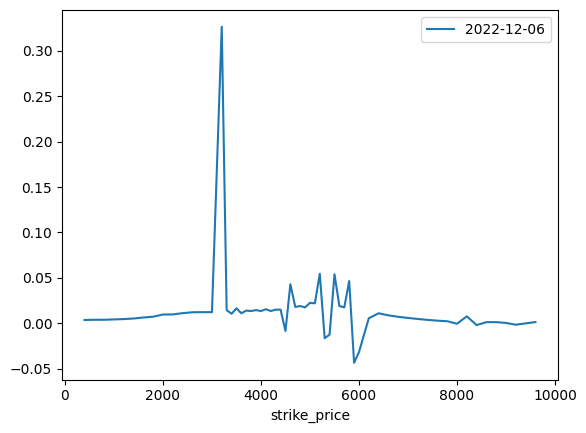

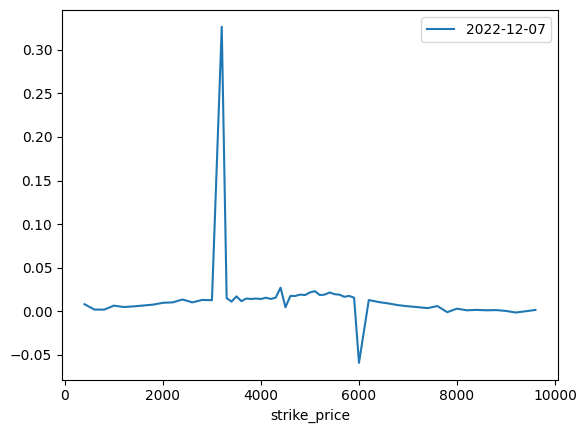

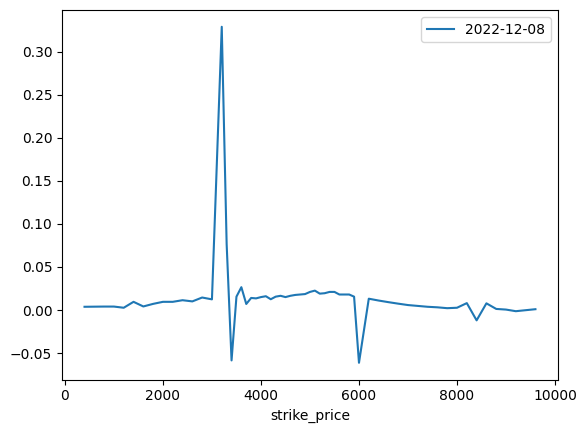

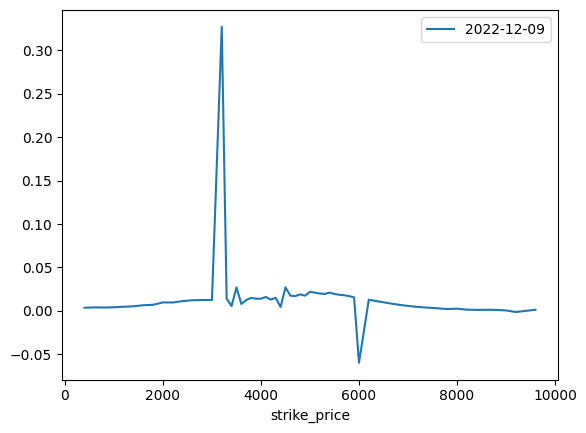

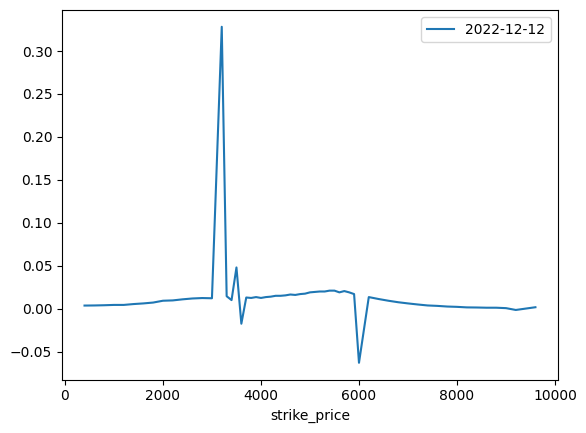

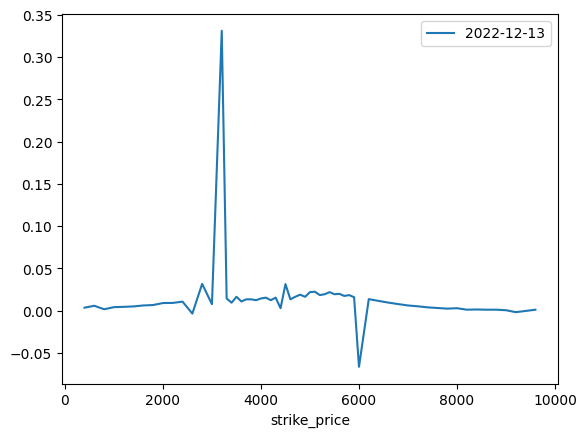

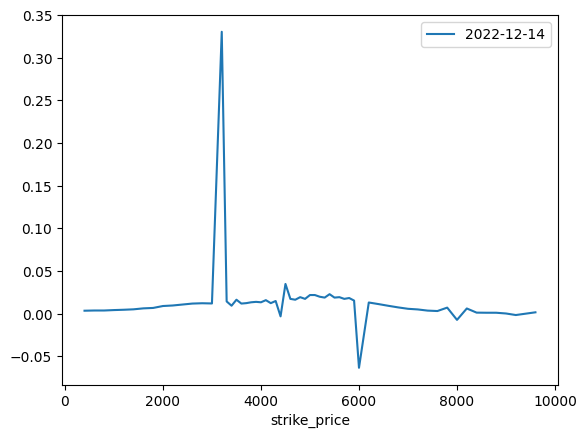

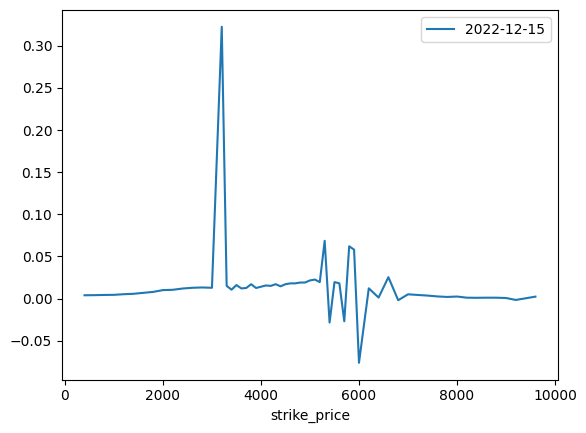

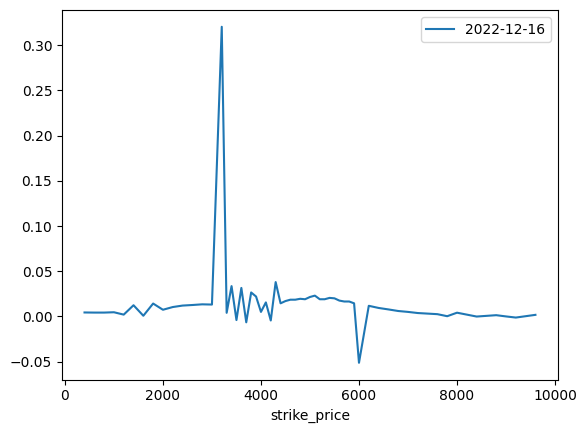

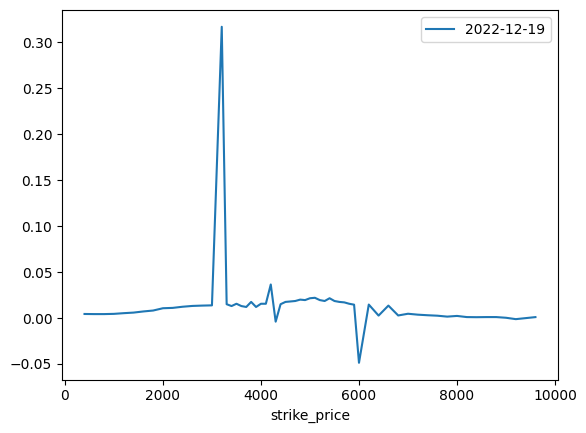

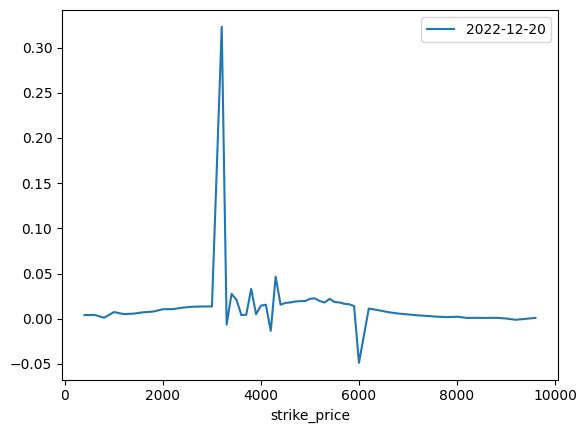

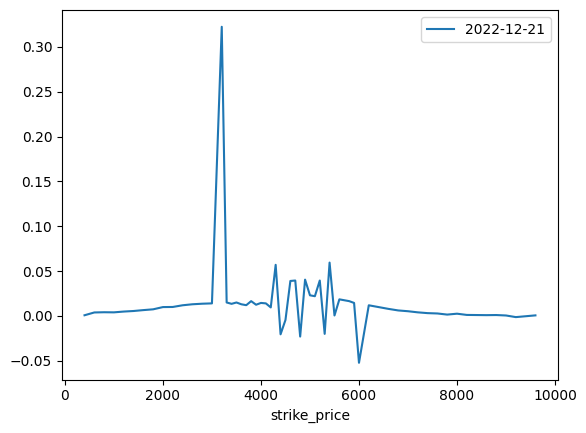

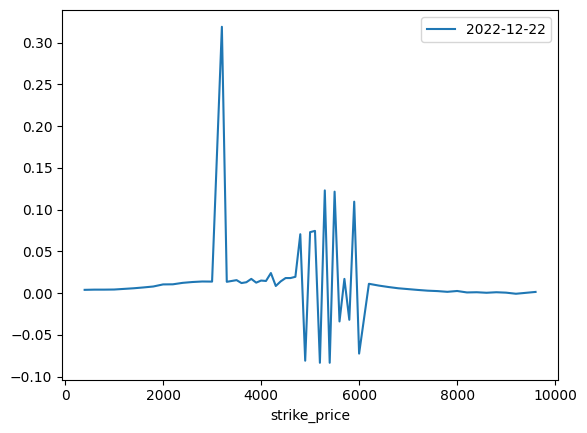

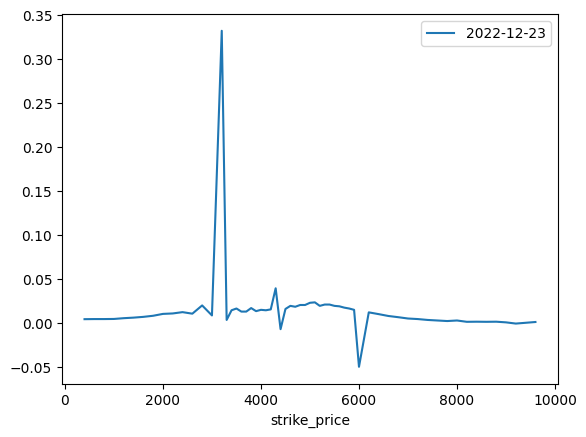

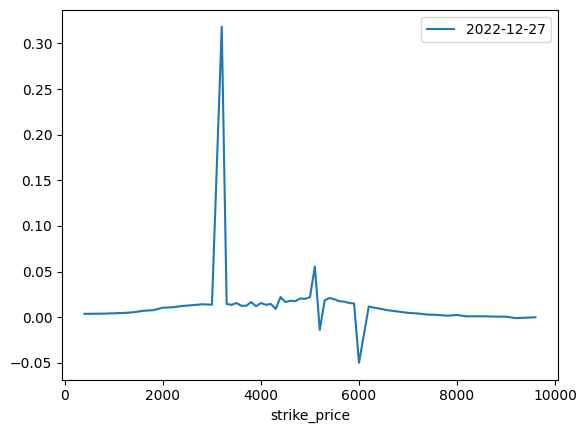

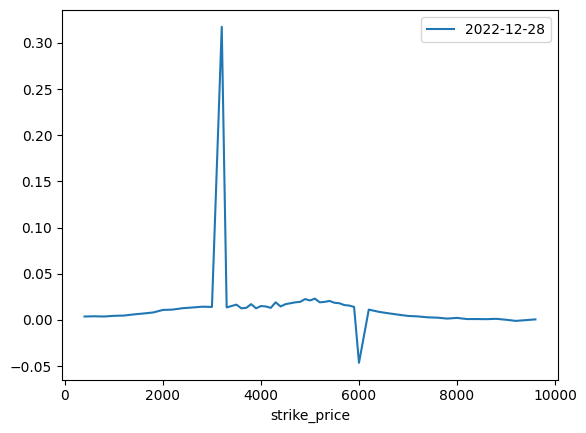

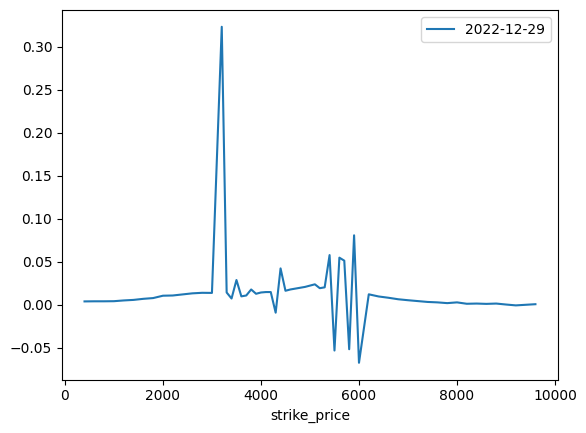

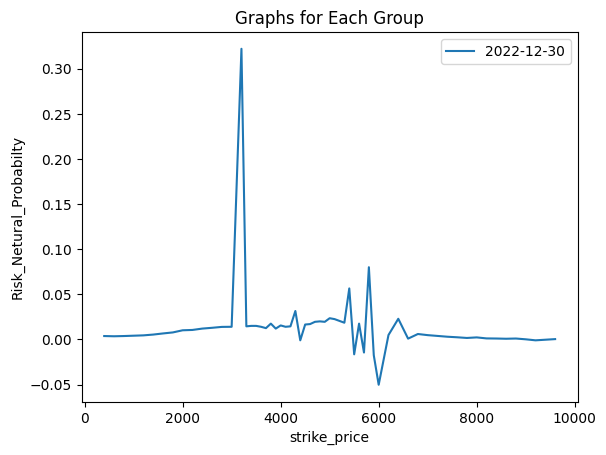

In [12]:
for name, group in grouped:
    group.plot(y='Risk_Neutral_Probability', x='strike_price', kind='line', label=name)
plt.xlabel('strike_price')
plt.ylabel('Risk_Netural_Probabilty')
plt.title('Graphs for Each Group')

# Add legend
plt.legend()

# Display the plot
plt.show()

<ipython-input-31-dc0c8ccf4d42>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  options_data_spx.groupby('strike_price').mean().plot(y='Risk_Neutral_Probability', kind='line', legend=True)


<Axes: xlabel='strike_price'>

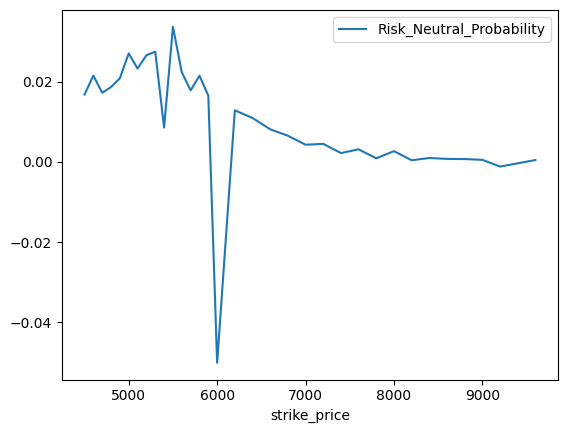

In [31]:
options_data_spx.groupby('strike_price').mean().plot(y='Risk_Neutral_Probability', kind='line', legend=True)

<ipython-input-23-dc0c8ccf4d42>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  options_data_spx.groupby('strike_price').mean().plot(y='Risk_Neutral_Probability', kind='line', legend=True)


<Axes: xlabel='strike_price'>

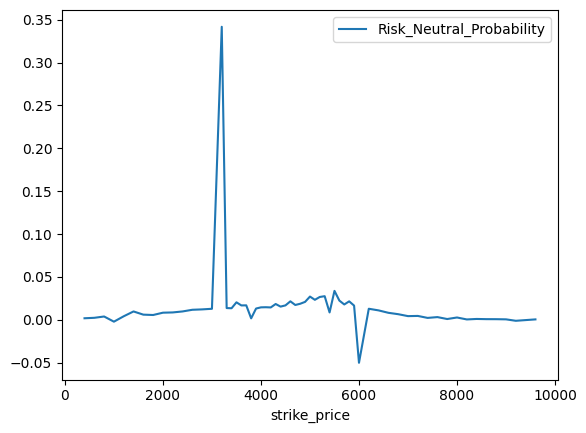

In [23]:
options_data_spx.groupby('strike_price').mean().plot(y='Risk_Neutral_Probability', kind='line', legend=True)

In [ ]:
options_data_spx["exdate"].unique()

In [ ]:
options_data_spx[(options_data_spx['exdate']=="2022-07-15")][5:1500]

In [ ]:
options_data_spx[(options_data_spx['exdate']=="2026-12-18") & (options_data_spx['best_bid']!=0) & (options_data_spx['strike_price']>3200) & (options_data_spx['Risk_Neutral_Probability']>0)].plot(y='Risk_Neutral_Probability', x='strike_price', kind='line')